In [1]:
# Imports
import torch
import torch.nn as nn 
import torch.optim as optim 
import torchvision.transforms as transforms 
import torchvision
import os
import pandas as pd
from skimage import io
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from coin_train_dataset import Coin_train_dataset
from coin_test_dataset import Coin_test_dataset

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyperparameters
in_channel = 3
num_classes = 2
learning_rate = 1e-3
batch_size = 32
num_epochs = 10

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(141),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

test_transforms = transforms.Compose([transforms.Resize(150),
                                      transforms.CenterCrop(141),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])


# Load Data
train_dataset = ImageFolder(root = './coins/train/',
                             transform = train_transforms)
test_dataset = ImageFolder(root = './coins/test/',
                             transform = test_transforms)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 0


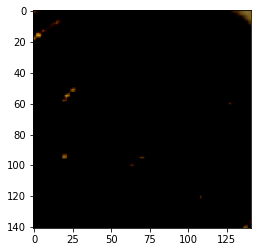

In [4]:
def show_image(image, label, dataset):
    print(f"Label: {label}") 
    plt.imshow(image.permute(1,2,0))
    plt.show()

show_image(*train_dataset[10], train_dataset)

In [5]:
train_dataset[10]

(tensor([[[-0.3333, -0.3647, -0.4275,  ..., -0.2078, -0.2471, -0.2706],
          [-0.3569, -0.3725, -0.4118,  ..., -0.2392, -0.2627, -0.2784],
          [-0.3961, -0.3961, -0.3804,  ..., -0.3098, -0.3020, -0.2941],
          ...,
          [-0.3412, -0.3412, -0.3412,  ...,  0.4824,  0.4902,  0.4902],
          [-0.3804, -0.3804, -0.3804,  ...,  0.4902,  0.4824,  0.4824],
          [-0.3961, -0.3961, -0.3961,  ...,  0.4902,  0.4824,  0.4824]],
 
         [[-0.4745, -0.5059, -0.5686,  ..., -0.3725, -0.4196, -0.4510],
          [-0.4980, -0.5137, -0.5529,  ..., -0.3961, -0.4275, -0.4510],
          [-0.5373, -0.5373, -0.5216,  ..., -0.4431, -0.4431, -0.4431],
          ...,
          [-0.4902, -0.4902, -0.4902,  ...,  0.3647,  0.3725,  0.3804],
          [-0.5294, -0.5294, -0.5294,  ...,  0.3725,  0.3725,  0.3725],
          [-0.5451, -0.5451, -0.5451,  ...,  0.3725,  0.3725,  0.3725]],
 
         [[-0.7882, -0.8196, -0.8824,  ..., -0.6392, -0.6941, -0.7176],
          [-0.8118, -0.8275,

In [6]:
dir(train_dataset[10])

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'count',
 'index']

In [7]:
# Model
model = torchvision.models.googlenet(pretrained=True)
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [8]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 8)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.fc = classifier

In [9]:
model.to(device)

# Loss and optimizer
criterion = nn.NLLLoss() 
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    print("Epoch number: " + str(epoch))
    losses = []
    
    model.train()
    
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        optimizer.zero_grad()
        
        # forward
        scores = model.forward(data)

        loss = criterion(scores, targets)
        
        losses.append(loss.item())
        
        # backward
        loss.backward()
        
        # gradient descent or adam step
        optimizer.step()

    print(f'Cost at epoch {epoch} is {sum(losses)/len(losses)}')

# Check accuracy on training to see how good our model is
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}') 
    
    model.train()

print("Checking accuracy on Training Set")
check_accuracy(train_loader, model)

print("Checking accuracy on Test Set")
check_accuracy(test_loader, model)


tensor([[-1.9533, -2.0747, -2.0352, -2.2714, -2.0826, -1.9934, -2.2501, -2.0208],
        [-1.9778, -2.2387, -2.0950, -1.9978, -2.0897, -1.9714, -2.0672, -2.2367],
        [-2.0383, -1.9844, -2.1457, -2.0247, -2.1197, -2.1686, -2.2339, -1.9536],
        [-2.1112, -1.9019, -2.1436, -2.1521, -2.2775, -2.0378, -2.1446, -1.9230],
        [-2.0528, -2.0282, -1.9916, -2.0912, -2.1068, -2.0926, -2.2355, -2.0549],
        [-2.1822, -1.9988, -2.0331, -2.0605, -2.2902, -2.0374, -2.0074, -2.0601],
        [-2.1700, -1.8128, -2.1291, -2.1982, -2.3190, -1.9562, -2.2315, -1.9272],
        [-2.1204, -1.9698, -1.9395, -2.1093, -2.2857, -2.1557, -2.1363, -1.9675],
        [-1.7985, -2.0539, -2.3252, -2.2242, -2.3520, -1.9823, -2.0398, -1.9854],
        [-2.1435, -1.9674, -2.1072, -2.1427, -2.0706, -1.9802, -2.2102, -2.0388],
        [-2.0502, -1.8786, -2.1423, -2.1751, -2.2367, -2.1475, -1.9618, -2.0930],
        [-2.1683, -1.9436, -1.9374, -2.3229, -2.1655, -2.1425, -2.0050, -2.0124],
        [-2.0949

tensor([[-1.7057, -2.4042, -1.5761, -1.9303, -3.5566, -2.8730, -2.3234, -1.6444],
        [-1.5150, -2.8031, -1.7310, -1.9449, -3.7055, -3.5382, -2.6990, -1.2782],
        [-1.5936, -2.2031, -1.9974, -1.9642, -2.9794, -2.6888, -2.2095, -1.7045],
        [-1.5813, -2.6058, -2.0879, -1.8280, -3.5245, -3.1227, -2.3904, -1.3068],
        [-1.6600, -2.2419, -1.7617, -2.0749, -3.2115, -2.7452, -2.1156, -1.7082],
        [-1.3215, -2.3882, -1.6707, -1.7964, -4.3563, -3.6815, -2.6224, -1.7325],
        [-1.4126, -2.5664, -1.9065, -1.6560, -4.1953, -3.2982, -2.6756, -1.5174],
        [-1.6933, -2.4176, -1.9574, -1.9183, -4.1015, -3.4047, -2.6161, -1.1519],
        [-1.6911, -2.4030, -1.6993, -1.9110, -3.8176, -3.2584, -2.5424, -1.3650],
        [-1.4627, -2.6650, -1.7415, -2.0739, -4.2201, -3.4893, -2.3478, -1.3585],
        [-1.7476, -2.2160, -1.9340, -2.0704, -2.9842, -2.6563, -2.2146, -1.5321],
        [-1.6827, -2.3125, -1.6220, -2.0703, -3.2883, -2.7933, -2.4418, -1.5801],
        [-1.8132

tensor([[-1.7007, -2.3427, -2.1944, -1.4761, -3.8421, -3.0638, -2.0847, -1.6663],
        [-1.6996, -2.4238, -2.1957, -1.6388, -3.3353, -2.7634, -1.9632, -1.6925],
        [-1.5924, -2.7870, -2.2144, -1.1889, -4.7676, -3.7194, -2.2966, -1.6721],
        [-1.7106, -2.5897, -1.9458, -1.1066, -4.6532, -3.2919, -2.1498, -2.2310],
        [-1.8993, -3.1223, -2.7836, -0.8206, -4.4222, -3.8290, -2.6214, -1.6202],
        [-1.4892, -2.2035, -1.9845, -1.6653, -3.7440, -3.1282, -1.9471, -2.0612],
        [-1.8241, -2.2377, -1.9199, -1.8772, -2.7953, -2.4673, -2.0296, -1.8644],
        [-1.6312, -2.3933, -1.9225, -1.7854, -3.2562, -2.5511, -2.0487, -1.8737],
        [-1.7257, -2.1387, -1.7714, -1.4960, -4.4091, -3.3980, -2.2842, -1.8167],
        [-1.6181, -2.7552, -2.0059, -1.4064, -4.2299, -3.2550, -2.1332, -1.6768],
        [-1.8595, -2.5274, -2.4417, -1.0897, -3.9020, -3.0225, -2.0597, -1.9333],
        [-1.8422, -2.5216, -1.9048, -1.3173, -3.8485, -2.9858, -2.1259, -1.8751],
        [-1.5808

tensor([[-0.9183, -3.2441, -2.1574, -1.5020, -5.5115, -3.7447, -2.8761, -1.9700],
        [-1.6866, -4.7535, -3.2946, -0.9281, -5.7622, -4.1797, -3.5591, -1.1180],
        [-1.0194, -3.5790, -2.4066, -1.3982, -5.3277, -3.5849, -3.1348, -1.6195],
        [-1.3416, -3.7820, -2.4262, -0.9384, -4.9656, -3.3114, -2.5911, -2.1389],
        [-1.4929, -3.2399, -1.9290, -1.5114, -4.1632, -2.4208, -2.2896, -1.8049],
        [-1.8565, -4.1890, -2.4492, -0.9566, -5.5088, -3.7729, -3.7156, -1.1819],
        [-1.3398, -3.0170, -1.7463, -1.7024, -4.2654, -3.2314, -2.8259, -1.5155],
        [-1.3404, -3.4737, -1.4462, -1.4436, -4.7412, -2.8430, -2.6116, -2.3504],
        [-1.3179, -3.3790, -1.8896, -1.3910, -4.4157, -2.8261, -2.6404, -1.8605],
        [-1.6067, -3.3135, -0.9135, -1.8802, -4.8273, -3.1987, -2.4655, -2.5821],
        [-0.8643, -3.7393, -2.6118, -1.3788, -5.6378, -3.9788, -3.5859, -1.7168],
        [-1.4751, -2.7860, -2.1198, -1.6160, -3.4174, -2.4651, -1.9756, -2.0072],
        [-1.0857

tensor([[-1.2016, -2.8344, -2.1227, -2.3782, -4.4498, -3.2136, -2.5289, -1.2157],
        [-1.4834, -3.6108, -2.5888, -1.6267, -5.0128, -4.0019, -3.4072, -0.8762],
        [-0.9793, -3.5285, -2.1753, -1.7845, -5.0266, -3.3473, -3.0498, -1.4938],
        [-1.3179, -3.0107, -2.2969, -1.7181, -4.2327, -3.0990, -2.6610, -1.2962],
        [-1.3588, -2.7208, -1.5769, -2.3645, -5.3863, -3.3435, -3.0868, -1.2342],
        [-1.6036, -2.7251, -1.9921, -1.8536, -4.5129, -3.6357, -3.0866, -1.0294],
        [-1.6789, -3.5020, -0.9112, -1.9729, -5.3663, -3.4080, -3.6245, -1.7274],
        [-1.4426, -3.0528, -1.9461, -2.0648, -4.5685, -3.5694, -3.3830, -0.9827],
        [-1.9326, -3.4261, -1.1213, -2.4370, -5.2506, -3.3968, -3.1534, -1.1147],
        [-1.5477, -3.2524, -1.5226, -2.2322, -5.1097, -3.7732, -3.6941, -0.9962],
        [-1.8573, -3.2545, -1.0866, -2.7327, -5.2496, -3.2659, -3.3804, -1.1226],
        [-2.3213, -3.7272, -1.1972, -2.1755, -5.2795, -3.5401, -3.5920, -0.9149],
        [-1.6406

tensor([[-1.7319, -2.8863, -1.5088, -1.8009, -4.3892, -2.8535, -1.7319, -2.0103],
        [-1.5909, -3.2128, -1.2085, -1.7786, -4.6160, -3.2346, -2.0734, -2.1762],
        [-0.5774, -3.1256, -2.2056, -2.0157, -5.9110, -4.5736, -3.2149, -2.3216],
        [-1.6164, -2.6003, -1.1491, -2.1220, -3.9972, -3.0502, -2.3298, -2.0605],
        [-1.3511, -2.2508, -2.0585, -2.2684, -4.5768, -3.3042, -2.7987, -1.2150],
        [-1.8459, -2.9378, -1.6492, -1.5728, -4.4240, -2.8551, -2.0276, -1.6698],
        [-0.9607, -2.5566, -2.2043, -2.2284, -4.2742, -3.4321, -2.7064, -1.5666],
        [-0.8863, -2.8289, -1.7518, -2.1069, -5.5155, -3.4888, -2.2744, -2.3408],
        [-1.5465, -3.0473, -1.4886, -1.9271, -4.8291, -2.9372, -2.6604, -1.4383],
        [-2.4510, -2.6714, -0.6118, -2.9956, -5.2233, -3.6155, -3.3104, -1.6956],
        [-1.1887, -2.3621, -2.5708, -2.7388, -5.7632, -4.1813, -3.1141, -0.9233],
        [-2.0416, -2.6671, -0.7455, -2.9515, -5.4513, -4.1268, -4.0534, -1.4431],
        [-1.9730

tensor([[-2.5274, -4.3278, -2.5835, -1.1305, -6.1214, -3.8459, -2.5937, -0.8910],
        [-2.4361, -3.0154, -1.0308, -2.0112, -4.9666, -2.9452, -1.3302, -3.0171],
        [-1.4761, -2.1673, -1.3629, -2.0932, -5.8206, -3.5894, -2.8244, -1.6721],
        [-1.8025, -3.7985, -2.4422, -1.2737, -5.4139, -3.4768, -1.9382, -1.3219],
        [-2.2264, -2.6099, -1.5067, -1.7734, -4.7749, -3.5739, -2.3103, -1.2329],
        [-2.2429, -3.3150, -2.2549, -1.1606, -4.1888, -3.1262, -2.0971, -1.3568],
        [-2.4339, -2.9836, -0.8272, -2.0494, -4.1369, -2.7147, -1.8548, -2.8656],
        [-1.8850, -3.0005, -1.5246, -1.2983, -4.8315, -3.1639, -2.1310, -1.9750],
        [-2.1945, -3.0469, -2.1245, -1.8476, -4.4576, -2.9024, -1.8924, -1.0591],
        [-2.1394, -2.3115, -1.9761, -2.0419, -5.1314, -3.4635, -1.8871, -1.1208],
        [-1.7171, -2.4289, -1.8033, -1.8085, -4.4076, -3.0490, -1.8042, -1.7179],
        [-1.5890, -3.2948, -2.0582, -1.1928, -4.5801, -3.2406, -1.7451, -2.2660],
        [-0.8640

tensor([[-1.9244, -3.1968, -1.1483, -1.6834, -4.6281, -3.1244, -1.6992, -2.6080],
        [-2.5819, -2.9199, -0.5638, -2.1446, -5.6394, -3.2697, -2.4109, -2.9383],
        [-2.4445, -2.3669, -2.1374, -2.2461, -5.2146, -4.0836, -3.0254, -0.6446],
        [-2.2711, -3.2683, -2.0229, -1.1497, -4.0979, -2.8563, -1.7393, -1.8326],
        [-1.4798, -1.7166, -2.7271, -2.3812, -4.2479, -3.5928, -2.1507, -1.2852],
        [-1.3847, -2.6283, -2.0811, -1.3645, -5.4915, -3.6065, -2.0948, -1.9467],
        [-1.3857, -2.4829, -2.1479, -1.4210, -5.0618, -3.4019, -2.1819, -1.8599],
        [-2.6675, -1.2727, -1.0327, -2.0137, -5.2849, -4.1979, -3.2276, -2.2906],
        [-1.5914, -2.9838, -3.5560, -1.5595, -4.5831, -3.7858, -2.3586, -0.9689],
        [-2.3540, -2.9045, -1.4557, -0.9346, -5.4410, -3.5988, -2.2855, -2.3985],
        [-1.8839, -2.7395, -3.8308, -2.3436, -5.7860, -4.0516, -2.6531, -0.5537],
        [-2.0046, -3.7345, -1.5746, -1.0601, -5.6985, -3.7289, -1.7961, -2.3582],
        [-1.9304

tensor([[-1.3978, -2.5606, -1.8296, -1.6397, -3.9659, -3.0652, -1.9094, -2.2319],
        [-1.9279, -1.7189, -1.5647, -2.7612, -4.7274, -2.9896, -2.0586, -1.5319],
        [-2.0295, -2.9217, -2.4147, -1.6327, -4.5370, -3.3148, -1.6066, -1.2646],
        [-2.0418, -2.8531, -1.2668, -2.2404, -4.6199, -3.2130, -1.9289, -1.4740],
        [-2.1769, -2.8280, -0.4985, -2.2219, -5.4125, -3.7953, -3.2510, -3.0793],
        [-1.5730, -2.4034, -1.9925, -3.1849, -5.5785, -4.6498, -3.3187, -0.7447],
        [-1.4014, -2.6737, -3.6123, -2.5960, -4.7892, -4.2586, -2.5320, -0.7314],
        [-1.9302, -2.2974, -2.0607, -1.8234, -2.9983, -2.5132, -2.0603, -1.5740],
        [-2.1195, -3.6057, -1.1236, -1.0393, -6.1128, -3.5896, -2.8085, -2.4792],
        [-1.2890, -2.7355, -1.9706, -2.4438, -4.6805, -3.4274, -1.8164, -1.4739],
        [-1.3611, -2.8241, -1.7269, -1.7802, -4.8651, -3.3804, -1.8258, -2.0025],
        [-0.8674, -2.2711, -2.3733, -2.1457, -4.9553, -3.5017, -2.5897, -1.8684],
        [-1.9049

tensor([[-1.2108, -2.1787, -1.7360, -2.5805, -4.4405, -3.2919, -2.4508, -1.6010],
        [-1.0582, -2.9711, -2.9914, -2.2576, -4.6404, -3.6750, -3.0313, -1.0117],
        [-1.8522, -3.1747, -1.5312, -1.2438, -5.2323, -3.2201, -2.0630, -2.0845],
        [-0.6966, -2.2048, -3.7844, -3.2962, -5.4850, -4.2723, -2.8286, -1.3684],
        [-1.4950, -1.8594, -2.1381, -2.8336, -4.6104, -3.2956, -2.2986, -1.2177],
        [-2.3685, -2.3242, -0.9232, -2.1964, -4.6420, -3.2458, -3.0991, -1.5779],
        [-1.8333, -3.3893, -1.2546, -1.4883, -4.5946, -3.0610, -2.0317, -2.2316],
        [-0.7552, -3.4174, -1.8190, -1.5634, -6.3307, -3.9059, -2.9965, -2.9220],
        [-0.9510, -2.1516, -2.3664, -2.2766, -5.2962, -3.6453, -3.0786, -1.4973],
        [-2.2852, -2.8095, -0.4993, -2.6283, -5.9860, -3.4752, -2.9994, -2.5825],
        [-1.6577, -1.9114, -1.2221, -2.5185, -5.6857, -3.5817, -3.5027, -1.4916],
        [-2.4512, -2.8574, -0.8835, -1.7638, -5.1912, -3.2682, -3.0148, -1.7205],
        [-1.9371

tensor([[-0.8725, -2.9358, -3.6979, -2.1516, -4.5087, -3.9053, -2.3844, -1.3294],
        [-2.3761, -3.5020, -4.5891, -2.5931, -5.2308, -4.6429, -3.6927, -0.2849],
        [-2.4248, -1.1631, -3.3257, -2.5858, -4.5850, -4.1033, -3.6126, -0.8347],
        [-1.1461, -2.8165, -3.3176, -1.8628, -4.9180, -4.1854, -2.4934, -1.1219],
        [-2.7719, -3.4994, -1.7664, -0.6294, -5.7415, -3.9554, -4.0015, -1.8157],
        [-2.0675, -3.4426, -3.6220, -1.2253, -4.7053, -3.7153, -2.2007, -0.9755],
        [-1.5294, -1.4179, -2.7064, -2.9848, -5.6481, -4.7327, -4.1961, -0.9253],
        [-1.7409, -4.7859, -4.1768, -0.6190, -6.0036, -4.2249, -2.4258, -1.8517],
        [-1.5081, -3.1514, -2.8003, -1.2673, -3.8136, -3.3378, -1.9767, -1.6226],
        [-1.1265, -3.2675, -2.9656, -1.3627, -3.9397, -3.0739, -1.8966, -2.1675],
        [-1.3744, -3.4101, -1.5327, -1.1638, -4.7839, -3.7221, -3.3475, -2.1372],
        [-5.2681, -5.2286, -0.0407, -4.3694, -7.8746, -4.9461, -5.5298, -5.2520],
        [-1.0338

tensor([[-2.2701, -2.2577, -4.2702, -2.7633, -3.6841, -5.0112, -2.9724, -0.4587],
        [-3.2127, -2.2973, -0.5623, -2.6094, -4.2632, -4.0261, -3.3257, -1.9112],
        [-1.2612, -2.4745, -4.0938, -1.0277, -5.0846, -5.8956, -3.2401, -1.5612],
        [-2.6324, -3.7145, -0.3656, -2.2014, -4.7964, -4.4030, -2.7805, -4.0867],
        [-2.1432, -3.6289, -2.9435, -0.7219, -4.3011, -4.1577, -1.8784, -1.9977],
        [-1.3951, -1.5228, -3.6416, -1.4856, -4.3360, -5.4822, -2.6370, -1.6467],
        [-1.1891, -2.9870, -2.6830, -1.7415, -3.6361, -3.8701, -1.6333, -1.8390],
        [-3.4161, -3.4311, -0.6045, -1.7313, -4.5829, -3.6087, -2.3219, -2.5772],
        [-1.6953, -2.9054, -1.4264, -1.3744, -4.3631, -4.1688, -2.1122, -2.1255],
        [-2.3202, -3.5177, -2.1816, -1.5271, -5.1396, -4.6394, -1.4471, -1.2335],
        [-1.9299, -2.5477, -2.4159, -1.6900, -3.0255, -3.0046, -1.8635, -1.3881],
        [-1.5422, -3.4965, -2.2515, -1.1219, -4.0966, -3.7436, -1.8470, -2.0645],
        [-4.6054

tensor([[-1.5062, -4.0931, -1.0085, -1.8777, -3.4694, -4.1172, -1.8611, -3.1958],
        [-0.8942, -4.4014, -3.4221, -1.4381, -3.6268, -4.8519, -2.4709, -1.6615],
        [-0.7060, -4.8403, -6.1015, -2.3022, -4.4695, -5.3426, -1.9754, -1.4218],
        [-1.3126, -3.8587, -1.4470, -1.6005, -3.5373, -3.0971, -1.8433, -3.2148],
        [-1.5011, -2.6101, -1.6015, -2.1225, -2.6186, -3.0375, -2.2412, -1.8638],
        [-2.1078, -2.3866, -2.7714, -2.4584, -2.4869, -3.4780, -2.1377, -0.9003],
        [-2.6553, -3.6173, -0.5741, -2.9940, -3.7897, -3.4271, -1.7758, -2.7315],
        [-0.5096, -4.4582, -4.4175, -2.1477, -4.6006, -5.4183, -2.4707, -1.8335],
        [-1.5985, -3.2433, -2.7007, -1.9275, -3.0816, -3.2664, -1.2905, -1.6769],
        [-1.5919, -2.9118, -3.1261, -2.5071, -2.7076, -4.2816, -2.7543, -0.7497],
        [-0.6668, -4.1505, -6.2435, -3.0032, -4.0481, -4.8865, -1.9216, -1.3946],
        [-1.5904, -3.1872, -0.6558, -2.8035, -3.5484, -3.4033, -2.4122, -3.7481],
        [-1.8278

tensor([[-0.8494, -4.5044, -4.5455, -2.5780, -4.2611, -4.5323, -1.0075, -2.4683],
        [-2.6020, -3.7068, -0.6463, -2.9991, -2.6181, -2.8598, -2.6116, -2.0886],
        [-2.8495, -3.7606, -0.6756, -2.2096, -3.3018, -2.1000, -2.3811, -3.0255],
        [-1.6800, -3.7707, -2.0378, -1.6142, -2.9182, -3.5978, -1.8368, -1.5120],
        [-0.9890, -2.6104, -3.2205, -2.3648, -3.2879, -4.1370, -3.1683, -1.1231],
        [-1.7335, -2.0439, -2.0255, -2.9510, -2.3035, -3.4259, -2.2532, -1.3015],
        [-0.7250, -3.3081, -2.8186, -2.4040, -3.2773, -4.0314, -1.7651, -2.2789],
        [-0.9668, -4.2134, -2.2195, -1.6051, -3.1880, -3.4855, -1.8375, -2.7449],
        [-4.9238, -5.4651, -0.0583, -3.9840, -5.1728, -4.8512, -5.3351, -4.7983],
        [-2.4842, -4.5591, -0.3147, -2.7837, -3.5543, -3.4779, -3.2025, -4.2576],
        [-1.6057, -3.7904, -3.0653, -1.5847, -3.5219, -3.2888, -1.1206, -2.0242],
        [-0.5717, -3.5797, -3.4818, -1.8357, -2.7413, -4.2854, -2.8729, -2.4947],
        [-0.5895

tensor([[-0.8715, -3.8192, -3.6866, -1.1901, -3.3569, -3.4295, -3.3996, -2.0415],
        [-1.3892, -2.0957, -2.5123, -2.0194, -2.7234, -2.5241, -1.9455, -2.0776],
        [-0.6649, -5.2740, -7.4542, -1.2688, -4.7674, -5.1416, -2.2223, -2.5760],
        [-2.0779, -3.8636, -5.4811, -1.6931, -3.1865, -3.8290, -3.0563, -0.5877],
        [-1.3993, -2.6905, -4.0469, -2.1890, -2.9823, -3.2223, -2.3369, -0.9978],
        [-1.3373, -3.5606, -2.2393, -0.8106, -3.8962, -2.8122, -3.1972, -3.3070],
        [-3.9700, -3.7226, -5.8447, -3.0353, -3.3248, -4.7055, -4.7528, -0.1598],
        [-2.5627, -4.9406, -2.3163, -0.4859, -4.3602, -2.8186, -2.2107, -3.9182],
        [-1.6478, -2.2246, -5.7937, -2.7504, -2.8988, -3.7459, -2.7675, -0.7114],
        [-1.9475, -4.3472, -3.1836, -0.5945, -3.4991, -3.0661, -2.4143, -2.4661],
        [-1.6766, -3.6175, -2.9341, -1.7072, -3.0090, -2.4722, -1.8777, -1.3284],
        [-1.3391, -2.9282, -3.3806, -1.4001, -2.7988, -2.9515, -2.0566, -1.8152],
        [-2.2619

tensor([[-1.8749, -4.6737, -3.5950, -0.6793, -4.3754, -2.6114, -2.1504, -2.2988],
        [-1.2933, -3.3401, -2.4612, -1.4878, -3.2724, -2.4422, -2.4426, -1.7886],
        [-2.5424, -2.9496, -5.4912, -2.4194, -4.1619, -3.6690, -3.2423, -0.3628],
        [-0.5920, -3.8694, -3.8957, -1.5584, -4.2655, -3.3337, -2.2535, -3.2092],
        [-1.4267, -2.0209, -2.4447, -1.5554, -3.4726, -2.5206, -2.9176, -1.8079],
        [-1.8157, -2.1226, -3.7116, -1.8542, -2.8183, -3.0983, -3.2076, -0.9384],
        [-2.0600, -2.7250, -4.7538, -2.1340, -3.7297, -3.6212, -3.1030, -0.5372],
        [-1.3710, -2.8566, -5.0314, -2.2443, -3.9320, -3.7710, -1.9260, -0.9473],
        [-1.1113, -3.3838, -2.2071, -1.0756, -3.6846, -2.9423, -2.6825, -3.2291],
        [-1.4634, -2.7569, -8.5005, -3.2174, -4.6660, -5.5096, -3.1795, -0.4947],
        [-1.1901, -2.7555, -3.2836, -1.1652, -3.2847, -3.1062, -2.6793, -2.0245],
        [-1.0573, -2.7828, -3.2812, -1.1777, -3.9203, -2.6984, -3.3693, -2.0907],
        [-1.6676

tensor([[-1.6350, -4.3544, -7.0199, -1.6505, -4.7250, -4.8620, -2.6078, -0.6752],
        [-4.3559, -4.6001, -0.1601, -3.8567, -5.0369, -2.4979, -4.6820, -5.1383],
        [-0.9633, -3.0539, -3.3026, -2.0033, -4.1350, -3.2344, -1.8195, -1.7037],
        [-1.6077, -4.3545, -2.8598, -0.6961, -4.9188, -2.9536, -2.2064, -2.7896],
        [-1.6046, -4.3097, -4.8868, -1.2649, -4.7692, -3.9730, -1.1803, -1.8247],
        [-1.7509, -1.9962, -3.8354, -1.6770, -3.7180, -3.0173, -2.5622, -1.1037],
        [-1.8168, -3.3042, -3.2041, -1.8023, -4.2804, -3.5518, -3.4590, -0.6516],
        [-0.9907, -3.3322, -3.2687, -1.6091, -4.0802, -2.6671, -2.5765, -1.6479],
        [-0.9432, -2.0452, -3.5873, -3.1584, -4.1689, -3.7104, -1.3542, -2.1802],
        [-1.8095, -3.4915, -1.8760, -1.3703, -3.8611, -1.9767, -2.2974, -1.9771],
        [-2.2994, -3.4230, -0.8797, -1.5672, -3.6536, -2.4163, -2.3977, -3.2853],
        [-2.5308, -3.9098, -0.3235, -3.5231, -4.0722, -3.5197, -3.2468, -2.7857],
        [-0.9267

tensor([[-1.7512e+00, -3.3438e+00, -1.4001e+00, -1.6120e+00, -3.7605e+00,
         -2.4647e+00, -2.1268e+00, -2.1409e+00],
        [-1.4365e+00, -1.8590e+00, -1.3019e+00, -2.4069e+00, -3.8882e+00,
         -4.2149e+00, -4.8820e+00, -1.6022e+00],
        [-1.6605e+00, -3.2369e+00, -2.2915e+00, -1.4554e+00, -3.2563e+00,
         -2.5993e+00, -1.6478e+00, -2.0331e+00],
        [-1.2306e+00, -3.0974e+00, -8.0539e-01, -2.6135e+00, -4.4070e+00,
         -3.9103e+00, -2.6015e+00, -3.3205e+00],
        [-8.9637e-01, -3.3821e+00, -4.9351e+00, -1.1902e+00, -4.5739e+00,
         -4.2902e+00, -2.7646e+00, -1.8351e+00],
        [-3.4060e+00, -3.3162e+00, -6.2757e-01, -1.9427e+00, -4.0610e+00,
         -2.6742e+00, -2.6103e+00, -2.3684e+00],
        [-3.9841e+00, -5.6271e+00, -7.7506e-02, -4.1701e+00, -5.8943e+00,
         -3.6805e+00, -5.0055e+00, -6.0956e+00],
        [-8.7524e-01, -4.1695e+00, -4.4438e+00, -1.4795e+00, -5.9259e+00,
         -5.0960e+00, -1.6204e+00, -2.1066e+00],
        [-8.8700

tensor([[-1.6392e+00, -4.1618e+00, -3.4831e+00, -5.2289e-01, -4.4125e+00,
         -3.8657e+00, -2.5571e+00, -2.8794e+00],
        [-1.7548e+00, -2.5689e+00, -4.9335e-01, -4.5175e+00, -3.9154e+00,
         -4.2443e+00, -4.2357e+00, -2.5232e+00],
        [-1.4878e+00, -4.2762e+00, -1.2217e+00, -1.4916e+00, -5.6573e+00,
         -4.0063e+00, -1.6620e+00, -3.5386e+00],
        [-2.4210e+00, -3.5615e+00, -1.0015e+00, -1.8236e+00, -4.5852e+00,
         -3.7464e+00, -2.7552e+00, -1.3602e+00],
        [-6.9098e-01, -4.2187e+00, -1.3848e+00, -1.8774e+00, -5.6630e+00,
         -3.5256e+00, -3.6141e+00, -3.8633e+00],
        [-1.5122e+00, -2.9422e+00, -1.4777e+00, -1.7207e+00, -3.2722e+00,
         -2.8363e+00, -2.0876e+00, -2.3109e+00],
        [-3.2811e+00, -4.8082e+00, -8.5785e+00, -5.4010e+00, -5.5249e+00,
         -7.6791e+00, -5.8513e+00, -5.9510e-02],
        [-1.6824e+00, -2.1744e+00, -4.1346e+00, -3.1791e+00, -3.7864e+00,
         -5.0764e+00, -1.6380e+00, -8.6874e-01],
        [-1.7681

tensor([[-2.3807, -4.6297, -3.6323, -0.5888, -5.5140, -3.7038, -2.8415, -1.4727],
        [-1.9346, -1.7588, -2.0455, -2.8492, -3.1449, -2.7693, -2.9837, -1.0798],
        [-2.1630, -1.5550, -4.3344, -4.0020, -2.7066, -4.6428, -3.5474, -0.6213],
        [-1.4873, -2.7478, -4.1408, -2.5445, -4.2836, -3.9292, -2.2868, -0.7329],
        [-1.7418, -1.2013, -4.3881, -4.4367, -2.8259, -4.7873, -3.1346, -0.9451],
        [-2.6610, -4.7106, -0.3163, -4.0380, -5.7576, -2.8432, -2.2552, -4.7802],
        [-1.8668, -2.6099, -3.1786, -1.8415, -3.2204, -3.4415, -1.0350, -1.9348],
        [-2.1023, -2.9021, -1.7870, -1.9208, -3.4842, -2.2357, -1.4345, -2.0164],
        [-1.4460, -1.7518, -5.0812, -3.3817, -2.5213, -5.0659, -3.4914, -0.8354],
        [-1.1149, -0.9851, -3.2104, -2.8962, -2.7815, -4.4117, -3.7394, -2.2517],
        [-1.7422, -2.3366, -1.5951, -2.2753, -3.5039, -2.7198, -2.8528, -1.3134],
        [-2.6471, -3.8724, -3.3058, -2.8664, -4.8315, -3.3699, -0.8028, -1.1261],
        [-2.0131

tensor([[-1.9381, -4.8644, -4.3793, -0.5503, -5.2673, -2.7509, -1.8106, -3.6330],
        [-1.2799, -3.0532, -1.1537, -1.7750, -3.4998, -3.9700, -2.2409, -3.3712],
        [-1.1164, -4.9920, -3.8764, -1.1331, -5.3690, -3.6131, -1.2715, -4.5141],
        [-3.0203, -4.9653, -0.2030, -2.9218, -5.7552, -3.3481, -3.3636, -6.7017],
        [-1.5661, -4.3726, -4.3878, -0.6964, -4.7962, -3.0196, -1.6873, -3.6653],
        [-0.7098, -4.4654, -3.9187, -1.2052, -5.4458, -3.7394, -2.0351, -3.9906],
        [-0.8121, -1.6782, -3.8636, -2.4509, -3.6435, -4.1737, -2.1002, -2.3210],
        [-1.6010, -4.2746, -3.7133, -0.7425, -4.8905, -3.5380, -1.4917, -3.7944],
        [-1.0090, -2.7789, -5.0233, -1.4628, -3.4435, -3.6778, -2.4653, -1.6456],
        [-1.7890, -0.7969, -4.0278, -2.0847, -2.3593, -4.1483, -4.0374, -2.1886],
        [-1.4897, -1.6702, -2.8111, -2.1851, -3.2640, -3.2434, -1.7662, -1.7988],
        [-1.1708, -4.3917, -4.2798, -0.7574, -5.0495, -3.6310, -2.2820, -2.8166],
        [-1.1729

tensor([[-0.8149, -1.8198, -5.8444, -2.3462, -3.2122, -5.4305, -3.7043, -1.4812],
        [-1.2466, -3.3131, -8.5566, -1.0972, -5.0916, -6.0182, -3.1106, -1.2414],
        [-2.6217, -3.5188, -2.3130, -0.8602, -4.9708, -1.4304, -2.1007, -4.9422],
        [-0.8460, -2.7446, -5.1680, -1.9187, -2.6672, -4.7912, -1.9796, -1.9788],
        [-1.4484, -3.7295, -6.5249, -1.1793, -4.3841, -3.7672, -2.7893, -1.0935],
        [-0.9596, -4.2308, -5.2378, -0.8305, -4.5325, -4.3469, -2.5413, -2.8333],
        [-3.0578, -4.9730, -2.3965, -0.9643, -6.0126, -2.1687, -1.0491, -4.9952],
        [-0.8370, -2.1826, -3.1041, -1.9470, -2.8246, -3.1597, -2.4235, -2.5731],
        [-0.8221, -1.6078, -3.0352, -2.0485, -3.2292, -3.8201, -2.6383, -2.9923],
        [-1.3339, -3.1198, -3.4021, -1.1297, -3.8839, -2.7290, -1.4798, -3.7994],
        [-0.2812, -2.8874, -4.3702, -2.7395, -3.5845, -4.7209, -3.2624, -3.2920],
        [-1.6843, -2.0264, -1.0704, -2.2883, -3.7287, -2.7695, -2.0503, -3.7777],
        [-2.6596

tensor([[-2.1403, -2.2295, -0.4725, -2.7645, -3.6592, -3.3051, -4.1962, -4.5250],
        [-1.8379, -2.4403, -2.3115, -1.7428, -3.8489, -2.0918, -2.1020, -1.5484],
        [-1.0391, -3.2819, -8.5148, -1.1172, -4.0681, -6.6859, -4.7087, -1.3709],
        [-1.8370, -3.2199, -4.2414, -1.1448, -3.5369, -3.9289, -3.2039, -0.9710],
        [-0.7012, -2.4969, -3.2357, -1.7987, -4.0500, -3.6365, -2.2914, -2.6318],
        [-2.8793, -3.0463, -7.9191, -3.4027, -4.7481, -5.7172, -3.9582, -0.1844],
        [-1.7495, -3.7038, -2.1624, -0.9958, -4.1025, -2.6381, -1.7478, -2.9033],
        [-0.4517, -2.8413, -5.7423, -2.4982, -3.9766, -4.6443, -4.0267, -1.7518],
        [-5.2344, -6.0087, -0.0493, -5.7204, -7.1827, -3.4580, -5.4286, -7.8635],
        [-2.7094, -2.9387, -5.2851, -2.5764, -3.5515, -3.5986, -3.7974, -0.3272],
        [-1.6461, -5.4717, -4.9021, -1.2431, -5.4839, -3.8892, -0.7688, -3.9684],
        [-1.4324, -2.6856, -2.9574, -1.8695, -3.5499, -2.6665, -2.2709, -1.2535],
        [-2.8445

tensor([[-2.2983, -2.4061, -3.0409, -2.5254, -3.5742, -3.9266, -2.9456, -0.5425],
        [-1.2847, -1.4169, -5.6330, -3.1537, -2.2907, -4.8369, -4.3326, -1.1640],
        [-3.8693, -3.6439, -5.2478, -1.3734, -4.0384, -4.5757, -4.9230, -0.4166],
        [-2.2240, -3.7485, -5.8247, -2.2817, -4.5066, -4.5147, -4.1285, -0.3214],
        [-2.8415, -2.4364, -6.0013, -3.0644, -3.8828, -4.0871, -3.9067, -0.2910],
        [-3.5742, -4.0120, -0.1784, -3.4705, -4.4194, -2.9130, -5.8835, -4.0760],
        [-2.9665, -3.3469, -2.3409, -2.0885, -4.3870, -0.9556, -1.8781, -1.9427],
        [-1.4330, -2.2622, -4.1850, -1.4906, -3.1132, -3.8628, -4.8675, -1.0681],
        [-2.4654, -2.8892, -0.2858, -3.9266, -3.8201, -3.7427, -4.3932, -3.4964],
        [-2.0473, -4.0615, -6.4262, -1.8443, -5.0634, -5.1313, -4.3584, -0.4021],
        [-1.9078, -5.0329, -4.5655, -0.6700, -5.2002, -3.7061, -3.6962, -1.3166],
        [-1.0937, -2.5142, -4.3187, -1.5945, -3.5110, -4.2572, -3.1273, -1.2733],
        [-2.5580

tensor([[-4.9323, -5.8113, -0.5635, -2.5221, -6.4534, -1.1488, -4.3550, -4.7304],
        [-0.6596, -2.1967, -3.7177, -2.0119, -4.4394, -5.6170, -5.0301, -1.6515],
        [-1.8551, -4.8505, -2.6052, -0.3814, -5.6243, -3.5022, -3.8088, -3.7717],
        [-3.6093, -5.0507, -0.4865, -1.5629, -6.6405, -2.6362, -3.2800, -3.4537],
        [-1.7538, -4.4060, -1.4688, -1.4995, -4.4547, -1.6638, -2.2538, -2.8969],
        [-1.8571, -5.4214, -3.5319, -0.4129, -5.4198, -4.0429, -2.3406, -3.4981],
        [-5.2651, -6.1466, -0.0198, -5.3831, -6.8770, -5.2484, -6.7527, -8.4132],
        [-6.7640, -7.8063, -0.0107, -5.0511, -8.4961, -6.0703, -9.5533, -8.9528],
        [-4.1133, -3.0527, -6.0658, -2.9895, -4.0790, -6.3395, -4.8015, -0.1545],
        [-2.0268, -6.6488, -6.4460, -0.1573, -7.5714, -6.3272, -5.8576, -5.1580],
        [-0.9943, -3.6484, -4.1222, -0.8385, -4.9006, -4.6140, -3.8011, -2.1566],
        [-1.1619, -2.6027, -1.4614, -1.7606, -4.0179, -3.7436, -2.4054, -2.5601],
        [-1.9440

tensor([[-1.4293, -6.3770, -1.9321, -0.8393, -5.9821, -3.4967, -1.9748, -4.5710],
        [-1.7823, -6.3259, -1.0120, -2.1754, -7.1388, -3.0720, -1.1972, -5.5793],
        [-1.1301, -2.9242, -0.9268, -2.0059, -4.3832, -3.8402, -3.4375, -3.6191],
        [-2.3424, -4.9543, -0.3208, -2.3930, -6.2797, -2.9768, -3.9424, -4.8670],
        [-1.6140, -4.3743, -4.0271, -2.5804, -5.7268, -4.6972, -0.4820, -2.7357],
        [-0.4916, -4.3045, -3.8939, -1.4440, -5.2613, -5.3756, -2.9120, -2.9131],
        [-2.0744, -4.3413, -4.2933, -1.9762, -5.5534, -4.4627, -0.6749, -1.6902],
        [-2.1693, -6.1368, -0.4145, -2.2996, -6.9420, -3.2265, -2.9723, -3.4807],
        [-1.1398, -3.0541, -3.1882, -1.5867, -3.8793, -3.8759, -2.1280, -1.4845],
        [-1.6598, -3.7433, -1.9291, -1.9927, -4.7877, -2.9114, -0.8928, -3.4325],
        [-0.8387, -3.9634, -3.3194, -1.6791, -5.3449, -3.6378, -3.3192, -1.3519],
        [-0.5292, -4.2456, -4.6559, -1.4758, -5.0591, -5.9386, -5.6028, -1.9254],
        [-0.2386

tensor([[-1.9358e+00, -7.0614e+00, -3.2391e+00, -1.3960e+00, -6.9653e+00,
         -1.7106e+00, -1.0099e+00, -3.8130e+00],
        [-1.9566e+00, -2.5417e+00, -3.5504e+00, -2.1851e+00, -3.0566e+00,
         -3.7083e+00, -1.8450e+00, -8.9366e-01],
        [-7.9793e-01, -3.8651e+00, -1.3083e+00, -1.9456e+00, -5.5264e+00,
         -3.4083e+00, -2.9846e+00, -3.5768e+00],
        [-2.1008e+00, -5.0591e+00, -4.8710e+00, -1.8350e+00, -5.5019e+00,
         -4.9095e+00, -9.5947e-01, -1.1729e+00],
        [-3.8275e+00, -2.2771e+00, -6.0724e+00, -4.1662e+00, -4.8333e+00,
         -6.5703e+00, -3.9138e+00, -1.8812e-01],
        [-1.0378e+00, -7.9306e+00, -8.9947e+00, -3.1067e+00, -8.0489e+00,
         -6.9486e+00, -6.8005e-01, -2.3786e+00],
        [-2.4095e+00, -6.3378e+00, -6.2674e+00, -2.0289e+00, -6.3751e+00,
         -4.6064e+00, -5.2533e-01, -1.7606e+00],
        [-8.7852e+00, -9.5406e+00, -1.0942e-03, -7.4165e+00, -9.9761e+00,
         -8.6578e+00, -1.0243e+01, -1.1350e+01],
        [-7.8778

tensor([[ -3.6710,  -3.4666,  -0.6635,  -3.3177,  -4.5902,  -2.7948,  -1.9295,
          -1.7399],
        [ -4.5008,  -5.6654, -10.2434,  -2.7760,  -7.1746,  -8.3548,  -6.0609,
          -0.0836],
        [ -4.8706,  -5.0647,  -0.1238,  -3.1895,  -7.0805,  -4.2476,  -6.3110,
          -3.1162],
        [ -1.1631,  -7.7774,  -7.5526,  -1.1877,  -7.5404,  -4.1215,  -1.4324,
          -2.0703],
        [ -2.6625,  -5.0088,  -4.8355,  -2.6818,  -5.7784,  -4.5963,  -0.3472,
          -2.0613],
        [ -2.3795,  -0.4914,  -3.5985,  -4.0223,  -3.5940,  -5.9017,  -6.0521,
          -1.5243],
        [ -3.9784,  -0.9061,  -2.9916,  -3.2492,  -2.6408,  -4.5356,  -4.6708,
          -0.9243],
        [ -1.7975,  -4.3455,  -6.3450,  -0.8350,  -5.7666,  -4.9140,  -2.4685,
          -1.2362],
        [ -3.7902,  -5.7573,  -5.3720,  -2.2532,  -6.3880,  -4.9768,  -3.7280,
          -0.1840],
        [ -4.5348,  -4.8398,  -5.0947,  -2.2780,  -4.7666,  -4.4685,  -2.8826,
          -0.2272],
        [ 

tensor([[-2.0137, -5.9893, -3.1108, -0.2899, -5.9572, -3.5169, -3.8178, -4.0848],
        [-3.3248, -4.0130, -1.6191, -0.9835, -5.2991, -1.2751, -3.4932, -2.8291],
        [-2.0942, -2.7687, -0.7650, -1.5088, -4.4860, -3.3735, -3.9429, -2.7700],
        [-3.3453, -2.3821, -6.9521, -2.7149, -4.3055, -4.9464, -4.1210, -0.2635],
        [-1.9118, -1.7480, -2.8313, -1.8362, -2.7725, -3.7089, -3.1556, -1.1084],
        [-2.7751, -6.3682, -3.8454, -0.8724, -6.1633, -3.2712, -0.9483, -2.6711],
        [-2.9408, -5.8611, -5.9441, -1.9818, -6.8413, -4.7581, -0.4904, -1.7046],
        [-6.6889, -6.7976, -0.0303, -5.5054, -8.2591, -3.8321, -6.7260, -8.2499],
        [-1.5299, -2.6369, -2.1609, -0.9733, -4.0199, -3.5019, -3.7968, -1.9087],
        [-3.2815, -4.4868, -0.8740, -0.9113, -5.4983, -2.4912, -3.7440, -3.8482],
        [-1.8271, -2.5106, -2.4812, -1.4959, -3.2503, -3.4374, -1.7739, -1.5625],
        [-2.6039, -4.2314, -0.4582, -2.4567, -5.8576, -2.4291, -2.3648, -4.7775],
        [-2.4120

tensor([[-1.2544, -3.4650, -0.7680, -2.2498, -4.6358, -2.6883, -3.6821, -4.4857],
        [-0.8010, -1.7627, -3.2860, -2.1005, -2.8569, -4.8973, -3.3413, -2.1250],
        [-6.0306, -3.3635, -0.0487, -6.5130, -5.4978, -5.7018, -7.9985, -6.6910],
        [-2.0076, -0.7363, -3.2615, -2.7534, -2.7998, -4.0808, -5.3407, -1.5983],
        [-4.4770, -4.3846, -1.0309, -4.0708, -6.7981, -0.5211, -6.1284, -5.2453],
        [-4.7256, -0.2043, -4.8672, -4.9679, -3.4817, -5.4242, -6.9237, -2.0787],
        [-3.0226, -3.9040, -1.0559, -0.9658, -5.1521, -2.0654, -4.1069, -2.9267],
        [-1.0221, -3.4133, -2.2521, -2.2926, -5.0932, -2.9327, -1.2225, -3.0542],
        [-0.8709, -2.8122, -1.6867, -2.0062, -4.7408, -1.7504, -4.5874, -4.7004],
        [-0.9024, -3.1835, -6.4649, -2.0813, -4.5771, -5.0665, -3.5089, -0.9673],
        [-1.3496, -3.9380, -6.0037, -1.9023, -4.7618, -5.0099, -0.9980, -1.6840],
        [-5.1232, -3.5779, -0.0416, -6.0903, -6.1352, -6.3291, -9.5531, -7.5068],
        [-2.2472

tensor([[ -0.5236,  -2.2915,  -7.9271,  -3.2568,  -3.0721,  -6.3680,  -3.4250,
          -1.6763],
        [ -2.4380,  -2.0625,  -1.2068,  -2.8669,  -3.2847,  -1.4537,  -3.9203,
          -1.9769],
        [ -1.3242,  -4.8354,  -1.5226,  -1.5293,  -4.9589,  -2.0782,  -2.0779,
          -3.3862],
        [ -2.9129,  -5.5012,  -1.0435,  -2.0897,  -5.9387,  -1.6620,  -1.3419,
          -4.4300],
        [ -0.3811,  -3.5601,  -9.0773,  -3.4250,  -5.1117,  -6.6682,  -2.6076,
          -1.7444],
        [ -0.7648,  -7.0671, -10.4646,  -0.8894,  -6.8834,  -6.6033,  -3.4290,
          -2.4302],
        [ -2.2321,  -5.0453,  -5.0028,  -1.9309,  -4.7280,  -3.3566,  -0.6677,
          -1.7264],
        [ -0.4824,  -4.2226,  -6.0932,  -3.5865,  -5.4514,  -4.6198,  -1.3464,
          -2.7525],
        [ -1.0027,  -2.1475,  -3.7121,  -3.0796,  -4.0877,  -3.1165,  -2.6948,
          -1.1480],
        [ -1.9847,  -1.1109,  -1.3074,  -2.2190,  -3.4478,  -3.3874,  -3.5803,
          -2.8036],
        [ 

tensor([[ -4.6859,  -7.1650,  -0.0518,  -4.1032,  -7.2509,  -4.2020,  -4.9386,
          -6.7586],
        [ -1.0632,  -4.1259,  -6.5610,  -1.5098,  -3.9853,  -5.5871,  -2.8093,
          -1.0980],
        [ -1.5562,  -9.1658,  -6.4313,  -0.6082,  -7.8394,  -4.1485,  -1.9100,
          -2.5416],
        [ -3.4408,  -3.0917,  -6.0390,  -3.4894,  -4.0077,  -5.8394,  -3.5488,
          -0.1746],
        [ -5.5458,  -8.9005,  -0.1594,  -3.1414,  -8.6582,  -2.4051,  -4.7694,
          -6.7527],
        [ -2.0180,  -4.8667,  -3.0673,  -1.0563,  -4.4926,  -2.5302,  -1.4442,
          -1.9782],
        [ -2.7519,  -0.7046,  -5.5678,  -3.9390,  -3.0256,  -5.9765,  -5.3042,
          -1.0146],
        [ -0.4774,  -5.0731,  -2.4485,  -2.3241,  -5.4756,  -3.9147,  -2.3129,
          -2.7189],
        [ -1.1174,  -5.8837,  -6.9407,  -1.3071,  -4.5726,  -4.5658,  -1.3192,
          -2.2036],
        [ -2.2611,  -6.9453,  -4.0770,  -1.2888,  -5.8462,  -2.8528,  -0.6855,
          -3.2740],
        [ 

tensor([[-3.6121, -3.5479, -0.3436, -1.9289, -3.5106, -5.7120, -6.8877, -2.8917],
        [-3.0134, -5.0173, -0.1661, -2.9881, -6.5309, -4.7644, -3.9076, -4.0843],
        [-1.4620, -1.6895, -5.1210, -2.4354, -2.7972, -4.9665, -2.4152, -1.1003],
        [-4.2933, -5.8645, -0.1863, -2.2150, -6.5617, -3.8965, -5.7944, -3.9361],
        [-4.0214, -8.0854, -5.3382, -0.3506, -7.6553, -4.6038, -1.5030, -3.2252],
        [-2.5038, -2.4556, -5.3171, -2.3308, -3.1742, -6.2636, -4.3719, -0.3946],
        [-1.1228, -7.0214, -7.1118, -0.8384, -7.3144, -7.1368, -1.7702, -2.6774],
        [-1.7397, -3.3381, -2.2136, -2.0429, -4.2230, -4.2899, -0.8266, -2.4761],
        [-1.7623, -6.1499, -5.2642, -1.0696, -6.2123, -5.3063, -1.0333, -2.1621],
        [-0.3745, -5.8363, -7.3887, -2.0369, -6.0708, -6.8911, -2.5675, -2.3192],
        [-1.9969, -0.9168, -3.2104, -2.4196, -4.7771, -6.5020, -4.9586, -1.1451],
        [-1.6239, -4.4667, -2.5220, -0.7937, -4.9028, -3.5498, -1.8243, -2.7897],
        [-0.9850

tensor([[ -0.7219,  -3.8948,  -3.8961,  -1.0270,  -4.8846,  -5.7962,  -5.0217,
          -2.3204],
        [ -0.5764,  -4.4101,  -4.6843,  -1.2409,  -4.8792,  -5.3308,  -4.1130,
          -2.3151],
        [ -1.8052,  -3.7188,  -3.2531,  -1.1756,  -4.0078,  -4.0374,  -2.2556,
          -1.1289],
        [ -0.9557,  -4.4352,  -5.6253,  -1.7269,  -4.6707,  -4.6081,  -2.7828,
          -1.0760],
        [ -3.3256,  -2.2796,  -0.2876,  -4.1163,  -4.8852,  -5.2616,  -3.7975,
          -2.8103],
        [ -4.8350,  -5.2072,  -0.1083,  -3.0324,  -6.4940,  -3.6827,  -5.0587,
          -4.8290],
        [ -1.5719,  -1.8380,  -4.1781,  -2.6978,  -3.3946,  -6.3265,  -3.9987,
          -0.6995],
        [ -3.6751,  -2.7733,  -6.7896,  -3.4307,  -3.7349,  -7.7275,  -7.0128,
          -0.1584],
        [ -1.3911,  -1.4086,  -8.3410,  -1.7074,  -4.0777, -10.2624,  -7.4865,
          -1.1790],
        [ -0.8531,  -3.9511,  -2.9525,  -1.3521,  -4.9856,  -5.3094,  -2.2702,
          -2.0505],
        [ 

tensor([[-1.9340e+00, -2.8892e+00, -1.8950e+00, -1.4557e+00, -3.4572e+00,
         -3.3903e+00, -4.0226e+00, -1.0992e+00],
        [-1.5669e+00, -2.6127e+00, -1.0301e+00, -1.9286e+00, -4.0621e+00,
         -4.0135e+00, -6.0139e+00, -1.7265e+00],
        [-1.0635e+00, -3.3939e+00, -5.4082e+00, -3.2629e+00, -5.1872e+00,
         -6.3616e+00, -4.5231e+00, -5.7939e-01],
        [-8.6971e-01, -2.2826e+00, -7.2064e+00, -2.9587e+00, -4.3069e+00,
         -7.5344e+00, -5.1090e+00, -9.0085e-01],
        [-1.3307e+00, -4.1592e+00, -4.1235e+00, -8.7422e-01, -4.6611e+00,
         -5.5726e+00, -2.9179e+00, -1.5169e+00],
        [-2.8305e+00, -6.9111e+00, -7.8503e-02, -4.4804e+00, -7.3045e+00,
         -6.9313e+00, -6.1656e+00, -7.7194e+00],
        [-1.6236e+00, -7.4456e+00, -7.7102e+00, -3.3165e-01, -7.5806e+00,
         -7.1463e+00, -3.2807e+00, -3.0980e+00],
        [-3.5847e-01, -1.7609e+00, -4.8023e+00, -3.1917e+00, -3.5446e+00,
         -8.1415e+00, -7.1581e+00, -2.9938e+00],
        [-4.1465

tensor([[-0.9924, -3.9956, -1.0944, -1.9083, -5.0556, -6.1021, -2.5836, -3.1299],
        [-1.8769, -1.0058, -3.4911, -4.2483, -1.7402, -6.9350, -6.0618, -1.3562],
        [-1.6091, -2.5444, -0.9212, -3.6274, -5.2271, -4.3149, -3.3854, -1.4099],
        [-1.6304, -5.3253, -0.3007, -3.3082, -6.5031, -4.8119, -4.6960, -5.6123],
        [-5.3267, -7.4192, -0.0465, -5.2269, -7.4169, -4.5147, -3.8259, -6.7081],
        [-3.1821, -5.6624, -1.1027, -1.7201, -5.9048, -2.9608, -0.9802, -4.2505],
        [-2.6128, -0.3499, -1.6736, -4.9031, -4.4846, -7.2874, -7.6295, -4.2360],
        [-0.5278, -6.2551, -5.2012, -1.2571, -5.4770, -5.9979, -2.5310, -3.4446],
        [-1.4053, -3.1596, -6.5123, -3.7415, -2.9695, -7.3890, -2.9788, -0.5374],
        [-2.0521, -2.4783, -1.1851, -2.6076, -3.0293, -4.0924, -3.1439, -1.2037],
        [-0.4863, -2.6950, -3.8378, -3.1991, -4.3264, -7.9084, -3.1817, -1.6088],
        [-2.5866, -4.3900, -4.2048, -1.0900, -3.4805, -5.3888, -2.8186, -0.7632],
        [-1.4340

tensor([[-2.6773, -5.9330, -1.9373, -1.3190, -4.4140, -2.0783, -1.4255, -1.9699],
        [-0.9133, -3.6204, -4.2795, -1.9131, -3.8686, -5.2118, -3.4745, -1.0406],
        [-2.2596, -7.6355, -5.1620, -3.7860, -8.2314, -5.8723, -0.1729, -3.7971],
        [-1.0073, -5.7068, -2.2998, -1.4088, -5.3976, -2.8882, -1.8606, -2.6452],
        [-1.9480, -1.5891, -1.1710, -3.9140, -1.5706, -5.2088, -5.3659, -2.2515],
        [-1.0060, -5.6609, -5.3378, -2.3057, -4.8451, -5.6713, -1.7720, -1.0641],
        [-2.3913, -2.8501, -6.2417, -4.0005, -3.7902, -6.1719, -3.1029, -0.2734],
        [-3.1112, -5.0283, -0.2185, -3.0181, -4.7695, -3.2779, -3.5837, -3.8027],
        [-7.4194, -9.8794, -0.0113, -4.7636, -6.9385, -7.3568, -9.9621, -7.7844],
        [-2.9921, -5.1086, -4.9465, -1.7345, -5.0195, -4.0266, -2.6027, -0.4130],
        [-4.2016, -6.2009, -8.5237, -4.0934, -6.2260, -6.3835, -4.8763, -0.0462],
        [-1.2222, -4.7619, -3.5184, -2.8797, -5.3938, -5.5133, -0.6035, -2.8896],
        [-2.1853

tensor([[-6.5070, -9.5116, -0.0264, -6.1566, -9.5464, -3.8305, -8.2608, -7.9586],
        [-2.4675, -6.3246, -2.0712, -1.5826, -5.6600, -1.9200, -1.1914, -2.0554],
        [-3.5336, -5.2826, -0.2977, -3.0837, -4.0713, -2.2297, -3.5478, -3.7292],
        [-1.3698, -6.4691, -1.9022, -1.4621, -4.3790, -2.5108, -1.5090, -3.0278],
        [-0.9898, -3.0508, -4.4772, -3.6801, -4.0550, -4.3965, -3.5125, -0.7237],
        [-3.1663, -7.2685, -2.0395, -1.5382, -5.2542, -2.2236, -0.8748, -2.5022],
        [-3.1219, -6.7870, -1.0796, -2.3334, -6.3466, -1.5117, -1.2685, -4.2295],
        [-1.6710, -7.4276, -2.6976, -1.2206, -6.5026, -2.8113, -0.9673, -4.9358],
        [-2.7897, -2.4881, -5.9776, -3.7264, -2.4754, -5.5620, -3.1568, -0.3590],
        [-2.1552, -4.3047, -3.3600, -1.4706, -4.2862, -3.0362, -2.2734, -0.8179],
        [-3.4655, -5.1084, -6.3164, -5.1835, -6.4713, -5.6389, -3.4948, -0.0836],
        [-1.8113, -5.8793, -5.9928, -2.8738, -5.7289, -4.0324, -2.1157, -0.4569],
        [-0.0745

tensor([[ -0.6811,  -3.1463,  -3.2513,  -2.2062,  -3.0585,  -3.6248,  -2.4040,
          -1.9795],
        [ -3.2830,  -1.0897,  -4.2135,  -6.0957,  -3.6143,  -6.4914,  -4.7512,
          -0.5586],
        [ -2.1326,  -3.9310,  -1.5439,  -1.5016,  -3.4466,  -2.2955,  -1.5716,
          -2.4622],
        [ -3.2369,  -5.9091,  -0.2825,  -3.5788,  -5.8235,  -2.4619,  -2.6952,
          -3.8907],
        [ -1.1231,  -7.5199,  -7.0196,  -2.3485,  -7.4714,  -4.8539,  -0.6715,
          -2.8390],
        [ -2.4859,  -2.5200,  -5.2955,  -3.7792,  -2.6036,  -4.2676,  -3.2711,
          -0.3821],
        [ -1.2073,  -2.2398,  -3.5914,  -1.3456,  -1.9565,  -3.9906,  -3.6880,
          -2.1061],
        [ -1.4618,  -7.4168,  -2.4906,  -0.8788,  -6.1739,  -1.8135,  -2.8787,
          -3.0356],
        [ -1.7975,  -5.8460,  -1.9214,  -1.3378,  -5.4562,  -1.0333,  -3.2274,
          -3.7812],
        [ -0.8379,  -5.7452,  -7.6840,  -2.6462,  -5.7148,  -5.1449,  -1.8740,
          -1.1082],
        [ 

tensor([[-1.9337, -3.2767, -2.8354, -1.6943, -3.8208, -2.8111, -2.8493, -0.8318],
        [-0.9714, -5.3660, -8.3946, -1.1262, -5.0583, -5.1360, -2.8170, -1.5130],
        [-2.0084, -5.8067, -2.8820, -0.9566, -5.3398, -2.1231, -1.8933, -1.9137],
        [-1.5591, -4.3194, -2.2025, -0.7956, -4.9589, -3.0969, -2.3645, -2.6834],
        [-3.5276, -6.3104, -7.8870, -2.7844, -6.1528, -5.9010, -4.2326, -0.1196],
        [-3.8233, -3.7307, -7.0182, -4.9973, -5.0824, -5.8643, -6.1907, -0.0668],
        [-0.5057, -2.8231, -2.6428, -1.7834, -3.9558, -4.0878, -5.5646, -2.8382],
        [-2.0952, -4.3425, -2.7898, -1.4738, -4.1199, -2.2558, -2.2001, -1.0740],
        [-3.3983, -7.8973, -0.2415, -2.0649, -7.5667, -2.9688, -8.3692, -6.3313],
        [-2.1754, -8.8865, -8.5130, -0.2999, -7.7464, -5.6082, -2.3853, -3.0147],
        [-0.8356, -3.4915, -3.8085, -1.4969, -3.7907, -3.9785, -3.0742, -1.5974],
        [-0.8973, -3.7758, -4.4972, -1.5363, -4.2297, -3.9300, -2.7103, -1.4173],
        [-1.7431

tensor([[-1.7916e+00, -1.6639e+00, -2.0447e+00, -2.0000e+00, -2.0287e+00,
         -4.9306e+00, -5.4387e+00, -1.4436e+00],
        [-6.0829e+00, -6.3769e+00, -1.2831e-02, -5.4602e+00, -6.9795e+00,
         -5.9698e+00, -9.1438e+00, -6.9890e+00],
        [-2.6215e+00, -6.0436e+00, -2.7967e-01, -2.0981e+00, -4.9508e+00,
         -3.5624e+00, -5.8947e+00, -4.8268e+00],
        [-1.3570e+00, -4.0433e+00, -2.8981e+00, -1.0792e+00, -4.4285e+00,
         -3.6806e+00, -1.7726e+00, -2.0956e+00],
        [-3.7557e+00, -7.0487e+00, -5.1494e-01, -2.0871e+00, -7.0328e+00,
         -1.4628e+00, -3.9941e+00, -5.7219e+00],
        [-1.0957e+00, -3.9010e+00, -2.7726e+00, -1.0230e+00, -4.6025e+00,
         -3.9658e+00, -2.1573e+00, -2.5402e+00],
        [-2.5590e+00, -1.3811e+00, -3.3012e+00, -3.3113e+00, -3.0512e+00,
         -5.5278e+00, -5.4677e+00, -6.1153e-01],
        [-9.1868e-01, -6.3350e+00, -7.2034e+00, -8.1119e-01, -6.3255e+00,
         -6.1542e+00, -5.6367e+00, -1.9199e+00],
        [-1.7326

tensor([[ -1.1670,  -4.0729,  -2.9651,  -0.8120,  -4.7878,  -4.7006,  -2.7933,
          -2.3278],
        [ -5.2584,  -8.1580,  -0.0119,  -5.1911,  -8.5005,  -8.0831,  -9.4942,
          -8.4223],
        [ -4.1723,  -3.0599,  -0.1208,  -6.2075,  -5.5442,  -7.3748,  -6.5286,
          -3.1348],
        [ -1.9861,  -8.3332,  -4.4481,  -0.2637,  -6.7861,  -3.9581,  -3.1363,
          -3.9666],
        [ -2.4040,  -3.6307,  -1.6952,  -0.9282,  -3.9946,  -3.3747,  -3.8868,
          -1.4647],
        [ -1.8725,  -5.0797,  -0.7004,  -2.3065,  -4.6054,  -1.6166,  -6.3347,
          -3.3905],
        [ -3.1545,  -4.4442,  -0.1572,  -2.5555,  -4.8732,  -5.8963,  -6.8166,
          -6.2639],
        [ -2.7775,  -1.7794,  -4.9672,  -3.2779,  -2.3773,  -6.4310,  -5.9816,
          -0.4661],
        [ -2.6167,  -2.2610,  -4.4683,  -3.3831,  -3.2320,  -5.8692,  -4.1140,
          -0.3304],
        [ -0.8735,  -4.1675,  -3.3774,  -1.3857,  -4.6355,  -4.0649,  -2.2860,
          -1.8695],
        [ 

tensor([[-6.4300, -7.3942, -0.0437, -5.3082, -7.1556, -3.5756, -7.0701, -5.1251],
        [-4.1587, -3.7594, -5.8275, -3.1071, -3.1902, -8.9632, -5.0490, -0.1442],
        [-2.0818, -0.7253, -2.9085, -3.4435, -2.0420, -4.8518, -4.0560, -1.8991],
        [-2.3844, -1.8847, -0.7061, -3.4939, -3.3897, -4.9231, -2.9858, -1.9621],
        [-0.5905, -5.2718, -4.1343, -1.0948, -5.3007, -6.5199, -2.9911, -3.3967],
        [-2.1852, -1.5112, -1.4254, -2.6778, -2.1561, -4.3047, -3.4436, -1.6268],
        [-1.0280, -5.3973, -3.9815, -1.6434, -5.6612, -6.0350, -1.0638, -2.5932],
        [-1.6894, -1.9615, -0.4713, -4.4912, -3.4826, -8.8585, -7.7020, -4.8278],
        [-0.5419, -3.1193, -5.2708, -2.4993, -4.1253, -5.7831, -2.4195, -1.7220],
        [-3.0331, -5.6272, -5.6674, -3.6233, -5.5407, -9.6602, -4.8009, -0.0989],
        [-2.7052, -4.1374, -0.5097, -1.4240, -4.0065, -5.5941, -5.1927, -3.0305],
        [-0.9762, -5.2684, -2.8607, -0.6699, -5.1865, -7.8766, -5.1590, -3.2861],
        [-1.4219

tensor([[-3.5859, -5.5943, -1.7265, -1.8575, -5.6758, -6.4379, -0.5658, -2.7857],
        [-2.7903, -2.8718, -0.7596, -1.9783, -3.9436, -5.1275, -3.2372, -1.5546],
        [-2.3624, -0.4183, -3.6364, -4.0135, -3.2209, -7.3654, -3.5917, -2.0017],
        [-2.1981, -2.8967, -6.2926, -3.5019, -4.8052, -8.4137, -2.6304, -0.3267],
        [-2.0516, -2.3005, -1.6447, -1.0477, -3.3015, -4.7753, -2.7311, -2.1451],
        [-2.5885, -4.8837, -6.4612, -1.2851, -5.7233, -5.5691, -1.4089, -0.9477],
        [-1.5291, -5.7475, -7.2748, -0.6878, -4.8124, -8.2966, -1.4655, -3.2872],
        [-2.4255, -4.6947, -6.4154, -1.5438, -4.6826, -7.6578, -4.5269, -0.4054],
        [-2.2058, -2.8952, -4.6651, -1.5574, -4.1768, -5.7396, -1.7652, -0.8563],
        [-3.8575, -3.9048, -4.7567, -3.1305, -3.2119, -8.0073, -4.8361, -0.1533],
        [-0.9575, -4.6337, -6.7058, -2.0189, -3.4183, -8.2117, -3.1810, -0.9217],
        [-1.9022, -5.2647, -5.5988, -1.2304, -5.9073, -6.0825, -1.1436, -1.4870],
        [-4.7622

tensor([[ -4.8612,  -7.8518,  -2.7959,  -0.3994,  -7.2381,  -2.2336,  -1.9666,
          -4.4002],
        [ -3.7733,  -4.2144,  -7.0668,  -2.5504,  -4.8020,  -6.3664,  -1.8408,
          -0.3359],
        [ -1.6882,  -4.6273,  -2.9261,  -0.4631,  -4.8320,  -5.2732,  -2.7634,
          -3.0734],
        [ -1.6534,  -2.0245,  -7.5455,  -3.0885,  -4.1338,  -8.3677,  -3.9415,
          -0.5196],
        [ -1.6826,  -4.3463,  -1.0481,  -1.1426,  -4.2419,  -4.6567,  -2.4799,
          -3.7326],
        [ -1.1713,  -4.1253,  -4.0454,  -0.9419,  -5.2897,  -4.4996,  -2.0357,
          -2.1223],
        [ -1.6641,  -2.4111,  -2.8225,  -2.0282,  -3.7254,  -4.0708,  -2.2328,
          -0.9636],
        [ -3.4594,  -3.4577,  -1.0928,  -0.6096,  -3.2565,  -5.3528,  -5.1736,
          -4.6769],
        [ -1.3464,  -3.1693,  -7.1149,  -1.9853,  -3.3262,  -7.6550,  -4.0123,
          -0.6829],
        [ -6.3747,  -7.4000,  -0.0118,  -5.6490,  -8.8219,  -7.2111,  -5.3916,
          -7.7139],
        [ 

tensor([[-1.5576e+00, -4.6660e+00, -2.1202e+00, -7.5115e-01, -5.3268e+00,
         -5.1499e+00, -2.7826e+00, -2.1578e+00],
        [-3.8113e+00, -4.9328e+00, -8.6356e-02, -3.4269e+00, -6.3365e+00,
         -4.5885e+00, -5.4105e+00, -5.4011e+00],
        [-7.2035e-01, -3.6665e+00, -2.7583e+00, -1.2452e+00, -4.1737e+00,
         -4.5446e+00, -2.9478e+00, -2.8455e+00],
        [-6.2796e-01, -1.9716e+00, -4.9138e+00, -2.4714e+00, -5.1446e+00,
         -5.4364e+00, -3.7854e+00, -1.5975e+00],
        [-4.3076e+00, -7.6796e+00, -2.0666e+00, -1.5016e+00, -7.7120e+00,
         -4.9245e-01, -3.8178e+00, -5.7692e+00],
        [-1.4375e+00, -5.2943e+00, -4.9545e+00, -1.1756e+00, -6.8796e+00,
         -5.5847e+00, -3.1595e+00, -9.3000e-01],
        [-7.9091e+00, -9.5258e+00, -5.4716e-03, -5.9348e+00, -1.0032e+01,
         -6.2179e+00, -8.1933e+00, -9.7793e+00],
        [-1.2138e+00, -2.7988e+00, -4.5823e+00, -1.6875e+00, -5.0861e+00,
         -5.6750e+00, -4.0209e+00, -8.6919e-01],
        [-3.3153

tensor([[-7.4153e+00, -8.8591e+00, -1.8758e-03, -7.3888e+00, -1.1034e+01,
         -7.7264e+00, -1.0676e+01, -1.0364e+01],
        [-7.6578e-01, -2.9808e+00, -5.0168e+00, -2.3459e+00, -4.2249e+00,
         -5.6526e+00, -2.2427e+00, -1.3564e+00],
        [-1.4809e+00, -2.4796e+00, -1.2030e+00, -1.9036e+00, -4.3704e+00,
         -3.1989e+00, -1.9188e+00, -3.2378e+00],
        [-2.7620e+00, -4.1166e+00, -2.4438e+00, -2.2856e+00, -5.6548e+00,
         -9.9551e-01, -1.3930e+00, -2.2015e+00],
        [-2.8027e-01, -2.2038e+00, -3.0816e+00, -3.8903e+00, -7.0265e+00,
         -5.7776e+00, -4.8101e+00, -2.8900e+00],
        [-2.9672e+00, -9.0610e-01, -3.1313e+00, -2.8745e+00, -2.8613e+00,
         -4.4929e+00, -3.8962e+00, -1.0338e+00],
        [-1.2851e+00, -3.8247e+00, -1.4292e+00, -1.5862e+00, -5.2646e+00,
         -2.2206e+00, -2.1984e+00, -3.4221e+00],
        [-1.3989e+00, -3.9335e+00, -3.8742e+00, -1.7094e+00, -6.6037e+00,
         -4.0913e+00, -1.0925e+00, -1.7239e+00],
        [-2.4777

tensor([[-2.4103e+00, -3.0573e+00, -2.5563e+00, -9.3693e-01, -3.5559e+00,
         -2.3888e+00, -4.7476e+00, -1.3288e+00],
        [-2.4298e+00, -4.5881e+00, -3.0203e+00, -2.1112e+00, -4.5813e+00,
         -2.8488e+00, -4.2320e+00, -4.3200e-01],
        [-8.3792e+00, -1.0923e+01, -4.0357e-03, -8.3855e+00, -1.2034e+01,
         -5.6499e+00, -1.1193e+01, -1.1166e+01],
        [-1.6605e+00, -1.4663e+00, -1.0839e+00, -3.2018e+00, -4.0375e+00,
         -4.1973e+00, -2.4405e+00, -2.5207e+00],
        [-6.9675e+00, -5.8045e+00, -2.7466e-02, -6.1238e+00, -8.2526e+00,
         -4.0821e+00, -6.8148e+00, -5.9088e+00],
        [-2.7212e+00, -3.8457e-01, -6.2021e+00, -6.4446e+00, -4.7484e+00,
         -8.5292e+00, -9.0589e+00, -1.4235e+00],
        [-2.1483e+00, -3.7931e+00, -2.4752e-01, -3.4438e+00, -6.9932e+00,
         -3.6016e+00, -5.1833e+00, -4.2473e+00],
        [-2.3639e+00, -1.2577e+00, -2.2727e+00, -3.5469e+00, -3.1776e+00,
         -4.5662e+00, -4.0824e+00, -8.6549e-01],
        [-6.4037

tensor([[ -0.9477,  -2.8784,  -8.6398,  -4.5307,  -6.4163,  -6.6267,  -6.2615,
          -0.6156],
        [ -0.3953,  -3.5044,  -5.4571,  -3.3139,  -5.3671,  -4.9011,  -3.3345,
          -1.5699],
        [ -1.1384,  -4.3774,  -4.6353,  -2.2615,  -6.0418,  -2.6068,  -1.2648,
          -1.6360],
        [ -1.4422,  -3.3417, -10.5515,  -4.8232,  -5.8069,  -9.3054,  -7.6221,
          -0.3333],
        [ -5.5402,  -6.6458,  -0.0323,  -5.2848,  -8.0670,  -3.9375,  -6.7813,
          -7.5432],
        [ -1.3451,  -3.6176,  -1.2546,  -2.7267,  -6.0769,  -2.4826,  -3.0695,
          -1.4708],
        [ -1.7699,  -3.0165,  -4.2217,  -1.5540,  -2.3993,  -2.7484,  -3.6973,
          -0.9808],
        [ -3.1004,  -6.0466,  -0.1916,  -3.0135,  -7.2813,  -2.6761,  -5.5091,
          -5.4515],
        [ -1.2653,  -8.3540,  -9.2743,  -0.6469,  -8.3357,  -6.7108,  -2.2984,
          -2.3864],
        [ -0.6281,  -6.0358,  -1.9585,  -2.1940,  -7.7502,  -2.0947,  -2.8672,
          -3.4724],
        [ 

tensor([[-2.1386, -2.9492, -5.5220, -2.6208, -3.3177, -5.4370, -3.7156, -0.3738],
        [-1.2735, -2.3780, -5.1847, -3.1947, -2.7829, -5.8196, -4.1992, -0.6911],
        [-3.4870, -3.6484, -7.2215, -5.5119, -4.9513, -6.0300, -6.1454, -0.0758],
        [-2.1311, -3.4901, -0.2669, -3.6225, -4.9504, -3.7752, -4.2814, -4.2340],
        [-0.7735, -4.5397, -6.2393, -1.9840, -5.9849, -4.2988, -3.2821, -1.0943],
        [-0.4142, -4.9547, -2.7299, -1.9441, -6.9877, -4.0024, -2.3903, -4.3465],
        [-1.1055, -6.1165, -1.6076, -1.8310, -7.7205, -2.4357, -1.6537, -3.6197],
        [-0.9035, -4.8154, -7.0643, -0.9418, -6.3508, -4.9729, -4.3737, -1.7446],
        [-2.4299, -5.4089, -3.3431, -0.6436, -6.0747, -2.9459, -2.1068, -1.7704],
        [-0.8153, -5.0756, -4.6766, -2.2056, -6.9793, -3.2918, -1.3460, -2.0148],
        [-1.7575, -2.7078, -4.5462, -1.9876, -4.4712, -4.3650, -1.4930, -1.0096],
        [-1.6112, -5.0468, -3.3925, -1.2259, -6.2160, -3.4808, -1.0041, -2.6936],
        [-0.5895

tensor([[ -1.8928,  -1.9048,  -2.8342,  -3.5126,  -2.4726,  -4.5245,  -3.2324,
          -0.7397],
        [ -1.4033,  -6.9485,  -1.7523,  -1.2155,  -6.3360,  -2.6248,  -1.8959,
          -2.8315],
        [ -3.5261, -10.0458,  -1.4809,  -2.9759,  -8.5658,  -0.3979,  -3.9534,
          -6.9142],
        [ -2.5394,  -9.3151,  -3.0602,  -0.7922,  -7.8857,  -3.3056,  -0.9605,
          -6.4883],
        [ -2.0642,  -6.0676,  -6.0804,  -2.0004,  -4.6461,  -5.2305,  -4.6013,
          -0.3450],
        [ -1.5912,  -1.3384,  -1.2745,  -2.5202,  -3.0969,  -4.3275,  -4.0729,
          -2.3167],
        [ -1.0042,  -6.2859,  -5.0264,  -1.0384,  -5.7493,  -2.1631,  -2.4338,
          -2.7280],
        [ -0.8027,  -2.5276,  -1.6353,  -2.1573,  -4.6949,  -5.2077,  -3.1543,
          -2.2612],
        [ -5.2129,  -1.4280,  -4.6039,  -5.4366,  -2.7556,  -7.0071,  -6.8320,
          -0.3933],
        [ -1.5317,  -6.3585,  -5.3709,  -1.0413,  -7.0349,  -5.8669,  -0.9945,
          -2.9795],
        [ 

tensor([[-9.9399e+00, -1.2205e+01, -6.5984e-04, -9.4171e+00, -1.1047e+01,
         -7.6454e+00, -1.1137e+01, -1.1022e+01],
        [-2.0865e+00, -2.7224e+00, -5.3000e-01, -3.1886e+00, -2.9022e+00,
         -3.7094e+00, -4.2714e+00, -2.4422e+00],
        [-1.5709e+00, -2.4093e+00, -1.6303e+00, -1.8563e+00, -2.9007e+00,
         -4.0091e+00, -4.3913e+00, -1.3295e+00],
        [-2.2365e+00, -2.4838e+00, -3.4592e+00, -3.0374e+00, -1.8622e+00,
         -4.2261e+00, -2.9095e+00, -6.8146e-01],
        [-2.2563e+00, -4.1139e+00, -5.1330e+00, -1.8121e+00, -4.5133e+00,
         -4.8411e+00, -6.1821e-01, -1.8843e+00],
        [-2.2974e+00, -4.1316e+00, -4.6837e+00, -2.4478e+00, -3.0954e+00,
         -1.8429e+00, -4.5965e+00, -5.5513e-01],
        [-1.9248e+00, -7.1805e+00, -4.2396e+00, -4.8262e-01, -4.2994e+00,
         -6.0424e+00, -2.4205e+00, -2.1463e+00],
        [-4.1810e+00, -2.3929e+00, -2.3833e+00, -3.8338e+00, -2.6594e+00,
         -4.1666e+00, -5.6141e+00, -3.7058e-01],
        [-2.7400

tensor([[-3.6494, -5.7687, -0.3820, -2.8739, -6.0493, -2.7849, -1.8564, -4.4583],
        [-1.4120, -3.3754, -2.5884, -1.1672, -4.4484, -4.1138, -1.5707, -2.3045],
        [-2.8731, -3.1731, -1.2091, -1.9859, -1.5247, -3.6448, -3.1558, -1.7178],
        [-5.3509, -3.1405, -0.0982, -7.2934, -3.3318, -9.1312, -8.4471, -4.7314],
        [-6.2549, -7.2331, -0.0126, -5.7746, -6.7238, -5.4657, -8.1026, -6.8665],
        [-0.6321, -7.4723, -9.1442, -0.8007, -7.4548, -7.8281, -4.6270, -4.8218],
        [-4.3097, -2.9067, -6.3670, -4.2025, -2.7506, -6.0921, -4.1793, -0.1818],
        [-4.3142, -7.6314, -0.0346, -6.0372, -8.3589, -4.1216, -7.1023, -7.7387],
        [-2.2949, -1.1096, -4.0270, -3.3601, -1.7641, -5.0142, -3.6023, -1.1656],
        [-1.2001, -3.3290, -5.3809, -0.9427, -4.1686, -5.3917, -2.9445, -1.6287],
        [-1.4400, -3.2344, -1.9233, -1.6021, -3.8853, -3.6515, -2.5908, -1.3679],
        [-1.7864, -5.4323, -0.8522, -1.3018, -3.2598, -3.0724, -4.0501, -3.5968],
        [-4.3392

tensor([[-2.0586e+00, -4.2678e+00, -2.9280e+00, -8.9311e-01, -4.4115e+00,
         -3.3163e+00, -1.7262e+00, -1.7774e+00],
        [-7.8116e-01, -2.4301e+00, -3.5105e+00, -1.8763e+00, -3.3247e+00,
         -4.9035e+00, -5.8296e+00, -1.4929e+00],
        [-1.9946e+00, -3.5773e+00, -3.6915e+00, -1.4045e+00, -4.2700e+00,
         -3.8823e+00, -1.6791e+00, -1.0659e+00],
        [-9.9034e-01, -2.6554e+00, -2.1716e+00, -1.4368e+00, -3.6365e+00,
         -3.8635e+00, -2.2744e+00, -2.8754e+00],
        [-2.8533e+00, -5.8005e+00, -2.3994e-01, -2.6251e+00, -5.6570e+00,
         -2.6799e+00, -6.6074e+00, -4.9907e+00],
        [-2.9186e+00, -3.5337e+00, -8.7602e+00, -5.0853e+00, -5.3582e+00,
         -9.2809e+00, -6.2547e+00, -1.0123e-01],
        [-9.2829e-01, -4.1155e+00, -4.9730e+00, -1.3688e+00, -3.6717e+00,
         -5.4606e+00, -2.1186e+00, -1.7302e+00],
        [-2.9989e+00, -2.2656e+00, -4.9585e+00, -2.5805e+00, -1.3143e+00,
         -5.4039e+00, -5.0828e+00, -7.2513e-01],
        [-2.4070

tensor([[-0.7695, -4.9540, -4.6093, -0.7898, -4.9203, -4.5768, -3.9304, -3.5535],
        [-4.1346, -8.9670, -0.0698, -5.4552, -8.5805, -3.1225, -6.0269, -8.0272],
        [-0.9258, -3.2187, -6.5579, -3.7501, -6.2379, -6.7217, -3.0616, -0.7156],
        [-1.5035, -4.0448, -3.4011, -1.0907, -4.3649, -4.3276, -1.5224, -1.9192],
        [-0.2181, -2.9466, -6.8717, -2.4845, -4.6372, -7.1308, -5.9439, -3.0802],
        [-1.4304, -4.1733, -4.6281, -0.9321, -4.6448, -4.6209, -2.5148, -1.4207],
        [-2.2343, -5.9672, -3.5490, -0.4312, -5.4618, -2.7388, -2.8123, -2.4897],
        [-1.1042, -3.6046, -4.7336, -1.0658, -3.8268, -4.7079, -2.0361, -2.0658],
        [-1.2184, -2.6376, -2.3171, -1.9256, -2.0396, -5.9943, -5.8094, -1.3750],
        [-1.4941, -2.4247, -6.9155, -2.7150, -2.3912, -6.4843, -3.6113, -0.6936],
        [-1.0054, -2.2661, -5.1517, -1.8440, -4.3562, -7.1251, -5.7255, -1.0512]],
       grad_fn=<LogSoftmaxBackward>)
tensor([3, 2, 7, 3, 3, 3, 6, 0, 2, 7, 7])
Cost at epoch 3 is

tensor([[ -0.7279,  -2.2408,  -1.6222,  -2.0642,  -3.9344,  -5.5341,  -3.7117,
          -3.2602],
        [ -1.7989,  -5.6673,  -3.0488,  -0.4649,  -6.9815,  -4.4610,  -2.1713,
          -3.5416],
        [ -1.8739,  -3.0092,  -5.5253,  -1.3795,  -3.9858,  -4.9966,  -2.0443,
          -0.9502],
        [ -1.8257,  -3.8533,  -2.0379,  -1.6654,  -5.5523,  -5.0906,  -0.8207,
          -3.0340],
        [ -2.5421,  -4.7498,  -0.3977,  -2.0234,  -4.9190,  -6.9742,  -2.8201,
          -3.2004],
        [ -2.1399,  -3.4785,  -7.2161,  -1.7772,  -5.2142,  -6.5742,  -2.7468,
          -0.4932],
        [ -3.0983,  -5.3708,  -0.9555,  -2.3805,  -5.9453,  -1.3954,  -1.6100,
          -3.7777],
        [ -3.5644,  -4.5542,  -0.4737,  -1.9057,  -4.5390,  -3.7524,  -2.8887,
          -2.3027],
        [ -1.9030,  -2.8577,  -3.1063,  -1.6117,  -3.7092,  -4.3268,  -1.2231,
          -1.5273],
        [ -4.8874,  -0.9183,  -7.6936,  -4.1129,  -2.8836,  -7.6907,  -5.4154,
          -0.6624],
        [ 

tensor([[-1.4629e+00, -7.8451e-01, -2.1534e+00, -3.5361e+00, -4.9185e+00,
         -6.6590e+00, -4.8813e+00, -1.8924e+00],
        [-1.9484e+00, -3.0189e+00, -4.0343e+00, -3.6497e+00, -4.5215e+00,
         -4.2965e+00, -2.8715e+00, -3.8003e-01],
        [-3.0203e+00, -3.7705e+00, -1.8253e+00, -2.1949e+00, -4.6513e+00,
         -1.9275e+00, -1.4330e+00, -1.3394e+00],
        [-1.3737e+00, -2.9546e+00, -2.6962e+00, -1.6566e+00, -4.0751e+00,
         -3.9077e+00, -1.2677e+00, -2.1376e+00],
        [-2.7155e-01, -3.8223e+00, -6.1927e+00, -3.2665e+00, -5.9639e+00,
         -6.3619e+00, -2.0935e+00, -3.0324e+00],
        [-3.4818e+00, -2.4106e+00, -4.2677e+00, -3.2299e+00, -4.1686e+00,
         -5.7132e+00, -3.7860e+00, -2.4278e-01],
        [-3.4180e+00, -1.5282e+00, -5.1289e+00, -2.9419e+00, -3.1521e+00,
         -5.5189e+00, -4.6457e+00, -4.5378e-01],
        [-2.3520e+00, -2.2796e+00, -6.6004e+00, -3.7314e+00, -3.6214e+00,
         -5.5939e+00, -3.6594e+00, -3.2717e-01],
        [-2.8288

tensor([[-3.7421e+00, -2.1440e-01, -4.8409e+00, -6.1690e+00, -3.3126e+00,
         -8.9457e+00, -6.4804e+00, -2.1104e+00],
        [-4.1048e+00, -1.5725e+00, -4.4611e+00, -5.0358e+00, -2.3953e+00,
         -6.6618e+00, -6.0921e+00, -4.1061e-01],
        [-6.6024e+00, -9.5115e+00, -3.7175e-02, -6.2931e+00, -1.0141e+01,
         -3.5186e+00, -5.7187e+00, -8.2981e+00],
        [-2.3324e-01, -7.0006e+00, -5.6639e+00, -2.6037e+00, -8.2663e+00,
         -5.6391e+00, -2.1379e+00, -4.8351e+00],
        [-1.8294e+00, -5.3699e+00, -5.9586e+00, -3.3017e+00, -5.8131e+00,
         -2.8959e+00, -1.1917e+00, -8.3591e-01],
        [-2.3437e+00, -6.2440e+00, -3.2720e+00, -2.2830e+00, -6.3124e+00,
         -3.2931e+00, -1.9013e+00, -5.5540e-01],
        [-7.9196e-01, -5.5522e+00, -6.4181e+00, -1.2424e+00, -5.0707e+00,
         -4.5671e+00, -2.1464e+00, -2.1264e+00],
        [-9.5858e-01, -6.8441e-01, -4.8924e+00, -4.0971e+00, -5.2001e+00,
         -6.9151e+00, -7.6226e+00, -2.5127e+00],
        [-1.7100

tensor([[-3.2186e+00, -5.2343e+00, -5.0286e+00, -2.3609e+00, -5.0299e+00,
         -3.9993e+00, -4.7646e+00, -1.9798e-01],
        [-1.2591e+00, -3.0970e+00, -1.5117e+00, -2.6292e+00, -3.5697e+00,
         -2.3604e+00, -4.8523e+00, -1.3948e+00],
        [-1.5062e+00, -3.0223e+00, -4.1450e+00, -2.1209e+00, -4.0430e+00,
         -3.7256e+00, -1.3462e+00, -1.2313e+00],
        [-3.1885e+00, -2.5969e+00, -7.2978e+00, -4.4299e+00, -3.4272e+00,
         -5.7092e+00, -3.6261e+00, -2.1164e-01],
        [-9.8941e-01, -5.8552e+00, -2.7980e+00, -8.3735e-01, -5.7553e+00,
         -3.5338e+00, -2.4875e+00, -4.1309e+00],
        [-9.5085e-01, -4.8629e+00, -3.0148e+00, -1.4875e+00, -4.5798e+00,
         -2.0808e+00, -2.3156e+00, -2.3323e+00],
        [-4.0936e+00, -2.0059e+00, -5.4534e+00, -6.2705e+00, -4.5320e+00,
         -6.3916e+00, -6.2348e+00, -1.8848e-01],
        [-3.1103e+00, -5.2536e+00, -2.0667e-01, -2.5297e+00, -3.8022e+00,
         -4.7066e+00, -4.5003e+00, -4.2165e+00],
        [-6.0890

tensor([[-2.0644e+00, -3.5310e+00, -6.1778e+00, -3.4892e+00, -3.8650e+00,
         -5.6495e+00, -5.1422e+00, -2.4730e-01],
        [-5.1096e+00, -5.1185e+00, -2.6093e-02, -4.8793e+00, -6.1105e+00,
         -6.2302e+00, -8.5280e+00, -6.3519e+00],
        [-4.8430e-01, -5.7182e+00, -4.5389e+00, -1.5940e+00, -5.0498e+00,
         -5.2748e+00, -2.7295e+00, -2.4079e+00],
        [-3.2646e+00, -7.7039e+00, -8.1332e+00, -3.8885e-01, -6.8232e+00,
         -5.8468e+00, -4.8716e+00, -1.3035e+00],
        [-1.9070e+00, -1.0089e+00, -4.2968e+00, -2.7706e+00, -1.8624e+00,
         -6.7650e+00, -4.2920e+00, -1.4251e+00],
        [-1.6241e+00, -8.0524e+00, -4.4845e+00, -6.3355e-01, -7.3965e+00,
         -4.0934e+00, -1.4533e+00, -4.6557e+00],
        [-1.1882e+00, -1.3478e+00, -1.9608e+00, -2.0367e+00, -2.5145e+00,
         -6.5068e+00, -6.6735e+00, -2.5187e+00],
        [-1.9925e+00, -7.1596e+00, -6.4340e+00, -6.2963e-01, -6.6839e+00,
         -3.2156e+00, -2.4091e+00, -1.6235e+00],
        [-1.3191

tensor([[-1.5501, -5.3206, -0.5733, -2.1173, -5.0902, -4.0771, -2.8671, -3.9699],
        [-1.8493, -0.7631, -6.0771, -4.1997, -3.5792, -9.5297, -6.3448, -1.1105],
        [-1.2462, -7.1669, -0.8171, -1.6549, -6.1598, -4.1096, -3.9293, -3.2031],
        [-1.0516, -4.1316, -3.3037, -1.2976, -4.9610, -5.9393, -1.4808, -2.4358],
        [-0.4993, -4.3219, -2.7709, -1.3737, -5.9888, -7.3632, -6.5135, -2.8237],
        [-1.3435, -3.2362, -1.0076, -1.9317, -2.9901, -4.2468, -5.0042, -2.1331],
        [-1.8905, -0.3778, -4.7562, -3.9420, -3.5415, -7.4965, -4.4640, -2.3578],
        [-2.6613, -6.4975, -0.7332, -1.7757, -5.3459, -1.4054, -4.4588, -4.0569],
        [-1.8918, -3.4066, -6.2618, -3.0566, -3.8927, -6.9131, -4.5231, -0.3081],
        [-2.8727, -5.2981, -8.1689, -2.0971, -5.6448, -6.5659, -5.7804, -0.2140],
        [-1.0923, -6.5200, -8.0453, -0.5549, -6.1345, -8.5181, -4.4347, -2.5980],
        [-1.7462, -2.4556, -3.3064, -2.4084, -3.3882, -5.9739, -3.0486, -0.6360],
        [-2.2038

tensor([[-3.5425e-01, -3.5797e+00, -5.8947e+00, -2.3234e+00, -6.0801e+00,
         -6.1879e+00, -3.7374e+00, -1.9550e+00],
        [-4.8750e-01, -4.8182e+00, -3.4747e+00, -1.1957e+00, -6.6962e+00,
         -4.0256e+00, -4.1700e+00, -4.6304e+00],
        [-1.9164e+00, -5.5166e+00, -5.6261e+00, -3.2098e-01, -6.7153e+00,
         -5.8449e+00, -2.9091e+00, -2.7940e+00],
        [-6.1989e+00, -7.3339e+00, -1.7375e-02, -4.4312e+00, -7.8822e+00,
         -6.6938e+00, -7.7759e+00, -7.4115e+00],
        [-1.1288e+00, -4.7384e+00, -2.7128e+00, -8.8853e-01, -5.7119e+00,
         -4.8427e+00, -2.1025e+00, -2.8669e+00],
        [-3.6669e+00, -8.2874e-01, -4.3019e+00, -5.4266e+00, -3.5457e+00,
         -8.3330e+00, -6.4304e+00, -7.1497e-01],
        [-1.6856e+00, -8.5352e+00, -3.6208e+00, -3.4894e-01, -8.3177e+00,
         -5.3448e+00, -2.5851e+00, -6.2793e+00],
        [-2.9014e+00, -5.9515e+00, -4.6823e+00, -1.9177e+00, -6.7718e+00,
         -5.8623e+00, -1.9105e+00, -4.5531e-01],
        [-9.8373

tensor([[-1.7132e+00, -4.6886e+00, -8.9245e-01, -1.9539e+00, -5.9857e+00,
         -5.0006e+00, -1.4584e+00, -4.0586e+00],
        [-8.3224e-01, -2.2642e+00, -4.4658e+00, -1.6199e+00, -3.9225e+00,
         -5.8689e+00, -3.9270e+00, -1.5640e+00],
        [-2.7739e-01, -1.8160e+00, -4.5849e+00, -2.9619e+00, -5.2560e+00,
         -1.0237e+01, -5.3262e+00, -4.8895e+00],
        [-2.9738e+00, -7.3602e+00, -2.8734e-01, -1.7275e+00, -6.8770e+00,
         -5.1355e+00, -4.3828e+00, -7.0469e+00],
        [-2.3258e+00, -5.1261e+00, -1.7923e-01, -3.3379e+00, -6.2680e+00,
         -6.9068e+00, -4.0392e+00, -5.4222e+00],
        [-3.1051e-01, -5.1868e+00, -5.3089e+00, -2.9120e+00, -6.5407e+00,
         -4.7768e+00, -2.0496e+00, -2.7587e+00],
        [-1.9373e+00, -2.6336e+00, -1.2064e+00, -1.5730e+00, -3.7423e+00,
         -4.1951e+00, -1.7093e+00, -2.8536e+00],
        [-7.6331e-01, -5.7766e+00, -5.8596e+00, -6.8796e-01, -6.6211e+00,
         -5.6307e+00, -4.2750e+00, -5.0364e+00],
        [-1.6210

tensor([[-3.8038e+00, -7.2155e+00, -1.7002e+00, -2.3950e+00, -5.9425e+00,
         -5.0396e+00, -3.7143e-01, -5.4440e+00],
        [-3.2298e+00, -2.7852e+00, -6.3798e+00, -3.7636e+00, -3.7058e+00,
         -5.6633e+00, -3.8973e+00, -1.9180e-01],
        [-4.2059e+00, -9.0711e+00, -4.5198e+00, -2.0963e+00, -8.0306e+00,
         -4.5431e+00, -1.9085e-01, -4.2721e+00],
        [-2.0899e+00, -3.1293e+00, -4.1418e-01, -2.4947e+00, -4.8212e+00,
         -4.8774e+00, -2.9162e+00, -3.9456e+00],
        [-5.6784e-01, -4.5979e+00, -3.1368e+00, -2.1687e+00, -5.9181e+00,
         -6.2075e+00, -1.9459e+00, -2.1381e+00],
        [-3.0119e+00, -2.7173e+00, -2.2340e+00, -1.6148e+00, -3.2511e+00,
         -5.9436e+00, -4.0991e+00, -6.5243e-01],
        [-1.0348e+00, -7.6647e-01, -4.7508e+00, -4.3810e+00, -2.4719e+00,
         -8.5004e+00, -5.3327e+00, -2.6673e+00],
        [-2.8009e+00, -1.2530e+00, -4.5226e+00, -4.8816e+00, -2.1974e+00,
         -5.8967e+00, -4.2445e+00, -6.7927e-01],
        [-1.4466

tensor([[-1.0335, -3.9667, -2.3777, -1.0164, -3.9014, -2.5889, -4.4753, -2.7498],
        [-1.3906, -3.4042, -1.6629, -1.4244, -3.4674, -4.2935, -3.6181, -1.5329],
        [-3.5650, -5.7079, -0.3591, -2.6841, -3.1754, -3.7397, -2.6034, -2.7772],
        [-6.3944, -8.9543, -0.2370, -3.8726, -7.0844, -1.7507, -4.7634, -5.2309],
        [-5.9431, -8.0269, -0.0320, -4.2329, -7.5667, -4.5252, -6.3088, -7.0170],
        [-2.4411, -2.4574, -4.1658, -2.6569, -4.1447, -5.0349, -3.4693, -0.3738],
        [-4.4096, -3.9206, -0.1124, -4.7819, -4.3916, -6.0799, -6.5350, -2.9984],
        [-2.6733, -9.4330, -4.1494, -0.1589, -6.6352, -4.8409, -3.0569, -5.1564],
        [-3.5502, -4.8689, -2.5817, -2.2572, -4.2564, -2.4894, -4.5244, -0.3925],
        [-4.4263, -0.7581, -2.8757, -3.4187, -1.8382, -5.8063, -6.1081, -1.3242],
        [-2.0863, -1.8598, -0.6872, -3.3857, -3.4183, -4.7600, -4.3815, -2.0442],
        [-1.9438, -5.9943, -3.6964, -1.0168, -6.0206, -2.8588, -1.3294, -1.9421],
        [-1.1844

tensor([[ -2.4581,  -1.7729,  -5.2192,  -3.3175,  -1.9548,  -6.9033,  -5.4677,
          -0.5868],
        [ -3.5247,  -3.4763,  -0.4573,  -2.0859,  -4.6619,  -3.6721,  -3.3724,
          -2.1782],
        [ -4.0538,  -6.9533,  -0.0481,  -3.7071,  -7.1359,  -6.8074,  -7.5298,
          -6.4130],
        [ -2.0878,  -4.2654,  -2.4159,  -0.9022,  -3.4932,  -3.8130,  -1.3917,
          -2.7194],
        [ -2.1977,  -7.9939,  -7.1404,  -0.2754,  -7.7857,  -4.6746,  -4.9321,
          -2.1931],
        [ -2.9457,  -7.1372,  -3.0463,  -0.3455,  -6.9011,  -3.3190,  -2.6408,
          -2.4923],
        [ -5.8155, -10.2216,  -2.8259,  -1.6819,  -8.2208,  -1.3239,  -0.7554,
          -4.1644],
        [ -2.2068,  -7.8954,  -3.7296,  -0.2401,  -6.3292,  -4.8727,  -2.8011,
          -4.7250],
        [ -6.7742, -11.5919,  -0.0196,  -5.4931,  -9.8010,  -4.3679,  -7.0820,
          -7.4524],
        [ -2.1171,  -3.6882,  -2.9714,  -0.4090,  -3.9181,  -3.5961,  -4.1784,
          -2.5717],
        [ 

tensor([[ -2.2662,  -6.5639,  -3.2873,  -1.2194,  -4.7345,  -2.6820,  -0.9333,
          -2.3895],
        [ -2.5804,  -4.3124,  -4.5474,  -1.0116,  -3.7804,  -3.7128,  -4.7224,
          -0.7329],
        [ -1.0949,  -5.7587,  -6.3578,  -0.9845,  -4.8525,  -5.6687,  -1.8070,
          -2.1936],
        [ -0.8440,  -4.3765,  -1.9702,  -1.1063,  -3.9973,  -4.1600,  -3.5593,
          -3.6958],
        [ -4.4569,  -4.4025,  -2.3591,  -3.6475,  -3.9221,  -4.3512,  -3.7548,
          -0.2238],
        [ -0.4497,  -2.6200,  -3.0260,  -2.0414,  -2.7956,  -5.8465,  -4.4160,
          -3.3524],
        [ -2.3457,  -7.1742,  -5.7145,  -1.8321,  -6.9902,  -3.6484,  -0.4036,
          -3.0969],
        [ -2.1992,  -6.3898,  -5.9765,  -0.2733,  -4.5402,  -4.9419,  -2.7473,
          -3.1678],
        [ -2.7503,  -0.2051,  -5.7396,  -5.7335,  -3.2926,  -7.7787,  -7.7558,
          -2.5631],
        [ -0.9383,  -4.2044,  -2.4097,  -0.9806,  -3.7406,  -4.5458,  -6.4318,
          -2.3766],
        [ 

tensor([[-2.3807e+00, -3.7260e+00, -6.8965e+00, -3.9290e+00, -1.4085e+00,
         -8.5376e+00, -4.8173e+00, -4.9436e-01],
        [-3.0482e+00, -3.9038e+00, -2.5302e+00, -2.7111e+00, -4.3257e+00,
         -3.6366e+00, -9.1646e-01, -1.0591e+00],
        [-3.6973e+00, -5.5158e+00, -1.1228e+00, -2.3995e+00, -5.7831e+00,
         -2.2364e+00, -1.1424e+00, -2.0706e+00],
        [-3.0935e+00, -7.4232e+00, -4.6368e+00, -2.3154e+00, -6.3143e+00,
         -2.7276e+00, -3.4763e-01, -2.6297e+00],
        [-3.1917e+00, -2.4257e+00, -4.9661e+00, -3.8209e+00, -3.0189e+00,
         -5.8291e+00, -3.6273e+00, -2.7021e-01],
        [-5.2278e+00, -3.1309e+00, -1.0837e+01, -7.9056e+00, -6.1736e+00,
         -1.0816e+01, -7.6117e+00, -5.3434e-02],
        [-5.1814e+00, -8.3318e-01, -7.2602e+00, -6.0248e+00, -2.8045e+00,
         -9.5475e+00, -7.9918e+00, -7.0189e-01],
        [-1.2577e+00, -7.6117e+00, -5.0466e+00, -5.3359e-01, -6.9290e+00,
         -4.9845e+00, -2.2526e+00, -4.6748e+00],
        [-1.3606

tensor([[-2.1812, -4.8946, -1.5191, -1.9536, -4.7028, -2.5617, -1.0557, -2.4684],
        [-2.2676, -1.9543, -2.1593, -3.4836, -3.5207, -3.8475, -0.9698, -1.7225],
        [-0.5998, -1.1690, -3.8585, -4.4263, -4.8137, -5.5501, -3.8146, -2.6129],
        [-2.3388, -3.9313, -0.5160, -2.4584, -3.3774, -4.5166, -4.7563, -1.9119],
        [-5.5549, -6.5087, -0.0350, -5.7869, -7.0278, -3.7170, -8.5280, -7.4930],
        [-0.1690, -5.2525, -7.9150, -2.7498, -5.4075, -5.8100, -3.6605, -2.9416],
        [-0.8446, -5.4858, -3.1590, -2.6622, -5.5505, -4.0858, -0.8921, -3.7563],
        [-2.6516, -4.0309, -0.2932, -3.3112, -3.1304, -3.9033, -4.1981, -2.9872],
        [-1.8115, -4.5648, -1.5667, -2.3038, -5.5263, -1.2737, -1.6809, -3.0454],
        [-3.8445, -0.2975, -4.4017, -5.8578, -1.8840, -6.8679, -7.4171, -2.7003],
        [-1.4071, -2.1661, -4.2082, -3.4562, -3.8728, -7.0909, -5.4731, -0.5652],
        [-3.4150, -3.5302, -2.6356, -2.2958, -2.9512, -2.6146, -2.1779, -0.6411],
        [-3.7336

tensor([[-4.7883e+00, -8.4944e+00, -2.9784e+00, -1.8356e+00, -7.0454e+00,
         -4.3940e-01, -2.0444e+00, -5.0627e+00],
        [-2.7847e+00, -5.8758e+00, -2.3617e+00, -1.6305e+00, -5.5233e+00,
         -1.7318e+00, -9.3646e-01, -2.6257e+00],
        [-1.7040e+00, -4.8961e+00, -7.2422e+00, -1.9106e+00, -5.4176e+00,
         -8.0538e+00, -3.4062e+00, -4.7168e-01],
        [-1.3024e+00, -2.0657e+00, -3.5920e+00, -2.2513e+00, -2.5908e+00,
         -5.5274e+00, -2.0807e+00, -1.3288e+00],
        [-2.7640e+00, -9.1121e-01, -5.8891e+00, -4.3805e+00, -2.3188e+00,
         -7.2902e+00, -6.3570e+00, -8.7029e-01],
        [-6.2914e+00, -8.7987e+00, -9.9455e-03, -5.0185e+00, -7.8222e+00,
         -8.9477e+00, -7.7607e+00, -8.0430e+00],
        [-2.0229e+00, -2.9064e+00, -3.1516e+00, -3.2008e+00, -3.0250e+00,
         -5.0526e+00, -1.6853e+00, -7.1497e-01],
        [-2.4314e+00, -1.4938e+00, -6.4278e+00, -3.1732e+00, -2.7724e+00,
         -5.7593e+00, -4.4899e+00, -5.6707e-01],
        [-8.4579

tensor([[ -6.4409, -10.5950,  -0.0214,  -5.7848,  -7.9351,  -4.6946,  -5.1690,
          -6.6672],
        [ -5.8922, -10.7516,  -0.0259,  -4.2674,  -8.0004,  -5.4470,  -5.5720,
          -8.1957],
        [ -1.1281,  -1.9291,  -7.2647,  -1.9725,  -3.3852,  -7.3688,  -6.7818,
          -1.0339],
        [ -2.5369,  -9.5905,  -4.2058,  -1.8222,  -7.4971,  -3.3615,  -0.3533,
          -5.0104],
        [ -1.4533,  -5.3423,  -3.4213,  -1.3158,  -4.2342,  -1.3279,  -3.1738,
          -1.9724],
        [ -2.5762,  -0.4649,  -7.1646,  -4.5299,  -2.4611,  -9.5805,  -6.9325,
          -1.6205],
        [ -3.1033,  -4.1933,  -6.9381,  -4.5199,  -5.9857,  -7.8174,  -4.0855,
          -0.0961],
        [ -0.6788,  -6.4067,  -6.3164,  -0.8475,  -5.6976,  -6.9423,  -3.1449,
          -4.3118],
        [ -1.9054,  -6.7268,  -2.8715,  -1.6534,  -5.7077,  -3.6123,  -0.5872,
          -4.1469],
        [ -4.2797,  -7.2640,  -0.2714,  -3.0270,  -6.8550,  -3.6134,  -1.9567,
          -5.2366],
        [ 

tensor([[-3.1026e+00, -7.4547e+00, -7.2415e+00, -1.5520e+00, -7.3110e+00,
         -6.3036e+00, -4.4440e-01, -2.3202e+00],
        [-2.6478e+00, -9.2776e+00, -6.2264e+00, -7.7658e-02, -9.4320e+00,
         -9.0897e+00, -8.3050e+00, -6.5715e+00],
        [-7.0322e-01, -5.5360e+00, -6.3716e+00, -1.6175e+00, -3.7511e+00,
         -6.1192e+00, -1.8573e+00, -2.1271e+00],
        [-9.5983e+00, -1.3692e+01, -4.0834e-02, -6.1254e+00, -1.1219e+01,
         -3.2966e+00, -7.3491e+00, -9.3352e+00],
        [-6.3243e+00, -1.1751e+01, -3.3709e-02, -4.7013e+00, -9.7308e+00,
         -4.5267e+00, -4.5810e+00, -6.7748e+00],
        [-7.8934e-01, -6.5450e+00, -5.1742e+00, -6.6157e-01, -6.0546e+00,
         -6.8207e+00, -4.6163e+00, -4.6679e+00],
        [-4.9803e+00, -4.3133e+00, -3.1346e+00, -4.7085e+00, -5.3425e+00,
         -5.5432e+00, -1.9002e+00, -2.6271e-01],
        [-6.0966e-01, -4.2805e+00, -3.0331e+00, -1.5779e+00, -3.7495e+00,
         -5.1264e+00, -3.3710e+00, -2.0856e+00],
        [-3.9003

tensor([[-2.2365e+00, -3.5097e+00, -4.3486e+00, -1.4571e+00, -3.9700e+00,
         -4.2615e+00, -2.9013e+00, -6.3584e-01],
        [-3.4144e+00, -8.7653e+00, -4.5229e+00, -2.1444e-01, -6.3918e+00,
         -3.8553e+00, -2.9286e+00, -2.6203e+00],
        [-8.3190e-01, -3.6509e+00, -5.1942e+00, -2.4229e+00, -4.2786e+00,
         -5.2916e+00, -1.5749e+00, -1.5201e+00],
        [-1.2613e+00, -2.9771e+00, -4.8298e+00, -2.8302e+00, -4.1550e+00,
         -6.8746e+00, -2.4463e+00, -7.0229e-01],
        [-6.0981e+00, -8.3680e+00, -2.2785e-02, -4.1964e+00, -6.1480e+00,
         -6.5492e+00, -1.0545e+01, -6.5696e+00],
        [-2.1614e+00, -5.7704e+00, -1.0534e+00, -8.5186e-01, -4.8975e+00,
         -3.7850e+00, -3.3779e+00, -3.1693e+00],
        [-9.2863e-01, -7.1244e+00, -5.7527e+00, -1.4670e+00, -6.4751e+00,
         -6.5019e+00, -1.6754e+00, -1.7147e+00],
        [-7.7070e-01, -6.6080e+00, -7.4164e+00, -1.2778e+00, -7.2799e+00,
         -6.0386e+00, -3.5861e+00, -1.4875e+00],
        [-9.5053

tensor([[-2.0599e+00, -6.5487e-01, -5.0185e+00, -4.1446e+00, -3.2621e+00,
         -8.2725e+00, -5.4990e+00, -1.2451e+00],
        [-6.8272e+00, -7.1267e+00, -1.7675e-02, -4.5857e+00, -7.3859e+00,
         -6.0599e+00, -8.3584e+00, -6.0981e+00],
        [-1.1143e+00, -3.9947e+00, -9.7778e+00, -2.1659e+00, -3.6653e+00,
         -6.1074e+00, -4.7649e+00, -6.8839e-01],
        [-1.7819e+00, -4.9585e-01, -4.8224e+00, -4.4449e+00, -2.6054e+00,
         -6.6031e+00, -5.0245e+00, -2.1116e+00],
        [-4.3147e+00, -6.7385e+00, -1.1274e-01, -4.3427e+00, -5.7174e+00,
         -2.8630e+00, -5.0364e+00, -4.4082e+00],
        [-3.5373e-01, -6.5178e+00, -7.1228e+00, -1.7713e+00, -5.9534e+00,
         -8.7483e+00, -3.1044e+00, -2.5519e+00],
        [-3.8844e+00, -4.5372e+00, -2.2015e-01, -2.6429e+00, -5.1185e+00,
         -4.4217e+00, -2.8902e+00, -3.8343e+00],
        [-1.7725e+00, -5.0162e+00, -2.5882e+00, -6.1137e-01, -5.0229e+00,
         -3.7685e+00, -2.2940e+00, -2.5880e+00],
        [-1.8292

tensor([[ -5.4932,  -7.5334,  -0.0161,  -5.2271,  -8.9294,  -8.2369,  -5.6864,
          -6.1310],
        [ -3.6259,  -4.7018,  -0.1286,  -3.4625,  -4.7707,  -3.5100,  -5.4731,
          -4.5021],
        [ -2.7635,  -2.5800,  -6.7695,  -2.6862,  -3.0635,  -7.4940,  -4.3388,
          -0.3126],
        [ -0.8250,  -4.1000,  -7.4554,  -2.2366,  -4.9622,  -7.1747,  -5.9511,
          -0.8500],
        [ -3.8786,  -7.2785,  -3.1233,  -2.7580,  -7.0576,  -0.8649,  -0.8755,
          -3.4238],
        [ -2.3655,  -7.3795,  -4.8684,  -1.6017,  -6.7286,  -5.8885,  -0.4327,
          -3.1352],
        [ -2.9220,  -4.7754,  -7.6705,  -4.0132,  -6.0828,  -8.2133,  -6.0570,
          -0.0896],
        [ -1.0242,  -2.8401,  -4.3109,  -2.4631,  -4.1075,  -3.3932,  -4.9179,
          -0.8520],
        [ -2.4247,  -3.9798,  -4.1393,  -2.2268,  -4.3641,  -3.4822,  -1.9518,
          -0.5387],
        [ -0.5397,  -4.9893,  -9.7931,  -1.3805,  -4.5321,  -9.4902,  -6.2099,
          -1.9247],
        [ 

tensor([[ -1.7106,  -3.4740,  -1.9181,  -0.9522,  -2.8526,  -2.9996,  -3.4709,
          -2.1467],
        [ -0.6297,  -2.9148,  -3.2172,  -2.0553,  -4.1533,  -2.9618,  -4.7163,
          -1.7807],
        [ -0.3273,  -4.6965,  -4.1217,  -2.9995,  -5.8420,  -4.9464,  -3.1145,
          -1.9000],
        [ -2.7015,  -3.3592,  -6.2948,  -1.2003,  -3.4760,  -6.4582,  -3.0660,
          -0.6615],
        [ -0.8792,  -5.5474, -10.2972,  -1.4606,  -5.4704,  -9.3080,  -3.0429,
          -1.2145],
        [ -5.3611,  -8.8664,  -0.0155,  -5.3879, -10.3295,  -5.3445,  -7.2225,
          -7.7176],
        [ -0.7906,  -3.9630,  -4.3714,  -0.9504,  -4.1048,  -5.1951,  -5.5373,
          -2.2804],
        [ -4.4853,  -4.1952,  -6.4846,  -2.7947,  -4.2044,  -4.7761,  -4.1574,
          -0.1370],
        [ -1.1568,  -5.2038,  -4.9064,  -1.3758,  -6.6516,  -3.6179,  -1.2612,
          -2.2210],
        [ -0.6512,  -3.7664,  -4.5479,  -2.9496,  -5.1173,  -5.2569,  -1.1698,
          -2.6467],
        [ 

tensor([[-9.5416e-01, -3.4523e+00, -4.5037e+00, -7.1230e-01, -5.1912e+00,
         -6.5190e+00, -3.4985e+00, -3.1162e+00],
        [-7.6551e-01, -2.5514e+00, -4.8111e+00, -2.6870e+00, -6.0949e+00,
         -9.0634e+00, -4.6909e+00, -9.9653e-01],
        [-1.7298e+00, -1.4332e+00, -3.8846e+00, -1.5628e+00, -3.0441e+00,
         -5.4512e+00, -6.0223e+00, -1.2050e+00],
        [-1.9154e+00, -1.7821e+00, -8.9933e-01, -2.7790e+00, -4.7358e+00,
         -3.6213e+00, -2.9006e+00, -2.0796e+00],
        [-8.2332e+00, -1.0593e+01, -3.0224e-03, -6.9317e+00, -1.0779e+01,
         -6.8527e+00, -7.7794e+00, -8.2741e+00],
        [-3.2679e+00, -6.0859e+00, -7.2248e+00, -5.9783e-02, -6.1882e+00,
         -6.3787e+00, -4.9474e+00, -5.1009e+00],
        [-3.3228e+00, -5.9535e+00, -4.4148e+00, -7.5455e-01, -6.3313e+00,
         -1.7970e+00, -1.5465e+00, -2.3179e+00],
        [-6.3594e+00, -1.0183e+01, -6.5067e-02, -3.0203e+00, -9.8063e+00,
         -4.6608e+00, -8.1885e+00, -5.9329e+00],
        [-3.4043

tensor([[-7.6573e-01, -2.2623e+00, -2.9360e+00, -1.5473e+00, -3.3986e+00,
         -4.9415e+00, -3.1362e+00, -2.5135e+00],
        [-1.0127e+00, -4.1604e+00, -5.9052e+00, -1.6631e+00, -5.2284e+00,
         -6.1684e+00, -3.7171e+00, -9.2349e-01],
        [-3.0871e+00, -2.5892e+00, -4.4501e+00, -3.9241e+00, -5.3685e+00,
         -6.1239e+00, -5.0181e+00, -1.8107e-01],
        [-1.8187e-01, -3.1122e+00, -5.8119e+00, -2.2790e+00, -5.4363e+00,
         -1.1029e+01, -7.2614e+00, -4.4801e+00],
        [-1.7399e+00, -5.3177e+00, -9.7373e-01, -1.7329e+00, -6.6050e+00,
         -3.7489e+00, -2.9159e+00, -1.6816e+00],
        [-3.1309e-01, -5.2702e+00, -6.1377e+00, -1.3628e+00, -6.4403e+00,
         -6.9491e+00, -6.8206e+00, -6.2496e+00],
        [-2.3202e+00, -2.5548e+00, -2.9747e+00, -1.2570e+00, -5.5782e+00,
         -4.6718e+00, -1.7983e+00, -1.1720e+00],
        [-2.2705e+00, -5.9030e+00, -1.2877e+00, -1.1375e+00, -5.6512e+00,
         -2.4294e+00, -1.7763e+00, -3.3074e+00],
        [-5.6038

tensor([[ -1.8184,  -0.5661,  -2.2720,  -3.2253,  -2.4101,  -5.8879,  -4.9123,
          -3.6054],
        [ -0.3972,  -4.3511,  -6.7972,  -1.8008,  -5.6351,  -3.9882,  -3.3280,
          -2.4005],
        [ -5.7911,  -6.3948,  -0.1542,  -3.3599,  -7.5660,  -3.5575,  -2.9293,
          -3.8629],
        [ -3.2958,  -1.3628,  -5.0915,  -3.2274,  -3.2901,  -5.3034,  -3.7728,
          -0.5175],
        [ -2.6247,  -0.5930,  -2.9459,  -3.1431,  -2.2175,  -6.6163,  -4.2426,
          -1.8669],
        [ -0.1397,  -6.8834,  -6.2482,  -2.7967,  -7.5667,  -4.4705,  -3.1970,
          -4.2997],
        [ -1.8031,  -3.9395,  -1.7919,  -0.9483,  -4.9668,  -3.9840,  -1.6364,
          -3.1829],
        [ -0.9448,  -7.9522,  -4.8381,  -0.6156,  -7.7671,  -6.2707,  -2.8797,
          -5.4719],
        [ -1.1263,  -9.4291,  -6.9415,  -0.4163,  -9.1629,  -9.6354,  -4.2234,
          -7.7527],
        [ -3.0427,  -6.5291,  -3.6552,  -1.6745,  -7.0979,  -4.4691,  -0.3939,
          -2.9786],
        [ 

tensor([[-3.3540e+00, -5.7110e-01, -3.4506e+00, -4.7047e+00, -2.9010e+00,
         -6.9311e+00, -4.7543e+00, -1.2214e+00],
        [-2.1322e+00, -6.7416e+00, -2.7296e+00, -1.4443e+00, -7.6138e+00,
         -2.0493e+00, -9.5037e-01, -2.7617e+00],
        [-1.3768e+00, -2.5228e+00, -5.4828e+00, -3.4679e+00, -5.1606e+00,
         -3.7072e+00, -4.0760e+00, -5.3652e-01],
        [-2.3360e+00, -9.5958e-01, -4.2707e+00, -4.0407e+00, -2.6357e+00,
         -6.7437e+00, -4.8063e+00, -8.9734e-01],
        [-1.1585e+00, -7.1461e+00, -1.9512e+00, -9.7413e-01, -6.6413e+00,
         -4.1931e+00, -2.1042e+00, -3.6015e+00],
        [-3.0939e-01, -1.7313e+00, -6.9227e+00, -2.8515e+00, -4.9658e+00,
         -7.9849e+00, -5.5342e+00, -3.9609e+00],
        [-1.2914e+00, -3.9318e+00, -1.0671e+00, -1.1914e+00, -5.4072e+00,
         -3.8303e+00, -4.3251e+00, -4.0013e+00],
        [-2.0776e+00, -3.2637e+00, -3.9648e+00, -6.4802e-01, -4.2002e+00,
         -3.5309e+00, -3.4512e+00, -1.5210e+00],
        [-2.2907

tensor([[-7.0922e-01, -4.3018e+00, -4.1951e+00, -1.0576e+00, -5.4888e+00,
         -6.1961e+00, -3.7845e+00, -2.2711e+00],
        [-3.5107e+00, -9.2726e+00, -7.5574e+00, -1.5965e+00, -9.3399e+00,
         -2.8006e+00, -4.7978e-01, -2.4403e+00],
        [-1.7701e-01, -5.9905e+00, -6.2048e+00, -3.1597e+00, -8.7857e+00,
         -6.5798e+00, -2.3618e+00, -3.9388e+00],
        [-1.6455e+00, -7.9837e+00, -4.6313e+00, -8.2041e-01, -8.4774e+00,
         -5.7302e+00, -1.0529e+00, -5.4317e+00],
        [-3.1352e+00, -5.1714e+00, -7.0184e+00, -3.7875e+00, -5.4933e+00,
         -7.6029e+00, -4.7612e+00, -8.9797e-02],
        [-1.8593e+00, -1.0620e+00, -4.2573e+00, -2.1863e+00, -3.7262e+00,
         -4.7861e+00, -2.0901e+00, -1.5330e+00],
        [-1.2436e+00, -2.4216e+00, -4.6310e+00, -2.4187e+00, -2.6062e+00,
         -6.6799e+00, -2.7314e+00, -9.5741e-01],
        [-2.9715e+00, -5.8411e+00, -5.3065e+00, -3.7174e+00, -6.5046e+00,
         -4.9221e+00, -1.7493e+00, -3.0933e-01],
        [-1.5854

tensor([[-4.9977e+00, -1.0340e+01, -1.7166e-01, -3.1659e+00, -8.8538e+00,
         -2.2512e+00, -5.7904e+00, -8.0926e+00],
        [-3.0783e+00, -3.2916e+00, -2.5290e+00, -1.9018e+00, -3.5785e+00,
         -3.5864e+00, -3.0293e+00, -5.3825e-01],
        [-7.5960e+00, -1.1169e+01, -3.3664e-03, -6.0648e+00, -1.0780e+01,
         -8.5158e+00, -1.0630e+01, -8.1955e+00],
        [-3.6222e-01, -8.5964e+00, -6.9864e+00, -3.3405e+00, -1.0643e+01,
         -7.8036e+00, -1.4002e+00, -3.8941e+00],
        [-1.2747e+00, -2.9154e+00, -3.7164e+00, -2.3765e+00, -3.2253e+00,
         -7.1664e+00, -2.9791e+00, -7.8144e-01],
        [-3.6317e+00, -3.2499e+00, -9.9421e+00, -5.0157e+00, -5.5903e+00,
         -7.9618e+00, -2.9504e+00, -1.3734e-01],
        [-8.2357e-01, -7.8209e+00, -2.6940e+00, -7.7023e-01, -6.4110e+00,
         -3.7115e+00, -5.7956e+00, -6.8155e+00],
        [-8.0461e-01, -4.4499e+00, -1.8575e+00, -1.6912e+00, -5.8612e+00,
         -4.6248e+00, -1.7805e+00, -3.9384e+00],
        [-3.5443

tensor([[-1.2193e+00, -6.0437e+00, -7.3085e+00, -7.5082e-01, -6.4496e+00,
         -7.4712e+00, -3.4637e+00, -1.6292e+00],
        [-3.9926e+00, -7.5810e+00, -5.0586e+00, -1.8548e+00, -7.6709e+00,
         -5.8537e+00, -2.1769e-01, -4.5579e+00],
        [-3.7298e+00, -3.4714e+00, -5.7692e+00, -2.6826e+00, -4.9155e+00,
         -7.2143e+00, -2.3361e+00, -2.6312e-01],
        [-2.1447e+00, -1.8964e+00, -4.1088e+00, -2.8956e+00, -2.0522e+00,
         -6.1682e+00, -1.9794e+00, -9.3547e-01],
        [-1.7059e+00, -3.7380e+00, -5.8940e+00, -6.4965e-01, -4.2254e+00,
         -6.6331e+00, -2.6895e+00, -1.6834e+00],
        [-5.1923e+00, -8.3085e+00, -2.7257e-01, -1.9998e+00, -6.2111e+00,
         -2.4636e+00, -5.1481e+00, -5.4125e+00],
        [-6.8001e+00, -9.4465e+00, -5.8964e-03, -5.6382e+00, -1.0665e+01,
         -7.5286e+00, -7.5439e+00, -1.0207e+01],
        [-3.8641e+00, -5.9327e+00, -5.1530e+00, -1.5867e+00, -5.0730e+00,
         -4.9036e+00, -7.6802e-01, -1.2435e+00],
        [-3.6782

tensor([[-1.7513e+00, -4.7236e+00, -6.6708e+00, -1.7090e+00, -5.7416e+00,
         -8.1030e+00, -9.1852e-01, -1.4583e+00],
        [-2.1057e+00, -5.1200e+00, -1.5775e+00, -7.0826e-01, -5.2427e+00,
         -2.3438e+00, -2.8664e+00, -4.1910e+00],
        [-2.1244e+00, -1.3361e+00, -4.0098e+00, -2.4520e+00, -1.1143e+00,
         -6.0499e+00, -4.1193e+00, -1.7921e+00],
        [-2.7222e+00, -4.9714e+00, -2.9281e+00, -3.2078e-01, -4.0227e+00,
         -6.7783e+00, -2.1283e+00, -4.5875e+00],
        [-1.3859e+00, -5.6203e+00, -2.8909e+00, -5.4891e-01, -5.8148e+00,
         -5.9759e+00, -2.9369e+00, -2.9072e+00],
        [-1.8058e+00, -4.6829e+00, -1.9361e+00, -8.1752e-01, -5.1083e+00,
         -5.2132e+00, -1.5645e+00, -3.9148e+00],
        [-5.7391e+00, -4.4850e+00, -9.2554e+00, -6.2130e+00, -5.6223e+00,
         -8.4429e+00, -6.8529e+00, -2.1716e-02],
        [-2.2165e+00, -4.5176e+00, -4.8704e+00, -2.7291e-01, -4.9850e+00,
         -5.7608e+00, -3.0591e+00, -2.9125e+00],
        [-8.4908

tensor([[-3.3911e-01, -6.6746e+00, -9.7448e+00, -1.4803e+00, -7.2750e+00,
         -7.7332e+00, -3.9467e+00, -3.2633e+00],
        [-1.9499e+00, -3.5636e+00, -5.1115e-01, -1.7512e+00, -4.2640e+00,
         -4.3272e+00, -4.9657e+00, -3.8274e+00],
        [-7.4056e-01, -5.0508e+00, -7.1060e+00, -7.5771e-01, -5.3134e+00,
         -7.4897e+00, -3.3206e+00, -5.1892e+00],
        [-2.8028e+00, -9.7920e+00, -7.7990e+00, -3.4082e+00, -1.0113e+01,
         -6.6512e+00, -1.0617e-01, -5.2613e+00],
        [-5.0107e+00, -6.3226e-01, -8.0945e+00, -6.4350e+00, -1.6088e+00,
         -9.7928e+00, -7.8595e+00, -1.3491e+00],
        [-4.6836e+00, -1.0467e+01, -1.1344e-01, -2.4495e+00, -1.0149e+01,
         -5.9300e+00, -4.7398e+00, -8.5405e+00],
        [-4.0441e-01, -5.0907e+00, -5.4232e+00, -1.5756e+00, -6.6755e+00,
         -4.0428e+00, -2.8074e+00, -3.3239e+00],
        [-1.0884e+00, -6.3332e+00, -6.5733e+00, -1.0357e+00, -6.9440e+00,
         -3.6339e+00, -1.5759e+00, -2.6462e+00],
        [-8.4734

tensor([[ -0.2918,  -7.4994, -12.0165,  -1.6337,  -7.0685, -11.0148,  -6.1680,
          -2.9126],
        [ -5.3985,  -2.0480,  -6.4962,  -5.9605,  -3.2036,  -7.2189,  -6.9671,
          -0.1983],
        [ -1.3743,  -0.6944,  -5.0673,  -3.9652,  -1.9688,  -8.3107,  -4.9674,
          -2.5835],
        [ -0.0669,  -5.0927,  -6.0710,  -3.8598,  -5.9024,  -8.7930,  -4.6973,
          -3.7625],
        [ -0.8313,  -3.7855,  -2.8889,  -3.2057,  -2.0263,  -3.8707,  -1.9960,
          -1.8508],
        [ -1.6327,  -3.8834,  -2.7081,  -0.7448,  -4.3917,  -3.5515,  -2.3626,
          -2.2322],
        [ -2.1283,  -1.7150,  -1.4875,  -2.5066,  -2.3865,  -4.3965,  -3.6953,
          -1.3303],
        [ -0.3125,  -5.0390,  -5.6856,  -2.0848,  -4.4667,  -5.8746,  -4.7646,
          -2.1953],
        [ -3.9806,  -3.9369,  -0.0928,  -6.8269,  -4.5552,  -8.0156,  -6.3341,
          -3.3027],
        [ -2.1156,  -0.6399,  -7.3657,  -4.8588,  -3.5704,  -8.5163,  -6.0074,
          -1.1618],
        [ 

tensor([[-5.9301e+00, -1.1546e+01, -6.1910e-03, -5.8304e+00, -1.0481e+01,
         -7.8617e+00, -9.5993e+00, -9.3608e+00],
        [-3.8638e+00, -4.4081e+00, -1.6001e-01, -3.8231e+00, -3.8485e+00,
         -2.9255e+00, -4.9816e+00, -4.5076e+00],
        [-1.0912e+00, -9.8110e-01, -5.8540e+00, -5.7377e+00, -4.1027e+00,
         -9.1882e+00, -4.5776e+00, -1.3614e+00],
        [-1.3852e+00, -2.7177e+00, -1.9004e+00, -1.5548e+00, -4.0416e+00,
         -3.4085e+00, -2.1565e+00, -1.8544e+00],
        [-1.9395e+00, -6.3882e+00, -2.7290e+00, -3.2710e+00, -7.1626e+00,
         -1.8797e+00, -5.8857e-01, -3.1523e+00],
        [-2.4442e+00, -5.6232e+00, -1.6038e-01, -4.2107e+00, -6.6145e+00,
         -4.7530e+00, -3.5943e+00, -5.2043e+00],
        [-1.4686e+00, -1.1110e+00, -1.8604e+00, -3.1454e+00, -1.9456e+00,
         -5.9406e+00, -3.6035e+00, -2.6723e+00],
        [-1.8461e+00, -9.4210e-01, -8.4983e+00, -3.6444e+00, -2.1750e+00,
         -7.7784e+00, -5.2153e+00, -1.1824e+00],
        [-6.0617

tensor([[-1.6897e+00, -3.7507e+00, -1.8700e+00, -1.1152e+00, -4.4534e+00,
         -2.5567e+00, -2.0173e+00, -2.4334e+00],
        [-1.0180e+00, -3.9783e+00, -2.5092e+00, -1.1028e+00, -5.1001e+00,
         -4.2349e+00, -1.7770e+00, -4.0760e+00],
        [-5.2033e+00, -5.3205e+00, -6.1989e+00, -4.2262e+00, -3.8104e+00,
         -5.3727e+00, -5.1945e+00, -6.1190e-02],
        [-2.0169e+00, -3.4930e+00, -2.4662e+00, -2.1355e+00, -5.0766e+00,
         -2.3472e+00, -8.9473e-01, -2.0968e+00],
        [-8.1880e+00, -9.4542e+00, -8.5274e-03, -8.1072e+00, -9.0442e+00,
         -4.9505e+00, -1.0282e+01, -7.4161e+00],
        [-8.2149e-01, -4.1892e+00, -4.5757e+00, -2.6706e+00, -4.9105e+00,
         -3.9789e+00, -1.4388e+00, -1.5982e+00],
        [-2.1531e+00, -4.3457e+00, -7.8907e-01, -3.3221e+00, -5.9330e+00,
         -1.6385e+00, -1.7924e+00, -4.0698e+00],
        [-2.6828e+00, -7.9553e+00, -3.5095e+00, -3.3258e+00, -8.6850e+00,
         -2.9451e+00, -2.1333e-01, -5.3460e+00],
        [-1.6072

tensor([[ -4.7916,  -9.4591,  -0.1118,  -3.1342,  -8.7323,  -3.4616,  -3.9525,
          -5.7801],
        [ -2.6852,  -6.7537,  -5.1922,  -2.0866,  -6.8597,  -3.7292,  -0.3735,
          -2.4354],
        [ -2.0690,  -5.3068,  -3.0717,  -2.1631,  -6.1985,  -3.9474,  -0.5265,
          -2.3494],
        [ -2.5491,  -6.2591,  -3.1689,  -1.0914,  -6.9977,  -3.4055,  -0.7572,
          -3.2424],
        [ -0.5430,  -3.3480,  -4.4796,  -2.6212,  -4.8876,  -4.7318,  -2.8154,
          -1.4981],
        [ -7.4401,  -3.5414,  -7.0381,  -6.3423,  -3.0464,  -7.3556,  -5.9918,
          -0.0865],
        [ -6.0081,  -3.1755,  -7.0168,  -5.6820,  -4.6696,  -5.8299,  -7.1508,
          -0.0636],
        [ -5.7905, -11.0803,  -0.1161,  -4.2863, -10.8070,  -2.4116,  -6.2395,
          -6.7486],
        [ -2.4258,  -2.8035,  -1.2483,  -1.8461,  -4.4267,  -2.1958,  -1.8194,
          -2.1135],
        [ -1.8699,  -6.8095,  -0.5002,  -2.1845,  -6.8632,  -3.0404,  -2.7094,
          -4.5697],
        [ 

tensor([[-2.1940e+00, -7.9538e+00, -6.1735e+00, -3.6411e-01, -7.6701e+00,
         -3.8886e+00, -3.7605e+00, -1.9169e+00],
        [-1.9082e+00, -4.0819e+00, -3.8353e+00, -1.5485e+00, -4.7801e+00,
         -3.5767e+00, -1.9898e+00, -8.4975e-01],
        [-4.5274e+00, -1.1504e+01, -4.4569e+00, -2.4607e-01, -9.4505e+00,
         -1.9125e+00, -3.8354e+00, -3.6367e+00],
        [-1.6496e+00, -8.3278e+00, -9.0224e+00, -2.8330e-01, -8.8031e+00,
         -7.1820e+00, -3.2882e+00, -4.1362e+00],
        [-6.1064e+00, -5.8089e+00, -8.1076e+00, -5.7254e+00, -8.3559e+00,
         -8.7790e+00, -7.5591e+00, -9.7504e-03],
        [-6.7241e+00, -1.0076e+01, -6.3307e-01, -8.1770e-01, -9.5973e+00,
         -5.5877e+00, -3.9322e+00, -5.8304e+00],
        [-2.1368e+00, -2.1769e+00, -5.5559e+00, -2.3938e+00, -3.3838e+00,
         -6.6077e+00, -6.2919e+00, -4.5207e-01],
        [-3.1466e+00, -1.0255e+01, -4.8528e+00, -4.0936e-01, -9.3331e+00,
         -2.7258e+00, -1.5417e+00, -5.2075e+00],
        [-4.7991

tensor([[-3.9611e+00, -3.9705e-01, -7.8319e+00, -4.8255e+00, -4.2647e+00,
         -1.1562e+01, -6.9797e+00, -1.2544e+00],
        [-2.2738e+00, -5.5846e-01, -4.0775e+00, -2.6227e+00, -3.1059e+00,
         -6.7304e+00, -4.8163e+00, -1.7073e+00],
        [-9.1673e-01, -5.0406e+00, -6.9443e+00, -9.6665e-01, -4.2773e+00,
         -6.2532e+00, -2.0278e+00, -2.7341e+00],
        [-1.1300e+01, -1.4495e+01, -2.3779e-04, -9.0528e+00, -1.5613e+01,
         -9.1816e+00, -1.4229e+01, -1.2376e+01],
        [-2.0739e+00, -7.4102e+00, -7.1399e+00, -2.5573e+00, -9.5907e+00,
         -7.9304e+00, -2.9181e-01, -3.0356e+00],
        [-2.3395e+00, -3.0654e+00, -5.7296e+00, -2.3421e+00, -5.4855e+00,
         -7.2846e+00, -4.0343e+00, -3.0777e-01],
        [-2.9078e+00, -6.7476e+00, -7.3954e+00, -1.9422e-01, -7.6525e+00,
         -6.8281e+00, -4.0471e+00, -2.2916e+00],
        [-4.2306e+00, -1.7089e+00, -6.2139e+00, -4.7017e+00, -4.0257e+00,
         -1.0875e+01, -6.1795e+00, -2.5700e-01],
        [-2.3923

tensor([[-2.0358e+00, -4.7679e+00, -3.7679e+00, -3.0976e-01, -6.0532e+00,
         -7.6603e+00, -2.6206e+00, -3.5536e+00],
        [-1.3500e+00, -7.9728e-01, -3.3114e+00, -3.7169e+00, -2.1061e+00,
         -7.5414e+00, -6.2778e+00, -2.2508e+00],
        [-6.2142e-01, -2.8829e+00, -6.6589e+00, -2.1724e+00, -5.7143e+00,
         -7.8414e+00, -2.9165e+00, -1.4531e+00],
        [-5.4182e-01, -2.4628e+00, -2.1528e+00, -2.5852e+00, -4.5545e+00,
         -5.7279e+00, -4.2638e+00, -2.1739e+00],
        [-3.3973e+00, -4.3196e+00, -5.7763e-01, -1.4448e+00, -5.5884e+00,
         -2.9933e+00, -3.3501e+00, -2.6992e+00],
        [-1.4566e+00, -2.7882e+00, -7.2550e+00, -2.8854e+00, -6.2912e+00,
         -1.0163e+01, -5.4237e+00, -4.4223e-01],
        [-4.6760e+00, -3.5051e+00, -1.8197e+00, -4.4325e-01, -4.0800e+00,
         -7.9859e+00, -5.8481e+00, -1.9915e+00],
        [-1.1486e+00, -2.4899e+00, -2.8728e+00, -1.7992e+00, -3.4726e+00,
         -4.8095e+00, -2.7958e+00, -1.2809e+00],
        [-8.0209

tensor([[-4.6635e-01, -3.1898e+00, -8.2799e+00, -2.0561e+00, -5.2434e+00,
         -1.0369e+01, -5.3345e+00, -1.6441e+00],
        [-1.2977e+00, -3.0765e+00, -1.2801e+00, -2.1690e+00, -3.1262e+00,
         -4.6098e+00, -1.8819e+00, -2.4974e+00],
        [-1.3914e-01, -5.1791e+00, -5.2585e+00, -2.4288e+00, -8.4412e+00,
         -1.0095e+01, -4.6792e+00, -3.8454e+00],
        [-4.4320e-02, -4.8440e+00, -8.5054e+00, -4.7030e+00, -6.5358e+00,
         -1.0884e+01, -5.3198e+00, -3.9199e+00],
        [-5.9102e+00, -9.0981e+00, -1.3331e-02, -4.8605e+00, -1.0736e+01,
         -6.1289e+00, -7.9796e+00, -8.9554e+00],
        [-4.4188e+00, -7.0205e-02, -5.5986e+00, -7.8571e+00, -5.0344e+00,
         -1.0304e+01, -8.8206e+00, -3.1018e+00],
        [-5.1224e+00, -5.8836e+00, -3.4076e-02, -4.9164e+00, -6.8509e+00,
         -5.6847e+00, -5.1047e+00, -4.9754e+00],
        [-7.9756e+00, -8.0584e+00, -1.1819e-03, -8.5582e+00, -9.8432e+00,
         -1.1346e+01, -1.2552e+01, -8.2526e+00],
        [-1.5102

tensor([[-7.1585e+00, -1.2335e+01, -2.1966e-03, -8.0274e+00, -1.1822e+01,
         -7.2495e+00, -8.2424e+00, -9.1708e+00],
        [-3.0603e+00, -6.5032e-01, -6.2466e+00, -5.2896e+00, -2.0442e+00,
         -1.0128e+01, -5.2835e+00, -1.2390e+00],
        [-1.2292e+00, -3.9947e+00, -5.7550e-01, -4.5016e+00, -7.4708e+00,
         -6.8959e+00, -2.5678e+00, -3.2896e+00],
        [-3.9802e-01, -6.4353e+00, -5.5251e+00, -2.4565e+00, -7.3828e+00,
         -1.0100e+01, -1.5347e+00, -3.8711e+00],
        [-1.2095e+00, -2.0273e+00, -2.1145e+00, -2.1969e+00, -2.7070e+00,
         -7.6384e+00, -3.9216e+00, -1.3819e+00],
        [-3.7372e-01, -4.8689e+00, -5.7489e+00, -1.2999e+00, -6.0926e+00,
         -7.5539e+00, -4.7521e+00, -4.0760e+00],
        [-1.4932e-01, -5.7175e+00, -7.8238e+00, -3.4701e+00, -6.5285e+00,
         -9.8503e+00, -2.7025e+00, -3.3422e+00],
        [-3.9559e-01, -3.3694e+00, -6.4004e+00, -2.6000e+00, -4.3148e+00,
         -8.5774e+00, -2.6687e+00, -2.0139e+00],
        [-9.0741

tensor([[-2.4450e+00, -4.6246e+00, -6.6573e+00, -3.3418e+00, -4.7910e+00,
         -6.1285e+00, -4.4149e+00, -1.6933e-01],
        [-4.1384e+00, -8.4447e+00, -9.2892e-02, -3.9710e+00, -6.5969e+00,
         -4.0084e+00, -4.1068e+00, -4.0341e+00],
        [-2.3624e+00, -4.1356e+00, -8.0757e+00, -4.5186e+00, -3.5867e+00,
         -9.1866e+00, -4.1693e+00, -1.7992e-01],
        [-2.4709e+00, -3.9545e+00, -4.8343e+00, -1.6338e+00, -5.3143e+00,
         -3.4529e+00, -2.9879e+00, -5.0053e-01],
        [-1.8966e+00, -3.5817e+00, -4.6897e+00, -1.2338e+00, -2.8596e+00,
         -4.1707e+00, -2.6060e+00, -9.8041e-01],
        [-1.4676e+00, -3.1691e+00, -1.0920e+00, -2.7225e+00, -3.2163e+00,
         -2.5222e+00, -2.6671e+00, -1.9924e+00],
        [-2.7076e+00, -7.7490e+00, -5.2163e+00, -2.4349e-01, -7.0294e+00,
         -3.5454e+00, -2.5039e+00, -3.4406e+00],
        [-4.2766e-01, -6.2590e+00, -6.2664e+00, -1.5873e+00, -4.6684e+00,
         -6.0487e+00, -2.4287e+00, -3.2244e+00],
        [-1.6138

tensor([[-2.2936e+00, -1.4983e+00, -3.0256e+00, -3.1526e+00, -2.3500e+00,
         -4.1834e+00, -3.4181e+00, -8.1889e-01],
        [-4.5652e+00, -8.0408e+00, -1.6572e+00, -1.9484e+00, -7.3222e+00,
         -5.0332e-01, -3.2385e+00, -4.4487e+00],
        [-4.9404e-01, -6.3634e+00, -8.4895e+00, -3.0763e+00, -7.4578e+00,
         -7.1931e+00, -1.3007e+00, -2.6865e+00],
        [-1.9107e+00, -7.7943e+00, -2.7334e+00, -1.2056e+00, -8.4765e+00,
         -3.1928e+00, -8.2700e-01, -4.7707e+00],
        [-1.2597e+00, -3.7577e+00, -6.9868e+00, -1.9520e+00, -2.5987e+00,
         -9.5723e+00, -4.0115e+00, -7.8206e-01],
        [-5.0136e+00, -8.4400e+00, -1.9462e-01, -2.9656e+00, -6.4348e+00,
         -2.2580e+00, -5.8982e+00, -4.6511e+00],
        [-2.0343e+00, -3.9329e+00, -5.8346e+00, -9.2607e-01, -4.3603e+00,
         -6.9057e+00, -2.2425e+00, -1.1067e+00],
        [-1.9979e+00, -4.9552e+00, -7.6143e+00, -8.9337e-01, -4.4281e+00,
         -5.1126e+00, -3.6857e+00, -9.0504e-01],
        [-4.4983

tensor([[-4.3973e+00, -4.2765e+00, -4.8062e-01, -3.4133e+00, -3.9687e+00,
         -2.1293e+00, -3.1813e+00, -1.9441e+00],
        [-4.5953e+00, -4.6290e+00, -6.9978e+00, -3.9855e+00, -4.1225e+00,
         -6.3437e+00, -4.3876e+00, -7.2305e-02],
        [-1.2376e+00, -5.1864e+00, -1.0529e+01, -2.9946e+00, -5.5604e+00,
         -8.8633e+00, -4.0366e+00, -4.5794e-01],
        [-9.8124e+00, -1.1625e+01, -6.1825e-03, -7.1744e+00, -7.4869e+00,
         -6.7028e+00, -8.5020e+00, -5.7009e+00],
        [-2.8229e+00, -4.6550e+00, -5.2105e+00, -1.8994e+00, -2.0204e+00,
         -5.5385e+00, -1.7942e+00, -7.4837e-01],
        [-2.6089e+00, -4.5849e+00, -7.6015e+00, -2.3529e+00, -4.5772e+00,
         -6.1230e+00, -1.2340e+00, -6.5975e-01],
        [-2.9797e+00, -5.6578e+00, -3.2828e+00, -1.4239e+00, -4.6377e+00,
         -4.6941e+00, -8.2792e-01, -1.5530e+00],
        [-2.0500e+00, -4.4528e+00, -9.0551e-01, -2.4145e+00, -4.1220e+00,
         -5.7773e+00, -1.2597e+00, -2.7673e+00],
        [-2.0887

tensor([[-1.6892e+00, -3.4976e+00, -9.2164e-01, -2.0280e+00, -3.5212e+00,
         -2.3987e+00, -2.9126e+00, -2.5151e+00],
        [-9.5884e-01, -8.1917e+00, -5.6413e+00, -8.1647e-01, -6.6249e+00,
         -5.4764e+00, -2.0699e+00, -3.2407e+00],
        [-2.7930e+00, -2.6440e+00, -6.3898e+00, -2.7747e+00, -2.7820e+00,
         -8.7477e+00, -5.6264e+00, -3.0385e-01],
        [-1.4491e+00, -4.2066e+00, -6.2052e+00, -2.6661e+00, -5.7404e+00,
         -6.9814e+00, -7.3295e-01, -1.6391e+00],
        [-1.9890e+00, -3.8070e+00, -3.9327e+00, -1.0813e+00, -4.1526e+00,
         -4.4533e+00, -1.8742e+00, -1.1994e+00],
        [-4.6290e+00, -2.5928e+00, -1.9645e+00, -3.6940e+00, -2.1777e+00,
         -5.1860e+00, -6.2681e+00, -4.6278e-01],
        [-2.8139e+00, -5.2473e+00, -1.3245e+00, -2.1235e+00, -5.8583e+00,
         -3.0249e+00, -8.0532e-01, -2.9789e+00],
        [-2.7159e+00, -7.1123e-01, -3.0254e+00, -2.6357e+00, -2.1535e+00,
         -6.4780e+00, -4.5561e+00, -1.6374e+00],
        [-1.3174

tensor([[-1.2744e+00, -5.9409e+00, -3.6508e+00, -9.2310e-01, -6.1439e+00,
         -4.6724e+00, -1.3086e+00, -4.3579e+00],
        [-2.9404e+00, -2.1319e+00, -5.3928e+00, -2.9577e+00, -1.6258e+00,
         -6.0614e+00, -3.8979e+00, -5.9296e-01],
        [-1.9433e+00, -1.0044e+00, -3.8772e+00, -3.2766e+00, -1.6886e+00,
         -7.1991e+00, -4.1241e+00, -1.4682e+00],
        [-1.9923e+00, -5.3876e+00, -2.0312e+00, -1.4569e+00, -5.3873e+00,
         -3.6914e+00, -8.5036e-01, -3.2665e+00],
        [-7.2732e-01, -4.6581e+00, -5.7985e+00, -1.6980e+00, -5.2932e+00,
         -5.9149e+00, -1.8892e+00, -1.8182e+00],
        [-2.1658e+00, -5.2766e+00, -1.7711e+00, -7.8820e-01, -4.2175e+00,
         -4.4132e+00, -1.7205e+00, -3.0038e+00],
        [-1.8777e-01, -2.8609e+00, -8.1444e+00, -2.9978e+00, -5.7306e+00,
         -9.3660e+00, -4.4962e+00, -3.0098e+00],
        [-9.0709e+00, -1.0497e+01, -2.8737e-03, -6.4510e+00, -9.0553e+00,
         -1.1243e+01, -1.0946e+01, -6.9071e+00],
        [-6.1165

tensor([[-2.2548e+00, -1.1666e+00, -5.3030e+00, -3.8835e+00, -2.0743e+00,
         -7.2292e+00, -6.5785e+00, -8.4310e-01],
        [-2.6141e-01, -4.2851e+00, -6.2725e+00, -2.0034e+00, -6.0712e+00,
         -6.5534e+00, -3.0937e+00, -3.4925e+00],
        [-1.5472e+00, -2.5643e+00, -1.2533e+00, -2.4042e+00, -4.1384e+00,
         -5.4204e+00, -4.0762e+00, -1.2142e+00],
        [-4.1825e-01, -3.2952e+00, -5.8550e+00, -3.6115e+00, -7.0050e+00,
         -7.6364e+00, -1.6183e+00, -2.5871e+00],
        [-3.8276e-01, -3.3277e+00, -3.1299e+00, -3.2434e+00, -5.0798e+00,
         -5.9180e+00, -3.6040e+00, -1.8124e+00],
        [-6.9728e-01, -9.0928e-01, -3.5218e+00, -3.6000e+00, -4.2568e+00,
         -7.8414e+00, -6.2995e+00, -3.6504e+00],
        [-1.3019e+00, -4.5052e+00, -3.6216e+00, -1.4264e+00, -6.2985e+00,
         -4.5422e+00, -9.9243e-01, -2.7051e+00],
        [-3.4418e+00, -8.3543e-01, -4.8445e+00, -4.8950e+00, -1.7679e+00,
         -7.1130e+00, -6.2890e+00, -1.0625e+00],
        [-3.1234

tensor([[-5.7259e-01, -4.3469e+00, -6.7442e+00, -1.1677e+00, -5.5274e+00,
         -7.9468e+00, -6.2478e+00, -2.2589e+00],
        [-8.6347e-01, -2.5310e+00, -2.7456e+00, -1.6447e+00, -4.0743e+00,
         -3.9477e+00, -1.8858e+00, -2.9294e+00],
        [-2.8385e+00, -1.1801e+00, -7.0552e+00, -5.1584e+00, -3.3870e+00,
         -6.1060e+00, -6.0784e+00, -5.2883e-01],
        [-7.1472e-01, -2.3357e+00, -3.0743e+00, -1.9525e+00, -3.4013e+00,
         -5.0409e+00, -1.9336e+00, -3.1856e+00],
        [-1.6691e+00, -2.5340e+00, -1.4074e+00, -1.6701e+00, -2.7875e+00,
         -3.4413e+00, -2.2243e+00, -2.3277e+00],
        [-7.2135e-01, -1.9815e+00, -4.4026e+00, -1.4355e+00, -4.8510e+00,
         -4.4855e+00, -2.5725e+00, -3.4946e+00],
        [-8.5733e-01, -3.1931e+00, -8.4003e+00, -1.2297e+00, -4.2206e+00,
         -6.9872e+00, -3.8370e+00, -1.5852e+00],
        [-7.6096e+00, -1.2797e+01, -5.9797e-03, -5.8934e+00, -1.2431e+01,
         -5.9394e+00, -1.0040e+01, -1.0622e+01],
        [-1.8447

tensor([[-2.0803e+00, -4.5336e+00, -3.5378e-01, -3.7643e+00, -5.1916e+00,
         -2.1265e+00, -4.5911e+00, -5.4761e+00],
        [-1.0266e+00, -4.2692e+00, -3.2141e+00, -1.3621e+00, -5.5050e+00,
         -3.7791e+00, -1.3569e+00, -3.0553e+00],
        [-2.8233e+00, -4.0350e+00, -5.0112e+00, -2.2953e+00, -3.7203e+00,
         -3.9156e+00, -3.1860e+00, -3.1467e-01],
        [-2.4927e-01, -4.0664e+00, -5.0026e+00, -3.7775e+00, -6.8700e+00,
         -6.7388e+00, -2.2894e+00, -2.6544e+00],
        [-2.2002e+00, -1.2784e+00, -6.3695e+00, -3.8094e+00, -2.4513e+00,
         -6.4515e+00, -5.3975e+00, -7.0406e-01],
        [-1.7160e+00, -2.5557e+00, -2.6028e+00, -1.3297e+00, -3.6836e+00,
         -3.4285e+00, -1.6716e+00, -1.8423e+00],
        [-2.3342e+00, -5.2990e+00, -3.0360e+00, -2.0093e+00, -7.2231e+00,
         -3.4201e+00, -4.2352e-01, -3.5818e+00],
        [-1.6725e+00, -8.9877e+00, -4.5958e+00, -1.2798e+00, -9.8356e+00,
         -5.6068e+00, -6.5535e-01, -6.9804e+00],
        [-1.9349

tensor([[-7.5119e+00, -1.3306e+01, -2.6015e+00, -5.0528e+00, -1.2646e+01,
         -8.5107e-02, -7.8031e+00, -9.5538e+00],
        [-8.8444e-01, -5.2175e+00, -5.3009e+00, -3.8259e+00, -6.9220e+00,
         -6.0412e+00, -9.3988e-01, -1.8275e+00],
        [-4.9445e+00, -7.4769e+00, -1.8512e-01, -3.4317e+00, -7.6680e+00,
         -2.3957e+00, -3.4076e+00, -5.4539e+00],
        [-3.0666e+00, -5.0432e+00, -5.4439e+00, -3.9675e+00, -4.9267e+00,
         -6.3641e+00, -4.7100e+00, -9.8996e-02],
        [-1.7329e+00, -6.2219e+00, -9.1898e+00, -4.8415e+00, -7.2731e+00,
         -7.0503e+00, -4.9163e+00, -2.1771e-01],
        [-2.2670e+00, -6.6279e+00, -2.0118e+00, -1.4311e+00, -7.8973e+00,
         -3.8680e+00, -7.0514e-01, -4.9678e+00],
        [-3.4422e-01, -5.5450e+00, -3.3876e+00, -2.1719e+00, -4.9930e+00,
         -7.1447e+00, -2.9426e+00, -2.5350e+00],
        [-3.6541e+00, -1.4700e+00, -6.8767e+00, -4.4242e+00, -2.8850e+00,
         -8.2224e+00, -5.8519e+00, -3.9724e-01],
        [-6.2651

tensor([[-1.6635e+00, -2.5907e+00, -5.3462e+00, -4.6633e+00, -4.8514e+00,
         -7.1760e+00, -2.1836e+00, -5.1059e-01],
        [-2.3060e+00, -5.0380e+00, -9.3108e-01, -2.3360e+00, -5.9097e+00,
         -3.1105e+00, -1.3543e+00, -2.3269e+00],
        [-2.5746e+00, -3.8926e+00, -3.1192e+00, -2.9621e+00, -3.9097e+00,
         -4.5525e+00, -3.0257e+00, -3.1689e-01],
        [-2.2345e+00, -4.9658e+00, -8.6254e-01, -1.8718e+00, -5.4913e+00,
         -5.5638e+00, -1.7388e+00, -2.0686e+00],
        [-2.3369e+00, -1.7795e+00, -6.4462e+00, -4.1879e+00, -1.8961e+00,
         -8.0956e+00, -6.5601e+00, -5.6913e-01],
        [-3.1823e+00, -7.4171e+00, -3.2949e+00, -2.6832e+00, -7.5709e+00,
         -5.0026e-01, -1.4431e+00, -4.6650e+00],
        [-3.7351e-01, -5.8684e+00, -4.6841e+00, -1.6937e+00, -5.9309e+00,
         -7.5734e+00, -2.3400e+00, -4.1172e+00],
        [-4.7274e+00, -9.4817e+00, -1.9745e-02, -5.8148e+00, -8.9846e+00,
         -8.2288e+00, -5.1213e+00, -6.6589e+00],
        [-2.6775

tensor([[-2.9984e+00, -6.5475e+00, -3.7363e-01, -2.6421e+00, -6.2929e+00,
         -2.9080e+00, -2.1414e+00, -4.1780e+00],
        [-3.4192e+00, -1.0363e+00, -6.3157e+00, -5.7748e+00, -1.5399e+00,
         -9.9573e+00, -8.0263e+00, -9.3440e-01],
        [-3.2368e+00, -5.4970e+00, -5.2569e-01, -2.6593e+00, -4.7349e+00,
         -3.5211e+00, -2.1770e+00, -1.9397e+00],
        [-2.1344e+00, -9.1129e+00, -3.2659e+00, -3.6344e+00, -1.0257e+01,
         -5.7323e+00, -2.3995e-01, -3.6095e+00],
        [-7.3880e-02, -7.7369e+00, -6.0089e+00, -3.2638e+00, -6.8200e+00,
         -8.5779e+00, -4.2801e+00, -4.2024e+00],
        [-3.1262e+00, -1.6927e+00, -6.1572e+00, -5.4076e+00, -4.1252e+00,
         -1.1023e+01, -5.8224e+00, -2.9256e-01],
        [-1.9486e+00, -7.6717e+00, -5.1295e+00, -3.0499e+00, -4.2674e+00,
         -5.8746e+00, -2.4354e+00, -3.5756e-01],
        [-3.2451e+00, -5.1172e+00, -8.3445e-01, -3.0800e+00, -5.7490e+00,
         -4.3675e+00, -9.6040e-01, -2.5723e+00],
        [-1.3225

tensor([[-4.0418e-01, -6.6631e+00, -7.3158e+00, -1.6750e+00, -7.2814e+00,
         -6.9557e+00, -2.6806e+00, -2.6164e+00],
        [-9.7033e-01, -5.5092e+00, -6.3657e+00, -1.3140e+00, -5.2764e+00,
         -3.9348e+00, -2.6369e+00, -1.3851e+00],
        [-1.9883e+00, -1.5453e+00, -3.5769e+00, -2.6301e+00, -2.6680e+00,
         -5.2536e+00, -2.5022e+00, -9.3329e-01],
        [-3.0395e+00, -4.0266e+00, -6.0997e+00, -3.2975e+00, -3.0379e+00,
         -5.4503e+00, -3.8146e+00, -1.9746e-01],
        [-7.0658e-01, -5.7671e+00, -1.0206e+00, -3.3496e+00, -5.9046e+00,
         -7.2162e+00, -4.1844e+00, -2.4150e+00],
        [-2.5375e+00, -2.6555e+00, -2.5810e-01, -5.4953e+00, -4.8981e+00,
         -9.3762e+00, -8.6508e+00, -2.7131e+00],
        [-1.0673e+00, -6.8505e+00, -6.8909e+00, -7.1078e-01, -6.2652e+00,
         -1.0287e+01, -3.1722e+00, -2.1297e+00],
        [-1.4226e+00, -3.6864e+00, -1.4862e+00, -1.9736e+00, -3.6220e+00,
         -3.7907e+00, -2.3634e+00, -1.4905e+00],
        [-3.4352

tensor([[ -2.7014,  -4.4972,  -0.2901,  -2.6141,  -4.4143,  -2.8296,  -4.0826,
          -4.3934],
        [ -3.3940,  -6.8326,  -0.0484,  -5.8155,  -7.4763,  -8.6180,  -7.7920,
          -4.7734],
        [ -0.1867,  -6.0425, -11.5826,  -2.7335,  -7.7065, -14.5470,  -5.2774,
          -2.3293],
        [ -2.9985,  -1.4108,  -8.7907,  -2.9475,  -3.9993, -10.8958,  -6.6926,
          -0.4557],
        [ -1.7881,  -5.9337,  -0.7672,  -2.0268,  -4.8796,  -1.6972,  -3.6401,
          -4.0762],
        [ -1.3554,  -5.5267,  -6.9526,  -0.4012,  -6.1384,  -6.2665,  -3.4448,
          -3.4510],
        [ -3.1189,  -1.5262,  -7.2969,  -4.2316,  -1.2621,  -9.3373,  -7.5639,
          -0.8220],
        [ -1.9968,  -5.2647,  -0.9186,  -1.7801,  -6.1397,  -2.4587,  -1.6872,
          -3.9828],
        [ -1.5844,  -5.7069,  -4.3228,  -0.9544,  -6.2760,  -4.8352,  -0.9874,
          -4.5166],
        [ -1.7235,  -3.2031,  -6.2573,  -2.7086,  -4.0289,  -9.0890,  -4.5359,
          -0.3802],
        [ 

tensor([[ -1.1018,  -3.8323,  -6.9091,  -1.4636,  -4.5261,  -8.0058,  -2.1360,
          -1.2575],
        [ -1.0207,  -8.0272,  -5.4014,  -0.6158,  -6.5462,  -4.2454,  -2.6376,
          -4.9199],
        [ -3.7269,  -1.1214,  -9.5859,  -4.6136,  -1.2573, -10.4448,  -7.9229,
          -1.0348],
        [ -2.3816,  -4.1433,  -2.8367,  -0.8283,  -4.2410,  -3.4464,  -2.2852,
          -1.3931],
        [ -2.3307,  -4.3029,  -5.8399,  -1.8011,  -5.0243,  -7.9871,  -2.8636,
          -0.4197],
        [ -0.6624,  -2.0151,  -3.8920,  -2.0412,  -2.5796,  -7.1539,  -4.3281,
          -2.1980],
        [ -1.8532,  -6.6856,  -2.2704,  -0.6081,  -6.3702,  -3.0999,  -2.0148,
          -4.2500],
        [ -1.2836,  -4.9243,  -5.1858,  -0.4053,  -5.2872,  -5.4779,  -4.3365,
          -3.8618],
        [ -1.4996,  -1.9977,  -2.2771,  -0.9539,  -3.6169,  -3.1480,  -4.0546,
          -2.7155],
        [ -1.4480,  -5.7748,  -0.7245,  -1.5727,  -4.5801,  -3.3195,  -5.2290,
          -4.0150],
        [ 

tensor([[ -2.6180,  -6.2809,  -0.9647,  -1.4226,  -5.9342,  -2.1719,  -1.8486,
          -3.5435],
        [ -4.0942,  -2.9015,  -6.4302,  -5.5827,  -3.8869, -10.2052,  -7.7401,
          -0.1031],
        [ -2.4731,  -5.1311,  -1.6512,  -0.8325,  -5.4906,  -2.1767,  -2.2468,
          -2.8179],
        [ -3.4628,  -6.1151,  -9.3084,  -0.6690,  -5.2146,  -7.8664,  -3.4231,
          -0.8777],
        [ -5.6726,  -2.8192,  -7.8174,  -4.6138,  -0.4326, -10.1080,  -9.5736,
          -1.2814],
        [ -3.2166,  -5.4801,  -0.7659,  -2.1790,  -5.6385,  -2.7335,  -1.2933,
          -3.3595],
        [ -1.6822,  -3.5311,  -1.3132,  -2.6484,  -4.5157,  -3.9262,  -4.3669,
          -0.9120],
        [ -1.4224,  -5.3277,  -2.2188,  -0.7456,  -4.8154,  -4.3872,  -2.2844,
          -3.0269],
        [ -0.3461,  -3.0487,  -6.4493,  -2.4575,  -5.1410, -12.3145,  -6.4042,
          -1.8944],
        [ -0.5892,  -6.8180,  -4.8923,  -1.6200,  -6.9899,  -6.8146,  -2.0734,
          -2.1988],
        [ 

tensor([[ -2.9354, -11.0706,  -6.3861,  -2.2130, -11.8980,  -8.6032,  -0.1813,
          -6.5188],
        [ -5.7063,  -9.9095,  -0.0195,  -4.6886, -11.4656,  -9.2691,  -5.1923,
          -6.8752],
        [ -1.7582,  -2.5798,  -3.7261,  -1.0869,  -5.0452,  -5.9275,  -3.0276,
          -1.0997],
        [ -3.0652,  -1.3525,  -1.5771,  -3.0380,  -4.9597,  -6.6838,  -5.3767,
          -0.8501],
        [ -1.8105,  -2.9981,  -2.5046,  -1.7268,  -4.6596,  -3.1566,  -1.5732,
          -1.3184],
        [ -2.2004,  -0.9205,  -5.7614,  -3.8126,  -1.8758,  -7.2983,  -5.5200,
          -1.1784],
        [ -2.9140,  -7.0031,  -3.2578,  -1.5230,  -5.9780,  -1.0521,  -1.2500,
          -2.9947],
        [ -1.3881,  -5.0688,  -4.3926,  -3.2181,  -7.5301,  -5.3741,  -4.0611,
          -0.4014],
        [ -0.6509,  -4.1163,  -4.3336,  -1.4755,  -6.2086,  -5.4376,  -2.1325,
          -2.3492],
        [ -2.3975,  -1.9465,  -4.1130,  -3.3198,  -3.1975,  -6.9569,  -4.9152,
          -0.4086],
        [ 

tensor([[-4.1510e+00, -5.0692e+00, -1.5536e-01, -3.9919e+00, -8.8950e+00,
         -2.5540e+00, -4.4165e+00, -4.3120e+00],
        [-1.6476e+00, -4.3103e+00, -8.6194e-01, -1.9810e+00, -6.8370e+00,
         -2.3736e+00, -2.3007e+00, -3.2346e+00],
        [-3.2295e+00, -1.9408e+00, -3.9602e+00, -2.7936e+00, -2.8992e+00,
         -3.8967e+00, -2.9394e+00, -4.9710e-01],
        [-2.5625e+00, -7.0946e+00, -5.8188e+00, -8.0514e-01, -9.1231e+00,
         -3.5867e+00, -9.6565e-01, -2.7563e+00],
        [-2.4822e+00, -3.0909e+00, -8.8696e+00, -2.3548e+00, -4.4524e+00,
         -9.0355e+00, -3.5014e+00, -3.0924e-01],
        [-2.4626e+00, -9.9617e+00, -3.8836e+00, -4.2415e-01, -1.0697e+01,
         -3.6187e+00, -1.5505e+00, -7.0556e+00],
        [-2.6294e+00, -4.3451e+00, -2.3525e+00, -1.8196e+00, -6.5286e+00,
         -3.1888e+00, -9.6791e-01, -1.4477e+00],
        [-3.3986e-01, -4.9856e+00, -5.0036e+00, -3.2982e+00, -9.0564e+00,
         -9.0320e+00, -3.3471e+00, -1.5985e+00],
        [-8.6767

tensor([[-2.8676e+00, -2.5988e+00, -3.8857e+00, -4.4420e+00, -7.3804e+00,
         -1.0175e+01, -3.9039e+00, -2.0374e-01],
        [-3.6855e-01, -7.2847e+00, -7.8028e+00, -2.9058e+00, -9.5259e+00,
         -6.6872e+00, -1.9338e+00, -2.2391e+00],
        [-5.1439e+00, -9.0436e+00, -1.1188e+00, -3.7965e+00, -1.0435e+01,
         -4.5405e-01, -4.7037e+00, -7.1743e+00],
        [-1.1327e+00, -8.4489e+00, -5.9038e+00, -6.5382e-01, -9.0941e+00,
         -6.0991e+00, -1.9311e+00, -4.8940e+00],
        [-4.6288e+00, -3.7193e+00, -6.9182e+00, -5.8847e+00, -5.2521e+00,
         -9.9883e+00, -5.6106e+00, -4.7858e-02],
        [-2.4296e+00, -1.7352e+00, -4.9895e+00, -3.5967e+00, -3.9840e+00,
         -5.3337e+00, -3.5605e+00, -4.3160e-01],
        [-4.2352e+00, -5.8974e+00, -8.4171e-02, -2.9314e+00, -7.0444e+00,
         -8.6002e+00, -5.4915e+00, -5.2981e+00],
        [-1.3057e+00, -9.0525e+00, -9.3160e+00, -1.5993e+00, -1.0888e+01,
         -9.0843e+00, -6.6113e-01, -4.5700e+00],
        [-2.1174

tensor([[-6.9621e+00, -8.9085e+00, -2.3113e-03, -7.9692e+00, -1.2811e+01,
         -8.3432e+00, -8.0726e+00, -8.0236e+00],
        [-3.8206e+00, -8.8866e+00, -5.9255e-01, -9.0510e-01, -5.3192e+00,
         -5.0541e+00, -5.4565e+00, -5.3020e+00],
        [-1.9222e+00, -5.1217e+00, -1.2480e+00, -1.4824e+00, -5.8027e+00,
         -2.5288e+00, -1.5449e+00, -3.2847e+00],
        [-1.4409e+00, -2.1537e+00, -7.2782e+00, -5.8658e+00, -5.5953e+00,
         -9.6381e+00, -3.5747e+00, -4.9119e-01],
        [-9.5174e+00, -1.4141e+01, -1.0327e-03, -8.2427e+00, -1.2899e+01,
         -7.3310e+00, -1.0628e+01, -1.1249e+01],
        [-4.1931e-01, -1.5391e+00, -5.0395e+00, -3.7003e+00, -5.5802e+00,
         -8.1720e+00, -4.0065e+00, -2.5972e+00],
        [-2.4551e+00, -5.6640e+00, -1.2044e+00, -8.4915e-01, -6.6319e+00,
         -2.1218e+00, -3.3314e+00, -3.6439e+00],
        [-7.6482e-01, -4.3907e+00, -7.1051e+00, -2.5457e+00, -5.9642e+00,
         -7.8655e+00, -1.1917e+00, -1.9929e+00],
        [-3.2815

tensor([[-7.6315e+00, -7.0754e+00, -3.1154e-03, -7.6020e+00, -9.0857e+00,
         -8.9645e+00, -1.0557e+01, -6.8946e+00],
        [-1.3401e+00, -1.6467e+00, -3.2973e+00, -2.9473e+00, -4.0254e+00,
         -7.5975e+00, -4.8655e+00, -8.4407e-01],
        [-2.1313e+00, -3.6023e+00, -6.5160e+00, -3.2790e-01, -5.0763e+00,
         -6.9337e+00, -5.8073e+00, -2.1044e+00],
        [-2.9172e+00, -1.7412e-01, -5.4518e+00, -3.8464e+00, -4.5524e+00,
         -5.7575e+00, -6.5186e+00, -2.7349e+00],
        [-2.2743e+00, -7.0381e+00, -6.7893e+00, -2.7575e+00, -8.6520e+00,
         -6.8839e+00, -2.5642e-01, -2.8706e+00],
        [-2.3516e+00, -4.8846e+00, -3.5310e+00, -6.6379e-01, -5.7361e+00,
         -3.9901e+00, -1.7430e+00, -1.8557e+00],
        [-1.3043e+00, -2.1352e+00, -2.2297e+00, -2.3496e+00, -4.8468e+00,
         -2.5388e+00, -4.8459e+00, -1.1623e+00],
        [-3.4432e+00, -8.2799e-01, -4.9095e+00, -3.9191e+00, -4.5745e+00,
         -8.4106e+00, -8.6266e+00, -7.0692e-01],
        [-2.6769

tensor([[-6.5311e+00, -2.2753e-01, -7.9213e+00, -7.9051e+00, -3.6809e+00,
         -1.0170e+01, -9.3392e+00, -1.7374e+00],
        [-7.1855e+00, -9.8865e+00, -4.1413e+00, -3.6177e+00, -1.0297e+01,
         -5.2928e-02, -6.0597e+00, -5.1801e+00],
        [-5.2142e+00, -9.5369e+00, -3.5417e+00, -4.4174e+00, -9.7930e+00,
         -6.0300e-02, -4.6805e+00, -5.9338e+00],
        [-2.9767e+00, -2.4438e+00, -8.9916e+00, -1.6608e+00, -3.5670e+00,
         -8.1308e+00, -5.3575e+00, -4.4809e-01],
        [-5.2284e+00, -1.0243e+01, -3.4317e-02, -3.7558e+00, -1.1242e+01,
         -9.6133e+00, -5.4334e+00, -7.5858e+00],
        [-3.1754e-01, -3.6944e+00, -6.7655e+00, -1.6902e+00, -6.0268e+00,
         -8.9747e+00, -4.7265e+00, -2.9925e+00],
        [-1.2221e-01, -4.1064e+00, -2.4561e+00, -4.5357e+00, -6.9992e+00,
         -1.0583e+01, -9.1174e+00, -6.8680e+00],
        [-3.8229e-01, -5.4076e+00, -9.4849e+00, -2.2359e+00, -5.1508e+00,
         -9.5856e+00, -4.0884e+00, -1.6949e+00],
        [-1.6335

tensor([[-5.6067e+00, -5.4548e+00, -6.4651e+00, -9.8298e-01, -7.3857e+00,
         -6.6252e+00, -7.9769e+00, -4.8775e-01],
        [-3.0986e+00, -7.0746e+00, -2.4544e-01, -3.1849e+00, -6.5569e+00,
         -2.1777e+00, -4.8308e+00, -4.8799e+00],
        [-6.2419e-01, -5.1095e+00, -2.6378e+00, -1.4417e+00, -7.4688e+00,
         -7.2986e+00, -3.6061e+00, -2.1052e+00],
        [-2.6849e+00, -5.5678e+00, -6.7046e+00, -8.4963e-01, -5.3072e+00,
         -6.8008e+00, -3.9493e+00, -7.4692e-01],
        [-2.3222e+00, -6.0347e+00, -3.5158e+00, -7.8699e-01, -4.7310e+00,
         -1.1936e+00, -2.9330e+00, -3.0072e+00],
        [-2.2739e+00, -6.3902e+00, -1.0959e+00, -1.1449e+00, -6.8239e+00,
         -2.0917e+00, -2.3604e+00, -3.7311e+00],
        [-2.7318e+00, -1.1146e+01, -6.9480e-01, -1.0357e+00, -9.4497e+00,
         -5.6418e+00, -2.5768e+00, -6.8345e+00],
        [-6.5902e+00, -1.7340e+00, -6.4711e+00, -4.7125e+00, -2.0990e+00,
         -8.9263e+00, -9.2449e+00, -3.7293e-01],
        [-3.2827

tensor([[-1.2133e+00, -8.3648e+00, -5.2143e+00, -6.4332e-01, -7.9443e+00,
         -3.8936e+00, -1.9699e+00, -4.4767e+00],
        [-2.9056e+00, -9.2048e+00, -7.2437e-01, -1.6873e+00, -7.3042e+00,
         -4.9193e+00, -1.3721e+00, -4.2702e+00],
        [-1.7140e+00, -5.2790e+00, -7.5904e+00, -1.0444e+00, -3.8809e+00,
         -6.7620e+00, -3.7611e+00, -8.7393e-01],
        [-3.5356e+00, -2.3702e+00, -2.9777e+00, -2.2874e+00, -2.7664e+00,
         -2.6954e+00, -3.9570e+00, -5.5264e-01],
        [-1.8354e+00, -6.8002e+00, -3.4124e+00, -9.2667e-01, -5.9245e+00,
         -1.1244e+00, -3.3872e+00, -3.0121e+00],
        [-4.0004e+00, -6.7293e+00, -3.9242e-01, -3.7043e+00, -6.7314e+00,
         -1.4285e+00, -3.3083e+00, -5.8046e+00],
        [-1.2230e+00, -2.4342e+00, -5.9037e+00, -1.8500e+00, -2.5014e+00,
         -8.5517e+00, -2.4517e+00, -1.2388e+00],
        [-2.5094e+00, -1.1717e+01, -5.9894e+00, -1.0890e-01, -1.0404e+01,
         -5.0466e+00, -4.4060e+00, -7.2913e+00],
        [-2.7317

tensor([[-4.9034e+00, -9.4958e+00, -2.2444e-02, -4.6673e+00, -8.4534e+00,
         -5.6600e+00, -6.8782e+00, -7.4635e+00],
        [-7.5390e-01, -9.3461e+00, -4.0411e+00, -1.1170e+00, -8.5608e+00,
         -2.5738e+00, -2.4445e+00, -3.8465e+00],
        [-1.2005e+00, -5.0692e+00, -1.8804e+00, -3.6530e+00, -3.6739e+00,
         -6.2248e+00, -5.5405e+00, -7.2782e-01],
        [-5.1715e+00, -5.3360e+00, -6.0279e+00, -4.3261e+00, -3.6428e+00,
         -8.9066e+00, -5.9692e+00, -5.6562e-02],
        [-4.3781e+00, -2.4384e+00, -9.1874e+00, -5.1903e+00, -1.8086e+00,
         -1.1559e+01, -5.8848e+00, -3.1772e-01],
        [-7.4284e-02, -8.1722e+00, -8.3044e+00, -3.4935e+00, -6.5142e+00,
         -8.8057e+00, -5.3291e+00, -3.3759e+00],
        [-5.3292e+00, -7.8118e+00, -5.6275e+00, -2.5646e+00, -6.6706e+00,
         -6.2283e+00, -4.4063e+00, -1.0674e-01],
        [-2.3749e+00, -7.6184e+00, -5.9394e+00, -2.9944e-01, -5.7124e+00,
         -4.6297e+00, -3.5401e+00, -2.1158e+00],
        [-1.7926

tensor([[-2.3781e+00, -3.6266e+00, -3.2425e+00, -3.5616e+00, -2.0248e+00,
         -6.9624e+00, -5.0678e+00, -3.9460e-01],
        [-8.6519e-01, -8.0896e+00, -9.2416e+00, -1.4256e+00, -6.0622e+00,
         -8.9228e+00, -1.6795e+00, -1.9016e+00],
        [-1.8794e+00, -5.8221e+00, -5.9171e+00, -7.0818e-01, -4.0988e+00,
         -8.5004e+00, -2.5638e+00, -1.3652e+00],
        [-3.2613e+00, -5.8793e-01, -7.3534e+00, -5.6471e+00, -2.3285e+00,
         -8.9552e+00, -5.4244e+00, -1.2038e+00],
        [-4.7415e+00, -5.6518e+00, -4.8177e+00, -2.4962e+00, -2.0973e+00,
         -6.9535e+00, -6.1788e+00, -2.5946e-01],
        [-1.9154e+00, -6.0775e+00, -2.6033e+00, -1.7456e+00, -4.9460e+00,
         -1.1096e+00, -3.3540e+00, -1.4693e+00],
        [-3.2902e+00, -8.7701e+00, -1.9898e-01, -4.1764e+00, -9.2433e+00,
         -2.1616e+00, -4.6837e+00, -5.7452e+00],
        [-3.5957e+00, -4.2762e+00, -7.9773e-02, -4.5991e+00, -6.9715e+00,
         -5.6543e+00, -6.1562e+00, -3.9784e+00],
        [-1.4205

tensor([[-5.8662e+00, -1.0801e+01, -9.3096e-01, -4.0541e+00, -9.3708e+00,
         -5.6252e-01, -4.2863e+00, -6.2107e+00],
        [-6.0439e-01, -6.6534e+00, -2.4549e+00, -2.1297e+00, -6.3661e+00,
         -3.4246e+00, -2.8742e+00, -1.8527e+00],
        [-2.2707e+00, -7.8283e+00, -6.3058e+00, -3.1564e+00, -7.3942e+00,
         -6.0833e+00, -2.0645e-01, -3.3356e+00],
        [-4.5293e+00, -3.8099e+00, -6.9231e+00, -4.3978e+00, -3.5591e+00,
         -7.6973e+00, -5.7573e+00, -8.1541e-02],
        [-7.9611e+00, -1.4980e+01, -9.8609e-04, -7.4757e+00, -1.5838e+01,
         -1.0513e+01, -1.0440e+01, -1.1238e+01],
        [-8.9812e-01, -3.7489e+00, -5.8840e+00, -1.4623e+00, -3.3119e+00,
         -6.6187e+00, -3.3842e+00, -1.3358e+00],
        [-5.8934e+00, -4.6486e+00, -7.6303e+00, -3.9698e+00, -1.0771e+00,
         -8.2567e+00, -7.2214e+00, -4.6726e-01],
        [-9.0333e-01, -5.6209e+00, -2.9448e+00, -9.5359e-01, -4.6956e+00,
         -6.0327e+00, -2.4618e+00, -2.8756e+00],
        [-1.6020

tensor([[-7.9066e+00, -1.2701e+01, -1.8991e-03, -6.7599e+00, -1.2254e+01,
         -8.1636e+00, -9.9048e+00, -1.0515e+01],
        [-1.9024e+00, -5.6569e+00, -1.0223e+00, -2.2963e+00, -5.8186e+00,
         -4.1463e+00, -1.0991e+00, -3.3533e+00],
        [-2.3569e+00, -1.1205e+00, -7.8630e+00, -3.9788e+00, -1.3529e+00,
         -1.0274e+01, -6.4340e+00, -1.2041e+00],
        [-2.2862e+00, -4.0366e+00, -3.8450e+00, -2.6938e+00, -3.9154e+00,
         -4.6799e+00, -2.0177e+00, -4.6280e-01],
        [-2.4598e+00, -7.9619e+00, -4.6685e+00, -7.3942e-01, -6.4952e+00,
         -1.9776e+00, -1.3448e+00, -3.6142e+00],
        [-3.8047e+00, -5.5957e+00, -8.4965e-02, -3.9713e+00, -5.4240e+00,
         -4.6025e+00, -4.9327e+00, -4.2006e+00],
        [-8.2139e-01, -2.4350e+00, -5.4234e+00, -2.5258e+00, -3.2148e+00,
         -6.5054e+00, -3.0089e+00, -1.2134e+00],
        [-8.2092e-01, -6.6257e+00, -4.9041e+00, -2.0933e+00, -6.2545e+00,
         -5.9340e+00, -3.9284e+00, -9.0707e-01],
        [-2.6284

tensor([[ -2.0109,  -4.0956,  -0.3142,  -3.4355,  -5.7287,  -6.6397,  -4.6789,
          -2.6166],
        [ -1.8128,  -7.8925,  -3.0376,  -0.4807,  -5.6855,  -7.5005,  -1.8759,
          -4.3468],
        [ -0.3555,  -4.1736,  -6.1083,  -2.7706,  -4.6848,  -7.8459,  -1.7137,
          -3.5359],
        [ -0.9922,  -8.7584,  -6.2935,  -0.6831,  -7.5763,  -4.3893,  -2.3359,
          -4.3803],
        [ -2.5843,  -4.2881,  -5.9494,  -0.8675,  -5.7589,  -7.1529,  -0.8372,
          -2.9694],
        [ -3.3036,  -6.6756,  -3.1593,  -2.2466,  -7.7892,  -0.2209,  -4.6806,
          -6.0648],
        [ -1.6640,  -4.3278,  -4.9746,  -1.7128,  -6.1404,  -4.4891,  -0.7034,
          -2.2839],
        [ -0.8161,  -4.4312,  -7.3937,  -2.5521,  -7.5473,  -8.7570,  -0.7811,
          -4.7270],
        [ -1.7715,  -4.3787,  -0.6271,  -1.7738,  -5.0165,  -3.2463,  -3.4167,
          -3.3475],
        [ -2.1554,  -2.2748,  -9.1244,  -4.8710,  -3.9843,  -9.1347,  -5.3659,
          -0.2875],
        [ 

tensor([[-1.7193e+00, -7.3906e+00, -4.9737e+00, -9.1712e-01, -8.7436e+00,
         -5.9577e+00, -9.6044e-01, -3.5708e+00],
        [-2.8785e+00, -3.2906e-01, -5.8918e+00, -1.9119e+00, -4.9398e+00,
         -7.4163e+00, -5.5728e+00, -2.7795e+00],
        [-6.5393e+00, -8.6027e+00, -3.1036e-02, -4.4220e+00, -9.3257e+00,
         -6.2052e+00, -4.6813e+00, -5.1949e+00],
        [-7.1987e+00, -2.2302e-01, -5.7064e+00, -5.6469e+00, -4.2574e+00,
         -9.1930e+00, -8.6728e+00, -1.7267e+00],
        [-2.8784e+00, -5.1660e+00, -1.8794e+00, -6.7433e-01, -6.0467e+00,
         -4.0502e+00, -3.8388e+00, -1.4499e+00],
        [-4.8300e+00, -8.6588e+00, -6.8034e+00, -1.6346e+00, -9.4112e+00,
         -1.1512e+01, -3.3045e-01, -2.5639e+00],
        [-4.2451e+00, -4.1660e+00, -5.9679e+00, -4.1060e+00, -7.8218e+00,
         -1.1933e+01, -7.9381e+00, -5.0922e-02],
        [-1.0617e+01, -1.3530e+01, -3.8759e-04, -8.9409e+00, -1.4743e+01,
         -8.4329e+00, -1.1822e+01, -1.2133e+01],
        [-2.9535

tensor([[ -2.0708,  -8.6666,  -1.3287,  -0.6814,  -8.7985,  -5.7926,  -2.3856,
          -4.8567],
        [ -1.2861,  -6.7811,  -1.0240,  -1.2051,  -8.1324,  -3.7508,  -3.4876,
          -4.6722],
        [ -2.7624,  -2.3560,  -3.1380,  -3.9907,  -5.5053, -10.0835,  -2.1022,
          -0.4248],
        [ -1.0883,  -4.5229,  -4.7779,  -3.1719,  -8.6176, -11.6162,  -0.5886,
          -3.0636],
        [ -4.3039,  -7.1901,  -0.2705,  -2.7342,  -7.3677,  -2.4156,  -2.9311,
          -4.2309],
        [ -2.1766,  -6.0867,  -8.4898,  -0.5733,  -7.4394,  -8.3471,  -3.6371,
          -1.2267],
        [ -3.2352, -10.8781,  -0.1423,  -3.1958, -12.3077,  -7.3254,  -2.9661,
          -8.4737],
        [ -5.1543,  -0.1031,  -6.5798,  -6.1196,  -3.5129, -10.3212,  -8.3612,
          -2.8385],
        [ -3.6534,  -5.3908,  -8.6177,  -3.1930,  -6.4987,  -9.2543,  -6.0778,
          -0.0786],
        [ -2.7573,  -2.7430,  -0.3484,  -1.9832,  -6.1948,  -5.6461,  -6.8390,
          -3.8122],
        [ 

tensor([[-3.7031e+00, -1.3625e+01, -6.8734e+00, -3.1364e-02, -1.2637e+01,
         -6.4402e+00, -5.6648e+00, -8.9566e+00],
        [-2.2062e+00, -2.8170e-01, -2.9562e+00, -4.0606e+00, -6.0041e+00,
         -7.3817e+00, -6.0016e+00, -2.8042e+00],
        [-1.5266e+00, -7.1191e+00, -5.2801e+00, -1.5688e+00, -7.1122e+00,
         -7.1840e+00, -6.0027e-01, -4.0014e+00],
        [-1.3605e+00, -2.0191e+00, -8.5569e-01, -2.0130e+00, -4.4034e+00,
         -6.1684e+00, -5.1781e+00, -3.4370e+00],
        [-2.1978e+00, -1.0321e+01, -5.8607e+00, -1.3350e-01, -1.1102e+01,
         -8.1202e+00, -4.6652e+00, -6.6323e+00],
        [-5.0783e+00, -2.8705e+00, -1.0862e+01, -4.9520e+00, -2.9734e+00,
         -1.1972e+01, -6.0332e+00, -1.3184e-01],
        [-1.7622e+00, -7.5407e+00, -6.8712e+00, -3.8575e-01, -8.3667e+00,
         -7.3422e+00, -2.1275e+00, -3.6189e+00],
        [-2.0975e+00, -5.8523e+00, -2.6226e-01, -3.4345e+00, -7.7349e+00,
         -5.3995e+00, -3.3204e+00, -3.4510e+00],
        [-4.6939

tensor([[ -1.4210,  -2.7885,  -6.4278,  -2.1126,  -3.8521,  -7.3673,  -2.9471,
          -0.6929],
        [ -4.1393,  -9.1463,  -5.8717,  -0.1630,  -7.7593,  -6.9570,  -2.1108,
          -4.7074],
        [ -1.2039,  -4.9199,  -2.5634,  -1.7059,  -6.3401,  -3.6950,  -1.0743,
          -2.7197],
        [ -2.0777,  -9.4088,  -0.1695,  -3.8394, -10.5476,  -5.2469,  -5.8654,
          -6.9062],
        [ -6.0357, -11.8958,  -5.7450,  -4.3002, -12.7391,  -0.0242,  -5.4872,
          -7.4886],
        [ -2.2207,  -4.6493,  -9.7585,  -5.0807,  -6.3173, -10.4377,  -4.8135,
          -0.1442],
        [ -2.0316,  -5.0875,  -0.6708,  -2.8325,  -5.9382,  -3.8782,  -1.4176,
          -3.6142],
        [ -0.3689,  -7.4946,  -4.7439,  -2.6483, -10.0297,  -8.0631,  -1.5006,
          -5.2779],
        [ -0.1351,  -3.6345,  -3.7101,  -2.8535,  -7.9154,  -9.1398,  -7.9538,
          -4.0713],
        [ -0.8218,  -5.1616,  -3.4906,  -2.0098,  -6.7340,  -5.0771,  -1.3887,
          -2.0150],
        [ 

tensor([[-1.0166e+00, -4.0336e+00, -5.1512e+00, -2.2142e+00, -5.5941e+00,
         -7.2985e+00, -1.2187e+00, -1.5827e+00],
        [-6.1904e+00, -1.0748e+01, -1.8075e-02, -5.4811e+00, -1.0927e+01,
         -4.8069e+00, -6.6429e+00, -6.1273e+00],
        [-3.6708e+00, -3.8067e+00, -4.9537e+00, -4.3435e+00, -3.8676e+00,
         -5.9574e+00, -4.3488e+00, -1.0998e-01],
        [-1.3624e+00, -5.5302e+00, -4.2513e+00, -7.0246e-01, -6.0122e+00,
         -4.6026e+00, -2.3770e+00, -2.0790e+00],
        [-2.3516e+00, -5.0608e+00, -8.8015e-01, -1.2936e+00, -5.2927e+00,
         -3.8127e+00, -2.7589e+00, -2.1289e+00],
        [-2.9524e+00, -7.0797e+00, -4.2056e+00, -1.4164e+00, -7.7968e+00,
         -4.5679e+00, -4.2760e-01, -3.6275e+00],
        [-1.8484e+00, -1.1054e+01, -6.5001e+00, -2.9444e-01, -8.2208e+00,
         -6.9052e+00, -2.4149e+00, -5.2207e+00],
        [-1.4401e-01, -7.1108e+00, -4.2087e+00, -2.7874e+00, -8.8447e+00,
         -7.0991e+00, -2.9925e+00, -5.1626e+00],
        [-7.8360

tensor([[-2.3719e+00, -4.1235e+00, -4.1099e-01, -3.1036e+00, -4.8407e+00,
         -3.7590e+00, -3.8192e+00, -2.0443e+00],
        [-5.3546e+00, -6.6141e+00, -4.5784e+00, -5.6358e+00, -6.2642e+00,
         -7.0771e+00, -4.0739e+00, -4.0474e-02],
        [-5.2244e+00, -4.5140e+00, -3.1359e-01, -5.2989e+00, -5.5961e+00,
         -6.1201e+00, -6.2920e+00, -1.4268e+00],
        [-6.9820e+00, -1.0047e+01, -2.7907e-02, -5.1290e+00, -9.2504e+00,
         -4.1431e+00, -8.0130e+00, -5.4430e+00],
        [-1.9851e+00, -4.2406e+00, -2.0641e+00, -8.4533e-01, -4.8996e+00,
         -2.4872e+00, -2.1403e+00, -2.4808e+00],
        [-1.6925e+00, -5.9053e+00, -1.3874e+00, -3.3263e+00, -6.2548e+00,
         -1.2774e+00, -2.6789e+00, -1.7247e+00],
        [-1.5124e+00, -2.6555e+00, -6.9709e+00, -3.6699e+00, -4.1493e+00,
         -8.9537e+00, -4.7437e+00, -4.1805e-01],
        [-2.9976e+00, -5.9867e+00, -4.1344e+00, -1.6457e+00, -5.6407e+00,
         -5.2556e+00, -2.2702e+00, -4.6739e-01],
        [-2.6147

tensor([[-5.6944e+00, -5.0929e+00, -2.4889e-01, -3.4688e+00, -4.9665e+00,
         -2.5257e+00, -5.4014e+00, -2.4283e+00],
        [-6.8134e-01, -3.1960e+00, -4.8350e+00, -2.6277e+00, -3.1174e+00,
         -4.4689e+00, -1.7973e+00, -1.8874e+00],
        [-6.4791e+00, -5.0897e+00, -9.8287e+00, -6.3470e+00, -5.1037e+00,
         -1.2242e+01, -8.7554e+00, -1.5862e-02],
        [-2.0050e+00, -5.1762e+00, -2.3949e+00, -1.6089e+00, -5.5471e+00,
         -7.8175e-01, -3.3129e+00, -2.6522e+00],
        [-3.2098e+00, -1.5160e+00, -2.4733e+00, -4.0487e+00, -3.3834e+00,
         -7.8808e+00, -6.0161e+00, -5.0823e-01],
        [-3.9520e+00, -3.7234e+00, -5.3773e+00, -3.6321e+00, -3.1616e+00,
         -5.1377e+00, -4.9263e+00, -1.3918e-01],
        [-3.1352e+00, -3.3227e+00, -8.0221e-01, -2.7507e+00, -2.7459e+00,
         -1.6429e+00, -2.8964e+00, -2.3497e+00],
        [-3.8818e+00, -9.7355e+00, -3.3347e+00, -3.0505e+00, -8.2903e+00,
         -5.2313e+00, -1.2682e-01, -4.6173e+00],
        [-3.6591

tensor([[-2.3638e+00, -1.8245e+00, -4.9777e+00, -2.1431e+00, -2.2696e+00,
         -4.6558e+00, -2.3668e+00, -8.8234e-01],
        [-2.1987e+00, -3.3080e+00, -5.5873e-01, -2.6828e+00, -3.3044e+00,
         -3.0844e+00, -3.3141e+00, -2.3718e+00],
        [-3.4250e-01, -4.7199e+00, -6.9768e+00, -3.1921e+00, -5.1981e+00,
         -6.5075e+00, -2.7588e+00, -1.7797e+00],
        [-6.3686e+00, -7.5853e+00, -3.0049e-02, -4.2625e+00, -6.4900e+00,
         -6.5872e+00, -8.7058e+00, -4.5824e+00],
        [-2.0508e+00, -1.9881e-01, -5.2485e+00, -4.2645e+00, -4.5012e+00,
         -8.5624e+00, -8.2467e+00, -3.8730e+00],
        [-4.8624e+00, -8.6620e+00, -1.4702e-02, -5.9401e+00, -8.3659e+00,
         -5.8440e+00, -8.3438e+00, -7.2792e+00],
        [-2.6479e+00, -5.7858e+00, -7.8867e+00, -3.2268e-01, -5.0436e+00,
         -4.6677e+00, -5.3900e+00, -1.7085e+00],
        [-4.5807e+00, -6.5732e+00, -3.4535e-02, -4.2866e+00, -6.0883e+00,
         -5.8970e+00, -7.4589e+00, -5.8243e+00],
        [-2.3139

tensor([[ -0.1144,  -8.0315,  -5.4476,  -2.7179,  -8.5377,  -3.3564,  -6.7673,
          -6.6957],
        [ -3.2521,  -5.1252,  -6.2539,  -0.8032,  -2.8036,  -5.5513,  -2.2319,
          -1.0974],
        [ -2.9219,  -0.2082,  -6.4991,  -4.7518,  -2.4242,  -9.2933,  -8.5123,
          -3.3485],
        [ -0.9935,  -3.2211,  -1.9423,  -1.1085,  -4.8208,  -3.6005,  -3.5177,
          -2.9694],
        [ -1.0358,  -4.8381,  -1.3763,  -1.2404,  -5.5295,  -4.1437,  -2.8145,
          -4.1614],
        [ -0.3736,  -2.7993,  -7.8298,  -2.6856,  -5.1056,  -7.0235,  -2.6842,
          -2.2340],
        [ -0.6779,  -3.2821,  -9.5378,  -1.7630,  -2.7393,  -8.5287,  -3.6398,
          -1.6498],
        [ -4.6033,  -5.3883, -11.1621,  -3.1451,  -2.6768,  -8.9475,  -4.9268,
          -0.1437],
        [ -1.1437,  -3.7235,  -2.1673,  -0.8421,  -4.9186,  -4.5753,  -3.5852,
          -2.7094],
        [ -1.5062,  -4.0455,  -2.0554,  -1.2250,  -3.4798,  -2.3917,  -2.3925,
          -2.0774],
        [ 

tensor([[ -1.1165,  -5.7444,  -6.4594,  -0.8763,  -3.2502,  -5.5104,  -2.0204,
          -2.5762],
        [ -1.9164,  -5.0980,  -1.5575,  -1.0711,  -4.8424,  -2.6604,  -2.0989,
          -2.3748],
        [ -0.8752,  -4.3056,  -5.4293,  -2.1996,  -5.0483,  -6.2104,  -1.3300,
          -1.7060],
        [ -1.2211,  -1.0994,  -2.7861,  -2.2895,  -2.5967,  -7.1321,  -3.5743,
          -2.2472],
        [ -3.9516,  -3.7178,  -9.3245,  -4.7739,  -5.0952, -13.0724,  -6.7447,
          -0.0612],
        [ -3.1785,  -8.5014,  -3.4782,  -2.3516,  -8.6663,  -0.2403,  -3.1547,
          -5.8651],
        [ -2.8954,  -7.7228,  -0.7024,  -2.3710,  -8.4880,  -1.1848,  -3.0440,
          -6.3159],
        [ -0.0811,  -4.4102,  -8.6157,  -4.1405,  -5.5570,  -9.2750,  -3.8861,
          -3.6809],
        [ -2.4311,  -6.5952,  -0.6512,  -2.0769,  -6.8122,  -1.5504,  -3.0955,
          -5.2079],
        [ -0.2615,  -4.5844,  -8.3795,  -2.0105,  -6.0586, -11.0459,  -4.8555,
          -2.5821],
        [ 

tensor([[ -2.1946,  -2.7479,  -7.9142,  -2.5385,  -6.0695, -11.2177,  -5.9204,
          -0.3009],
        [ -1.0137,  -1.4921,  -2.1061,  -2.5610,  -3.9662,  -7.1894,  -4.6189,
          -1.6942],
        [ -3.9469, -10.0459,  -5.2208,  -1.8616,  -9.2937,  -4.5714,  -0.2190,
          -5.1045],
        [ -1.8283, -10.0166,  -5.0342,  -1.4458, -10.6483,  -7.0709,  -0.5284,
          -4.9881],
        [ -0.7400,  -3.0346,  -2.2072,  -3.0032,  -6.1224,  -7.2586,  -4.0450,
          -1.2217],
        [ -0.5631,  -3.6861,  -6.7569,  -2.1642,  -5.2022,  -7.8308,  -1.6108,
          -2.4787],
        [ -1.0550,  -3.7733,  -3.5092,  -2.1706,  -4.7197,  -6.7065,  -2.5017,
          -0.9347],
        [ -3.3630,  -3.1277,  -9.4579,  -3.7305,  -5.6160,  -8.5108,  -5.4672,
          -0.1172],
        [ -1.5675,  -5.3228,  -2.0307,  -1.6190,  -5.8538,  -6.7980,  -1.5584,
          -1.4157],
        [ -6.6676,  -9.2075,  -0.0224,  -4.7568,  -9.5762,  -4.5744,  -6.5741,
          -7.9015],
        [ 

tensor([[-8.5358e+00, -1.3262e+01, -3.8342e-03, -5.8201e+00, -1.4437e+01,
         -8.8864e+00, -7.6182e+00, -1.0377e+01],
        [-1.0200e+00, -6.7931e+00, -6.0805e+00, -9.1821e-01, -7.4369e+00,
         -9.5367e+00, -2.3050e+00, -1.9925e+00],
        [-5.6194e-01, -2.5199e+00, -3.8546e+00, -2.8828e+00, -4.0874e+00,
         -7.7457e+00, -3.8207e+00, -1.4561e+00],
        [-4.6208e+00, -8.2916e+00, -6.1681e-02, -3.9853e+00, -8.3170e+00,
         -7.3493e+00, -3.6147e+00, -5.7069e+00],
        [-2.7416e+00, -2.4711e+00, -4.0362e+00, -2.7251e+00, -2.8831e+00,
         -6.6150e+00, -4.8110e+00, -3.5326e-01],
        [-1.0514e+00, -5.5848e+00, -2.4238e+00, -7.0097e-01, -6.7102e+00,
         -7.4346e+00, -3.5427e+00, -3.4624e+00],
        [-4.8080e+00, -8.0103e+00, -6.9408e+00, -4.9210e+00, -1.0046e+01,
         -7.8162e+00, -1.0478e-01, -2.4976e+00],
        [-8.0902e+00, -1.4310e+01, -3.6218e-03, -7.1298e+00, -1.2716e+01,
         -6.1196e+00, -8.1668e+00, -1.0770e+01],
        [-1.1159

tensor([[-2.3225e+00, -6.2373e+00, -7.6461e-01, -1.6188e+00, -6.0324e+00,
         -5.2323e+00, -1.7175e+00, -3.0136e+00],
        [-1.5122e+00, -5.0467e+00, -2.7463e+00, -1.1796e+00, -5.3323e+00,
         -3.4288e+00, -1.5370e+00, -1.9020e+00],
        [-3.4677e+00, -7.3386e+00, -7.1618e-01, -8.6421e-01, -7.5996e+00,
         -7.3987e+00, -3.1842e+00, -4.1579e+00],
        [-3.9004e+00, -5.8275e+00, -3.8581e+00, -9.8307e-01, -7.0110e+00,
         -7.5728e+00, -4.7868e+00, -5.5897e-01],
        [-2.2069e+00, -4.3715e+00, -2.6568e-01, -2.6552e+00, -6.7744e+00,
         -6.3411e+00, -3.6467e+00, -4.4767e+00],
        [-7.4683e+00, -1.0714e+01, -5.2876e-03, -5.5276e+00, -1.1369e+01,
         -1.1804e+01, -7.6976e+00, -8.3688e+00],
        [-3.0237e+00, -4.9576e+00, -2.7910e+00, -1.8246e+00, -4.5757e+00,
         -3.5848e+00, -1.7968e+00, -6.5811e-01],
        [-1.1328e+00, -6.6826e+00, -3.7086e+00, -1.0487e+00, -6.6532e+00,
         -6.5431e+00, -1.9997e+00, -1.8103e+00],
        [-4.6428

tensor([[ -0.7201,  -1.5683,  -2.2201,  -2.9578,  -4.0962,  -6.1294,  -4.0264,
          -2.2280],
        [ -1.8254,  -7.3216,  -0.5989,  -1.6267,  -7.3340,  -6.2961,  -3.0502,
          -3.1619],
        [ -1.1793,  -7.0393,  -4.2143,  -0.7555,  -7.0739,  -6.0121,  -4.0449,
          -1.6806],
        [ -1.6638,  -6.9782,  -1.6450,  -0.8572,  -7.0253,  -3.8597,  -2.0702,
          -3.1193],
        [ -3.6190,  -3.3994,  -2.3291,  -3.4459,  -4.2674,  -8.8826,  -3.7358,
          -0.2581],
        [ -0.7530,  -5.5936,  -4.7125,  -1.9816,  -3.5002,  -8.9511,  -3.7810,
          -1.1228],
        [ -2.8944,  -2.9417,  -6.7075,  -4.8136,  -5.2083,  -7.9811,  -3.7447,
          -0.1589],
        [ -4.0734,  -4.2128,  -7.9708,  -4.0069,  -4.1707, -11.4606,  -6.5070,
          -0.0697],
        [ -3.0352,  -7.7251,  -0.6430,  -1.0203,  -6.9544,  -3.8090,  -3.8403,
          -3.8780],
        [ -1.6345,  -8.3246,  -1.0562,  -1.9044,  -9.1897,  -6.3649,  -1.2229,
          -4.4386],
        [ 

In [10]:
sample, labels = next(iter(train_loader))
                      
scores = model(sample)
loss = criterion(scores, labels)
loss.backward()